<a href="https://colab.research.google.com/github/zhangcun-yan/Traffic-safty-analyses-modeling/blob/master/Traffic_conflict_analysis_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data_meraging and Data processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive /Colab Notebooks/Traffic_Conflict/dataset/data_merage/"

C0006.csv  C0007.csv  C0008.csv


### This objective of this function is switch the format of the table.

In [ ]:
# vehicle_ID ，vehicle_type,  x , y, speed, tan_acc, lat_acc, time
def Data_format_switch(data_path):
    ult_res = {}
    # data_path = r'/content/drive/MyDrive /Colab Notebooks/Traffic_Conflict/dataset/Orginal/C0008.csv'
    data1 = pd.read_csv(data_path) # 读取csv文件
    veh_ID_list = []
    veh_type_list = []
    veh_x_list = []
    veh_y_list = []
    veh_speed_list = []
    veh_tan_acc_list = []
    veh_lat_acc_list = []
    veh_time_list = []
    for i in range(len(data1)):
        str_res = data1.iloc[i][0] # 获取每一行的字符串结果
        ls = str_res.split(";") # 将字符串分割成列表
        vehicle_ID = ls[0]
        vehicle_type = ls[1]
        vehicle_trajectory = ls[10:] # 此列表为一维数组
        vehicle_trajectory = [vehicle_trajectory[j:j+6] for j in range(0,len(vehicle_trajectory)-1,6)] # 通过列表推导式将一维数组转换为二维数组
        vehicle_trajectory = np.array(vehicle_trajectory) # 转换为numpy数组形式，便于利用转置功能
        vehicle_trajectory_T = vehicle_trajectory.T # 将二维数组vehicle_trajectory进行转置，便于获取x, y, speed, tan_acc, lat_acc, time的属性值
        ls_x = vehicle_trajectory_T[0]
        ls_x = [np.float64(m) for m in ls_x] # 将字符串转换为数字
        ls_y = vehicle_trajectory_T[1]
        ls_y = [np.float64(m) for m in ls_y]
        ls_speed = vehicle_trajectory_T[2]
        ls_speed = [np.float64(m) for m in ls_speed]
        ls_tan_acc = vehicle_trajectory_T[3]
        ls_tan_acc = [np.float64(m) for m in ls_tan_acc]
        ls_lat_acc = vehicle_trajectory_T[4]
        ls_lat_acc = [np.float64(m) for m in ls_lat_acc]
        ls_time = vehicle_trajectory_T[5]
        ls_time = [np.float64(m) for m in ls_time]
        vehicle_ID_ls = [vehicle_ID]*len(ls_time)
        vehicle_type_ls = [vehicle_type]*len(ls_time)
        veh_ID_list= veh_ID_list + vehicle_ID_ls
        veh_type_list = veh_type_list + vehicle_type_ls
        veh_x_list = veh_x_list + ls_x
        veh_y_list = veh_y_list + ls_y
        veh_speed_list = veh_speed_list + ls_speed
        veh_tan_acc_list = veh_tan_acc_list + ls_tan_acc
        veh_lat_acc_list = veh_lat_acc_list + ls_lat_acc
        veh_time_list = veh_time_list + ls_time
    ult_res['vehicle_id'] = veh_ID_list
    ult_res['vehicle_type'] = veh_type_list
    ult_res['frame_time'] = veh_time_list
    ult_res['world_x'] = veh_x_list
    ult_res['world_y'] = veh_y_list
    ult_res['vehicle_speed'] = veh_speed_list
    ult_res['vehicle_tan_acc'] = veh_tan_acc_list
    ult_res['vehicle_lat_acc'] = veh_lat_acc_list
    ult_res = pd.DataFrame(ult_res)
    return ult_res

In [ ]:
import os
import pandas as pd
import numpy as np
path1 = "/content/drive/MyDrive /Colab Notebooks/Traffic_Conflict/dataset/"                   # 输入一级文件夹地址
files1 = os.listdir(path1)           # 读入一级文件夹
path2 = path1 + '/Orginal/' 
files2 = os.listdir(path2)  
# 创建一个空表格，用来填充指标值
for i in range(len(files2)):         # 遍历所有二级文件夹
    path3 = path2 +'/' +files2[i]   # 某二级文件夹的路径
    # 打开二级文件夹中的具体文件
    data_traj = Data_format_switch(path3)
    save_path = path1 + '/data_merage/' + files2[i]
    data_traj.to_csv(save_path,index=False, header=True)

#### The code function is calculating the TTC with trajectory;
####    计算TTC指标，这里选择最为基本的TTC计算方法，带有角度的TTC计算。
####    整个代码采取分布式结构，分为主程序、功能函数
####    计算TTC时按照时间帧进行更新，逐帧逐车计算所有车辆之间TTC选择最小作为其TTC值（只考虑一种计算方法）

import the based pageackage

In [ ]:
import math
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pywt 

import the data

In [ ]:
Data_path = r'/content/drive/MyDrive /Colab Notebooks/Traffic_Conflict/dataset/data_merage/C0007.csv'
Original_data = pd.read_csv(Data_path)
veh_type = pd.unique(Original_data['vehicle_type'])
# delet the trajectory point out of the intersection 
Original_data = Original_data.drop(Original_data[Original_data.world_x <= -10].index)
Original_data = Original_data.drop(Original_data[Original_data.world_x >= 45].index)
Original_data = Original_data.drop(Original_data[Original_data.world_y <= -10].index)
Original_data = Original_data.drop(Original_data[Original_data.world_y >= 50].index)
# delete the pedestrian trajectory
Original_data = Original_data.drop(Original_data[Original_data.vehicle_type ==' Pedestrian'].index)
Trajectory_new = Original_data.copy()
Trajectory_new.to_csv('/content/drive/MyDrive /Colab Notebooks/Traffic_Conflict/dataset/trajectory_data/C0007.csv')

### denoise_by_wavelet

In [ ]:
#封装成函数
def sgn(num):
    if(num > 0.0):
        return 1.0
    elif(num == 0.0):
        return 0.0
    else:
        return -1.0

def wavelet_noising(new_df): 
    data = new_df
    data = data.values.T.tolist()  # 将np.ndarray()转为列表
    w = pywt.Wavelet('sym8')#选择sym8小波基
    [ca5, cd5, cd4, cd3, cd2, cd1] = pywt.wavedec(data, w, level=5)  # 5层小波分解

    length1 = len(cd1)
    length0 = len(data)

    Cd1 = np.array(cd1)
    abs_cd1 = np.abs(Cd1)
    median_cd1 = np.median(abs_cd1)
    sigma = (1.0 / 0.6745) * median_cd1
    lamda = sigma * math.sqrt(2.0 * math.log(float(length0 ), math.e))#固定阈值计算
    usecoeffs = []
    usecoeffs.append(ca5)  # 向列表末尾添加对象
    #软硬阈值折中的方法
    a = 0.5
    for k in range(length1):
        if (abs(cd1[k]) >= lamda):
            cd1[k] = sgn(cd1[k]) * (abs(cd1[k]) - a * lamda)
        else:
            cd1[k] = 0.0
    length2 = len(cd2)
    for k in range(length2):
        if (abs(cd2[k]) >= lamda):
            cd2[k] = sgn(cd2[k]) * (abs(cd2[k]) - a * lamda)
        else:
            cd2[k] = 0.0
    length3 = len(cd3)
    for k in range(length3):
        if (abs(cd3[k]) >= lamda):
            cd3[k] = sgn(cd3[k]) * (abs(cd3[k]) - a * lamda)
        else:
            cd3[k] = 0.0
    length4 = len(cd4)
    for k in range(length4):
        if (abs(cd4[k]) >= lamda):
            cd4[k] = sgn(cd4[k]) * (abs(cd4[k]) - a * lamda)
        else:
            cd4[k] = 0.0
    length5 = len(cd5)
    for k in range(length5):
        if (abs(cd5[k]) >= lamda):
            cd5[k] = sgn(cd5[k]) * (abs(cd5[k]) - a * lamda)
        else:
            cd5[k] = 0.0
    usecoeffs.append(cd5)
    usecoeffs.append(cd4)
    usecoeffs.append(cd3)
    usecoeffs.append(cd2)
    usecoeffs.append(cd1)
    recoeffs = pywt.waverec(usecoeffs, w)#信号重构
    return recoeffs

### Show map of trajectory

In [ ]:
def Trajmap(Data):
    # 设置图框大小
#     plt.Figure([2000,2000],dpi=20)
    fig = plt.figure(figsize=(10,5))   
#     sns.despine(left=True)    
    #绘制轨迹
    plt.scatter(Data['world_x'],Data['world_y'],c='red',label='Ground trajectory',s=1)
    plt.legend()
    plt.legend(loc="upper right",fontsize=12)   #设置图例字体大小
    plt.xlabel('X (m))',fontsize=14)     #设置x轴名称
    plt.legend(loc="upper right",fontsize=16)   #设置图例字体大小
    # 坐标尺
    plt.xticks(fontsize=12,rotation=0)
    plt.yticks(fontsize=12)
    # 坐标名称
    plt.rcParams.update({"font.size":16})
    plt.ylabel('Y (m)',fontsize=16)     #设置y轴名称  
    plt.grid()
    plt.show() 

def vehicle_type_dif_color(Trajectory):
  # vehicle_type = pd.unique(Trajectory['Vehicle_type'])
  #  Bicycle', ' Car', ' Motorcycle', ' Bus', ' Van', ' Light Truck',
      #  ' Tuk-Tuk'],
  Car_traj = Trajectory[Trajectory['vehicle_type'] ==' Car']
  Bike_traj = Trajectory[Trajectory['vehicle_type'] ==' Bicycle']
  Motor_traj = Trajectory[Trajectory['vehicle_type'] ==' Motorcycle']
  Bus_traj = Trajectory[Trajectory['vehicle_type'] ==' Bus']
  Van_traj = Trajectory[Trajectory['vehicle_type'] ==' Van']
  Truck_traj = Trajectory[Trajectory['vehicle_type'] ==' Light Truck']
  fig = plt.figure(figsize=(12,9))   
  # sns.despine(left=True)    
  #绘制轨迹
  plt.scatter(Car_traj['world_x'],Car_traj['world_y'],c='red',label='Car',s=0.5)
  plt.scatter(Bike_traj['world_x'],Bike_traj['world_y'],c='green',label='bike',s=0.5)
  plt.scatter(Motor_traj['world_x'],Motor_traj['world_y'],c='blue',label='E-bike',s=0.5)
  plt.scatter(Bus_traj['world_x'],Bus_traj['world_y'],c='black',label='Bus',s=0.5)
  plt.scatter(Van_traj['world_x'],Van_traj['world_y'],c='yellow',label='Van',s=0.5)
  plt.scatter(Truck_traj['world_x'],Truck_traj['world_y'],c='purple',label='Light Truck',s=0.5)

  plt.legend()
  plt.legend(loc="upper left",fontsize=5)   #设置图例字体大小
  plt.xlabel('X (m))',fontsize=16)     #设置x轴名称
  plt.legend(loc="upper right",fontsize=16)   #设置图例字体大小
  # 坐标尺
  plt.xticks(fontsize=12,rotation=0)
  plt.yticks(fontsize=12)
  # 坐标名称
  plt.rcParams.update({"font.size":16})
  plt.ylabel('Y (m)',fontsize=16)     #设置y轴名称  
  plt.grid()
  plt.show() 


# 多维轨迹显示图
# 绘制时空分布图
# the map of trajectory with three Dimension（world_x,world_y,speed）
def Stmap(data):
    # 计算车辆个数
    vehids = pd.unique(data["vehicle_id"])
    # 设置图框大小
    plt.Figure([2200,2200],dpi=1000)
    for vehid in vehids:
        # 获取第vehid辆车的轨迹
        traj_vehid = data[data.vehicle_id == vehid]
        # 获取x方向轨迹点
        x = traj_vehid['world_x']
        y = traj_vehid['world_y']
        v = traj_vehid['veh_speed']
        norm = matplotlib.colors.Normalize(vmin=0, vmax=50)
        # 绘制散点图
        ax = plt.scatter(x,y, marker = '.', s=0.01, c=v, cmap='jet_r', norm = norm)
    plt.clim(0, 25)
    plt.colorbar()
    plt.grid()
    plt.show()

In [ ]:
# 计算轨迹中的速度/加速度/加加速度
def XY(groundtraj,caompartraj):
    g_World_x = np.array(groundtraj['world_x'].astype(float))
    g_World_y = np.array(groundtraj['world_y'].astype(float))
    com_World_x = np.array(caompartraj['world_x'].astype(float))
    com_World_y = np.array(caompartraj['world_y'].astype(float))    
    return g_World_x,g_World_y,com_World_x,com_World_y

def Velocity(trajdata):
    """recalculate the velocity, the velocity contain the X_velocity and Y-velocity and the speed"""
    """定义初速度为0"""
    len_x = trajdata.shape[0]
    wordld_x = np.array(trajdata.world_x)
    wordld_y = np.array(trajdata.world_y)
    velocity_x = (wordld_x[1:len_x]-wordld_x[0:len_x-1])/0.04
    velocity_y = (wordld_y[1:len_x]-wordld_y[0:len_x-1])/0.04
    velocity_x = np.insert(velocity_x,0,0)
    velocity_y = np.insert(velocity_y,0,0)
    return velocity_x,velocity_y

def Accelection(trajdata):
    """定结束时刻的加速度为0"""
#     print(trajdata)
    len_x = trajdata.shape[0]
    velocity_x = np.array(trajdata.speed_x)
    velocity_y = np.array(trajdata.speed_y)
    accelection_x = (velocity_x[1:len_x]-velocity_x[0:len_x-1])/0.04
    accelection_y = (velocity_y[1:len_x]-velocity_y[0:len_x-1])/0.04
    accelection_x = np.insert(accelection_x,0,0)
    accelection_y = np.insert(accelection_y,0,0)
#     print(accelection_x)
    accelection_x[1] = 0
    accelection_y[1] = 0
    return accelection_x,accelection_y

def Aclculate_Jerk(trajdata):
    """计算急动度""" 
    len_x = trajdata.acc_x.shape[0]
    acc_x = np.array(trajdata.acc_x)
    acc_y = np.array(trajdata.acc_y)
    JJerk_x = (acc_x[1:len_x] - acc_x[0:(len_x-1)])/0.04
    JJerk_y = (acc_y[1:len_x] - acc_y[0:(len_x-1)])/0.04
    JJerk_x = np.insert(JJerk_x,0,0)
    JJerk_y = np.insert(JJerk_y,0,0)
    JJerk_x[2] = 0
    JJerk_y[2] = 0
    return JJerk_x,JJerk_y

### Clearning orginal trajectory

In [ ]:
data_path_traj_8 = r'/content/drive/MyDrive /Colab Notebooks/Traffic_Conflict/dataset/trajectory_data/C0008.csv'
data_path_traj_6 = r'/content/drive/MyDrive /Colab Notebooks/Traffic_Conflict/dataset/trajectory_data/C0006.csv'
data_path_traj_7 = r'/content/drive/MyDrive /Colab Notebooks/Traffic_Conflict/dataset/trajectory_data/C0007.csv'


traj_data_6 = pd.read_csv(data_path_traj_6)
traj_data_7 = pd.read_csv(data_path_traj_7)
traj_data_8 = pd.read_csv(data_path_traj_8)


Traj_data_6_7 = pd.concat([traj_data_6, traj_data_6])
Traj_data_6_7_8 = pd.concat([Traj_data_6_7, traj_data_8])
traj_data= Traj_data_6_7_8
# map_trajectory = Trajmap(traj_data)
# Delete the abnormal trajectory, the time less than 2secondes and over than 5mint
veh_id_tt = pd.unique(traj_data['vehicle_id'])
for vehidd in veh_id_tt:
    traj_vehid = traj_data[traj_data['vehicle_id']==vehidd]
    if len(traj_vehid)<125:
        print('this vehicle'+str(vehidd) +'less than 5 second,is abnormal,should remove from the trajectory dataset.')
        traj_data = traj_data.drop(traj_data[traj_data.vehicle_id == vehidd].index)
    elif len(traj_vehid)>5000:
        print('this vehicle'+str(vehidd) +' more than 3.5min. is abnormal,should remove from the trajectory dataset.')
        traj_data = traj_data.drop(traj_data[traj_data.vehicle_id == vehidd].index)
# map_trajectory = Trajmap(traj_data)
Map_trajectory = pd.DataFrame(traj_data)
Map_trajectory.to_csv('/content/drive/MyDrive /Colab Notebooks/Traffic_Conflict/dataset/clearn_data/C0008.csv')

this vehicle2less than 5 second,is abnormal,should remove from the trajectory dataset.
this vehicle122less than 5 second,is abnormal,should remove from the trajectory dataset.
this vehicle123less than 5 second,is abnormal,should remove from the trajectory dataset.
this vehicle349less than 5 second,is abnormal,should remove from the trajectory dataset.
this vehicle482less than 5 second,is abnormal,should remove from the trajectory dataset.
this vehicle509less than 5 second,is abnormal,should remove from the trajectory dataset.
this vehicle627less than 5 second,is abnormal,should remove from the trajectory dataset.
this vehicle629less than 5 second,is abnormal,should remove from the trajectory dataset.
this vehicle721less than 5 second,is abnormal,should remove from the trajectory dataset.
this vehicle789less than 5 second,is abnormal,should remove from the trajectory dataset.
this vehicle961less than 5 second,is abnormal,should remove from the trajectory dataset.
this vehicle1081less th

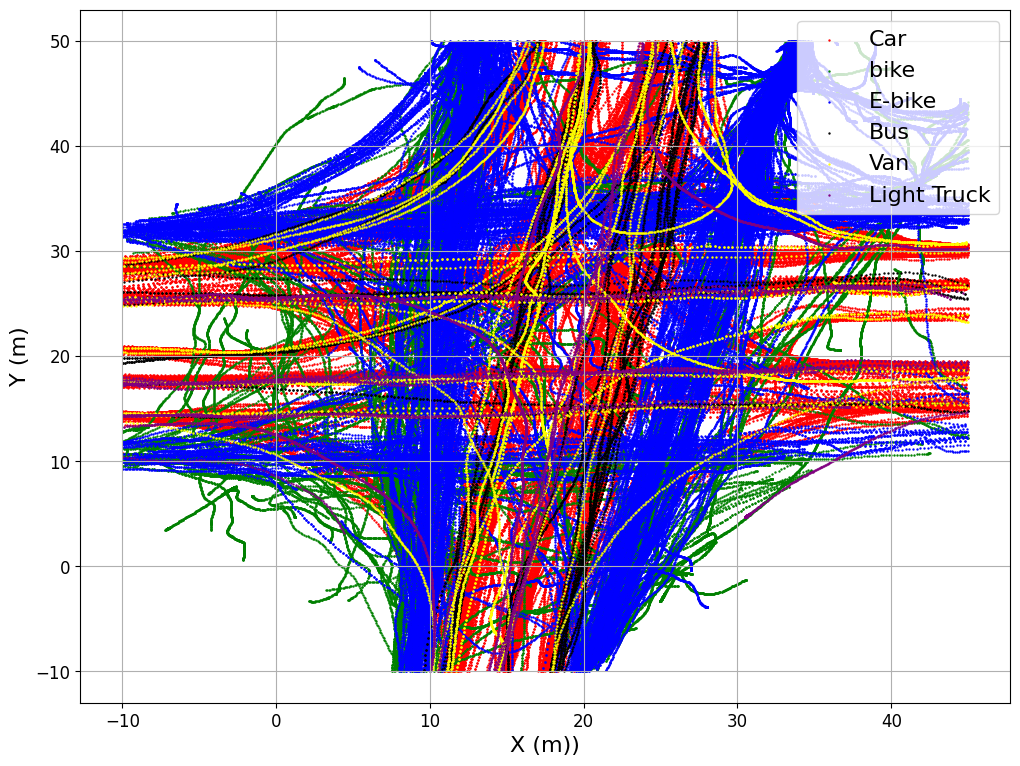

In [ ]:
# shown the map of trajectory
Map_trajectory_vehicle_type = pd.unique(Map_trajectory['vehicle_type'])
Map_trajectory_vehicle_type
Fig = vehicle_type_dif_color(Map_trajectory)

### Befor the calculate the pet, we should remove the noise in the trajectories! wavelet and Kalman filer were used in this section.
### The Module about the wavelet filters 
### Remove the noise of the trajectories use the wavelet filters.

In [ ]:
def wavelet_reduce_noise(input_data_path,output_data_path):
    'if you use this code you should format the trajectory at first.'
    Traje_clearn = pd.read_csv(input_data_path)
    traj_data_df = pd.DataFrame(Traje_clearn)
    df = traj_data_df
    vehid = pd.unique(df.vehicle_id)
    Wavelet_traj = df[['vehicle_id','frame_time','vehicle_type']]
    Wt = pd.DataFrame(Wavelet_traj)
    Wt['world_x']=''
    Wt['world_y']=''
    Wt['speed_x']=''
    Wt['speed_y']=''
    Wt['acc_x']=''
    Wt['acc_y']=''
    Wt['Jerk_x']=''
    Wt['Jerk_y']=''
    for id in range(0,len(vehid),1):
        veh_id = vehid[id]
        B =[]
        V =[]
        ACC = []
        Jerk=[]
        traj_data = df[df.vehicle_id==veh_id]
        if len(traj_data)>=50:  
            Frame_id = pd.unique(traj_data.frame_time)
            TRAJ_world_x = traj_data['world_x']
            TRAJ_world_y = traj_data['world_y']
            min_row = traj_data.loc[traj_data['frame_time']== min(Frame_id),].index[0]
            max_row = traj_data.loc[traj_data['frame_time']== max(Frame_id),].index[0]
            AA = traj_data.iloc[min_row:max_row+1,[3,4]] 
            A = df.iloc[min_row:max_row+1,[3,4]] 
            W_X = pd.array(wavelet_noising(TRAJ_world_x))
            B.append(W_X)
            W_Y = pd.array(wavelet_noising(TRAJ_world_y))
            B.append(W_Y)
            BB = pd.DataFrame(B)
            BBB = np.transpose(BB)
            if A.shape[0]<BBB.shape[0]:
                CB = BBB.iloc[0:A.shape[0],[0,1]]
            else:
                CB = BBB.iloc[0:len(BBB),[0,1]]
            Wt.iloc[min_row:max_row+1,[3,4]] = CB
            'Calculate the speed with wordx and word y'
            WTraj = Wt.iloc[min_row:max_row+1,0:5]
            speed_x,speed_y = Velocity(WTraj)
            V.append(speed_x)
            V.append(speed_y)
            VV = pd.DataFrame(V)
            VVV = np.transpose(VV)
            Wt.iloc[min_row:max_row+1,[5,6]] = VVV
            # 计算加速度
            WWTraj = Wt.iloc[min_row:max_row+1,0:7]
            acc_x,acc_y = Accelection(WWTraj)
            ACC.append(acc_x)
            ACC.append(acc_y)
            ACCC = pd.DataFrame(ACC)
            AACCC = np.transpose(ACCC)
            Wt.iloc[min_row:max_row+1,[7,8]] = AACCC  
            'calculate the jerk value'
            WWWTTraj = Wt.iloc[min_row:max_row+1,0:9]
            WWWTTTraj = pd.DataFrame(WWWTTraj)
            jerxx,jeryy = Aclculate_Jerk(WWWTTTraj)
            Jerk.append(jerxx)
            Jerk.append(jeryy)
            Jerkk = pd.DataFrame(Jerk)
            JJerkk = np.transpose(Jerkk)
            Wt.iloc[min_row:max_row+1,[9,10]] = JJerkk
        #     print(Wt.iloc[min_row:max_row+1,[9,10]])   
    Wt.to_csv(output_data_path,index=False, header=True)
    return Wt

In [ ]:
# 对数据进行降噪处理
input_data_path = r'/content/drive/MyDrive /Colab Notebooks/Traffic_Conflict/dataset/clearn_data/C0008.csv'
save_path = r'/content/drive/MyDrive /Colab Notebooks/Traffic_Conflict/dataset/conflict_indector/C0008.csv'
Trajectory = wavelet_reduce_noise(input_data_path,save_path)

/usr/local/lib/python3.9/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


### define the calculate index

In [ ]:
def Speed_Caluca(Traj_OD):
    # 计算速度值
    Delta = (Traj_OD.values[1] - Traj_OD.values[0])
    squre = [num * num for num in Delta]
    Sum = sum(squre)
    Distance = math.sqrt(Sum)
    Speed = Distance / time_gap
    return Speed

def Montion_Equations(Traj_OD):
    # 根据已知的两点计算直线方程
    # 创建一个空的 DataFrame
    Line_parmeter = pd.DataFrame(columns=['A', 'B', 'C'],index=[1]) # if you want create a new datafram you should add index=[1], it mean row
    Line_parmeter['A'] = Traj_OD['world_y'].values[1]-Traj_OD['world_y'][0]
    Line_parmeter['B'] = Traj_OD['world_x'].values[0] - Traj_OD['world_x'][1]
    Line_parmeter['C']= Traj_OD['world_x'].values[1]*Traj_OD['world_y'].values[0]-Traj_OD['world_x'].values[0]*Traj_OD['world_y'].values[1]
    return Line_parmeter

def Point_of_cross(Line_parmeter_1,Line_parmeter_2):
    # 计算两条直线的相交点
    Point_cross = pd.DataFrame()
    D = (Line_parmeter_1['A'].values)*(Line_parmeter_2['B'].values)-(Line_parmeter_2['A'].values)*(Line_parmeter_1['B'].values)
    # what is the D?
    if D !=0:
        point_x = ((Line_parmeter_1['B'].values)*(Line_parmeter_2['C'].values)-(Line_parmeter_2['B'].values)*(Line_parmeter_1['C'].values))/D
        Point_cross['world_x'] = point_x
        point_y = ((Line_parmeter_2['A'].values)*(Line_parmeter_1['C'].values)-(Line_parmeter_1['A'].values)*(Line_parmeter_2['C'].values))/D
        Point_cross['world_y'] = point_y
    # else:
    #     print("两直线平行")
    return Point_cross

def PET(Point_cross,speed_A,speed_B,Traj_OD_A,Traj_OD_B):
    # calculate the PET between the two vehicle
    # 计算A车到达冲突点的时间
    'if there is no point of cross, we will not calculate the time'
    if len(Point_cross)>=1:
        Delta_a = Point_cross.values[0]-Traj_OD_A.values[1]
        squre_a = [num*num for num in Delta_a]
        sum_dis_a = sum(squre_a)
        Dis_cross_a = math.sqrt(sum_dis_a)
        time_point_a = Dis_cross_a/speed_A
        # 计算B车到达冲突点的时间
        Delta_b = Point_cross.values[0]-Traj_OD_B.values[1]
        squre_b = [num*num for num in Delta_b]
        sum_dis_b = sum(squre_b)
        Dis_cross_b = math.sqrt(sum_dis_b)
        time_point_b = Dis_cross_b/speed_B
        # 计算经过冲突点的时间
        PET = abs(time_point_a-time_point_b)
    else:
        # print('There is no cross point')
        PET = 999999
    return PET

# def TTC()

def Veh_motion_state(traj_all_data,veh_id,Time_frame):
    'extracte the motion state of vehicle_id'
    "提取主车在time_frame时刻的运动状态"
    Traj_veh_id = traj_all_data[traj_all_data['vehicle_id'] == veh_id]
    Time_frame = np.around(Time_frame, decimals=2)
    Traj_veh_id_time_O = Traj_veh_id[Traj_veh_id['frame_time'] == Time_frame]
    Next_frame = Time_frame+0.04
    Next_frame = np.around(Next_frame, decimals=2)
    Traj_veh_id_time_D = Traj_veh_id[Traj_veh_id['frame_time'] == Next_frame]
    Traj_veh_id_OD = pd.concat([Traj_veh_id_time_O, Traj_veh_id_time_D], ignore_index=True)
    Veh_a_point = Traj_veh_id_OD[['world_x', 'world_y']]
    # print(Veh_a_point)
    return Veh_a_point

In [ ]:
Data_pathata = r'/content/drive/MyDrive /Colab Notebooks/Traffic_Conflict/dataset/conflict_indector/C0008.csv'
Wt = pd.read_csv(Data_pathata)

In [ ]:
# import the data
Data_pathata = r'/content/drive/MyDrive /Colab Notebooks/Traffic_Conflict/dataset/conflict_indector/C0008.csv'
traj_data = pd.read_csv(Data_pathata)
ALL_Time_frames = pd.unique(traj_data['frame_time'])
ALL_Time_frames.sort() # attention the method of the .sort()
# set the time gaps
time_gap = 0.04
# the total of frame time
Time_frames = ALL_Time_frames

#### 是否可以通过定义函数的形式来给现在的代码进行精简，达到便捷和高效的效果呢？
#### 如果按照面向对象的编程思想，那一块的内容可以拿出来独立成为体系呢？
#### 另外代码还需要添加新的计算内容，TTC、Delta V。所得到的的最终的表格应该包含：运动状态变量和冲突指标变量。
#### 进一步提取冲突时间的过程。

In [ ]:
# Generate columns
Columns_name = ['m_vehicle_id','m_frame_time','m_vehicle_type', 'm_world_x', 'm_world_y', 'm_speed_x', 'm_speed_y',
                'm_acc_x', 'm_acc_y', 'm_Jerk_x', 'm_Jerk_y',
                'sub_vehicle_id', 'sub_vehicle_type', 'sub_world_x', 'sub_world_y', 'sub_speed_x', 'sub_speed_y',
                'sub_acc_x', 'sub_acc_y', 'sub_Jerk_x', 'sub_Jerk_y',
                'cross_point_x', 'cross_point_y', 'PET']

'Creat the list to save all time result'
df_all_time = pd.DataFrame(columns=Columns_name)
for num_id in range(0,len(Time_frames),1):
    # uqdate with time_frame............................jhkjkh
    # 'Creat the list to save every frame time result'
#     print('............................................new time......................................................')
    if num_id < len(Time_frames):
        time_frame = Time_frames[num_id]
        print(time_frame)
        Traj_same_time = traj_data[traj_data['frame_time'] == time_frame]
#         print(Traj_same_time['vehicle_id'])
        Veh_same_times = pd.unique(Traj_same_time['vehicle_id'])
        #Need to determine if there is still a vehicle in the system in the next second
        Next_fram_time = time_frame+0.04
        Veh_same_times_next_frame_time = traj_data[traj_data['frame_time'] == Next_fram_time]
        if len(Veh_same_times) >= 2 and len(Veh_same_times_next_frame_time) >= 2:
            'create a list save each main vehicle'
            A = pd.DataFrame(
                    columns=['m_vehicle_id', 'm_frame_time','m_vehicle_type', 'm_world_x', 'm_world_y', 'm_speed_x',
                             'm_speed_y', 'm_acc_x', 'm_acc_y', 'm_Jerk_x', 'm_Jerk_y',
                             'sub_vehicle_id', 'sub_vehicle_type', 'sub_world_x', 'sub_world_y', 'sub_speed_x',
                             'sub_speed_y',
                             'sub_acc_x', 'sub_acc_y', 'sub_Jerk_x', 'sub_Jerk_y',
                             'cross_point_x', 'cross_point_y', 'PET'])
            for veh_id in Veh_same_times:
                # the main vehicel Uqdate with vehicle_id    
#                 print('------------------------'+str(veh_id)+'----------------------------------------------')
                Traj_M_veh = Traj_same_time[Traj_same_time['vehicle_id'] == veh_id]
                Traj_M_veh = pd.DataFrame(Traj_M_veh)
                df_main_veh = pd.DataFrame(
                    columns=['m_vehicle_id', 'm_frame_time','m_vehicle_type', 'm_world_x', 'm_world_y', 'm_speed_x',
                             'm_speed_y', 'm_acc_x', 'm_acc_y', 'm_Jerk_x', 'm_Jerk_y',
                             'sub_vehicle_id', 'sub_vehicle_type', 'sub_world_x', 'sub_world_y', 'sub_speed_x',
                             'sub_speed_y',
                             'sub_acc_x', 'sub_acc_y', 'sub_Jerk_x', 'sub_Jerk_y',
                             'cross_point_x', 'cross_point_y', 'PET'])
                df_main_veh[
                    ['m_vehicle_id', 'm_frame_time', 'm_vehicle_type','m_world_x', 'm_world_y', 'm_speed_x', 'm_speed_y',
                     'm_acc_x', 'm_acc_y', 'm_Jerk_x', 'm_Jerk_y']] = Traj_M_veh       
                Veh_a_point = Veh_motion_state(traj_data, veh_id, time_frame)       
                if len(Veh_a_point) >= 2:
                    Speed_a = Speed_Caluca(Veh_a_point)
                    Line_parmeter_1 = Montion_Equations(Veh_a_point)
                    Sub_Veh_same_time = Veh_same_times
                    'creat a list to save the result of every sub_veh_variable'
                    Sub_vehicle_temp = pd.DataFrame(columns=['sub_veh_id', 'cross_point_x', 'cross_point_y', 'PET'])
                    Sub_veh_id_A = []
                    cross_point_B = []
                    PET_C = []
                    for Sub_veh_id in Sub_Veh_same_time:
                        #for Sub_veh_id in Sub_Veh_same_time:
#                         print('==================================='+str(Sub_veh_id)+'=====================================')
                        'extracte the motion state of sub vehicle'
                        Traj_sub_veh = Traj_same_time[Traj_same_time['vehicle_id'] == Sub_veh_id]
                        Veh_b_point = Veh_motion_state(traj_data, Sub_veh_id, time_frame)
                        if len(Veh_b_point) >= 2:
                            Speed_b = Speed_Caluca(Veh_b_point)
                            Line_parmeter_2 = Montion_Equations(Veh_b_point)   
                            'Calculate the cross point'
                            cross_point = Point_of_cross(Line_parmeter_1, Line_parmeter_2)
                            # if there are no cross points, we should stop the next step
                            if len(cross_point) != 0:
                                'calculate the PET'
                                conflict_pet = PET(cross_point, Speed_a, Speed_b, Veh_a_point, Veh_b_point)
                                # creat a list which contain the vehicle information and the PET at every frame
                                Sub_veh_id_A.append(Sub_veh_id)
                                cross_point_B.append(cross_point.values[0])
                                PET_C.append(conflict_pet)

                    Sub_veh_id = pd.DataFrame(Sub_veh_id_A)
                    Sub_vehicle_temp['sub_veh_id'] = Sub_veh_id_A
                    Sub_vehicle_temp[['cross_point_x','cross_point_y']] = cross_point_B
                    Sub_vehicle_temp['PET'] = PET_C
                    Min_pet_value = min(Sub_vehicle_temp['PET'])
                    Min_pet_sub_veh = Sub_vehicle_temp[Sub_vehicle_temp['PET'] == Min_pet_value]
                    MIN_PET_SUB = Min_pet_sub_veh[['cross_point_x', 'cross_point_y', 'PET']]
                    sub_veh_min_pet_id = Min_pet_sub_veh['sub_veh_id'].values[0]

                sub_veh_inf = Traj_same_time[Traj_same_time['vehicle_id'] == sub_veh_min_pet_id]
                traj_data_sub_min_pet_id = sub_veh_inf[
                    ['vehicle_id', 'vehicle_type', 'world_x', 'world_y', 'speed_x', 'speed_y', 'acc_x', 'acc_y', 'Jerk_x','Jerk_y']]
                traj_data_sub_min_pet_id = pd.DataFrame(traj_data_sub_min_pet_id)
                df_main_veh[
                    ['sub_vehicle_id', 'sub_vehicle_type', 'sub_world_x', 'sub_world_y', 'sub_speed_x', 'sub_speed_y',
                     'sub_acc_x', 'sub_acc_y', 'sub_Jerk_x', 'sub_Jerk_y']] = traj_data_sub_min_pet_id.values[0]
                df_main_veh[['cross_point_x', 'cross_point_y', 'PET']] = MIN_PET_SUB.values[0]
                # Integration of all vehicle data at the same moment
                integer_A_df_main_veh = [A,df_main_veh]
                A = pd.concat(integer_A_df_main_veh)

    Integer_A_all_time = [df_all_time,A]
    df_all_time = pd.concat(Integer_A_all_time) 
df_all_time.to_csv('/content/drive/MyDrive /Colab Notebooks/Traffic_Conflict/dataset/conflict_indector/Conflict_C0008.csv',index=False, header=True)

Streaming output truncated to the last 5000 lines.
374.92
374.96
375.0
375.04
375.08
375.12
375.16
375.2
375.24
375.28
375.32
375.36
375.4
375.44
375.48
375.52
375.56
375.6
375.64
375.68
375.72
375.76
375.8
375.84
375.88
375.92
375.96
376.0
376.04
376.08
376.12
376.16
376.2
376.24
376.28
376.32
376.36
376.4
376.44
376.48
376.52
376.56
376.6
376.64
376.68
376.72
376.76
376.8
376.84
376.88
376.92
376.96
377.0
377.04
377.08
377.12
377.16
377.2
377.24
377.28
377.32
377.36
377.4
377.44
377.48
377.52
377.56
377.6
377.64
377.68
377.72
377.76
377.8
377.84
377.88
377.92
377.96
378.0
378.04
378.08
378.12
378.16
378.2
378.24
378.28
378.32
378.36
378.4
378.44
378.48
378.52
378.56
378.6
378.64
378.68
378.72
378.76
378.8
378.84
378.88
378.92
378.96
379.0
379.04
379.08
379.12
379.16
379.2
379.24
379.28
379.32
379.36
379.4
379.44
379.48
379.52
379.56
379.6
379.64
379.68
379.72
379.76
379.8
379.84
379.88
379.92
379.96
380.0
380.04
380.08
380.12
380.16
380.2
380.24
380.28
380.32
380.36
380.4
380.44
380.

Import the dataset，and and then analys the feature of the conflict at intersection 

In [ ]:
PET_data_path = r'/content/drive/MyDrive /Colab Notebooks/Traffic_Conflict/dataset/conflict_indector/Conflict_C0008.csv'
pet_data = pd.read_csv(PET_data_path)
pet_df = pd.DataFrame(pet_data)
# Data clearn 
# if the pet >10(s),we should mark it with no conflict 
pet_df['PET'][pet_df.PET>100]== 100
# 剔除表格单元格中的空格符
pet_df2 = pet_df.applymap(lambda x: str(x).strip())

In [ ]:
pet_df2

m_vehicle_id m_frame_time m_vehicle_type    m_world_x     m_world_y  \
0                 3          0.0        Bicycle  7.915862779   21.99274856   
1                 7          0.0            Car  16.23132288   34.17000965   
2                 8          0.0            Car  16.00354856   24.19871336   
3                11          0.0            Car  16.07706193  -0.252059936   
4                18          0.0            Car  13.98305223   16.21254951   
...             ...          ...            ...          ...           ...   
172300         1067       574.84            Car  33.02402202   34.88728279   
172301          972       574.84            Car  43.44212047   15.55955769   
172302          981       574.84     Motorcycle  16.58997491   47.46999544   
172303         1060       574.84            Car  28.97087977   38.89965761   
172304         1067       574.84            Car  33.02402202   34.88728279   

           m_speed_x     m_speed_y       m_acc_x       m_acc_y      m_Jerk_x  \
0                0.0           0.0           0.0           0.0           0.0   
1                0.0           0.0           0.0           0.0           0.0   
2                0.0           0.0           0.0           0.0           0.0   
3                0.0           0.0           0.0           0.0           0.0   
4                0.0           0.0           0.0           0.0           0.0   
...              ...           ...           ...           ...           ...   
172300  -0.615927677   0.344719641   -7.06492763   4.160014511  -198.8150966   
172301   5.352777305  -0.153167252   1.506340001   0.367581143  -83.77731618   
172302  -2.505939158  -0.500167548   0.113037672   6.239896667   16.81360007   
172303   0.004769605  -0.005127416  -0.036783479  -0.005128612   0.062841765   
172304  -0.615927677   0.344719641   -7.06492763   4.160014511  -198.8150966   

        ...  sub_world_y   sub_speed_x   sub_speed_y    sub_acc_x  \
0       ...  34.17000965           0.0           0.0          0.0   
1       ...  39.97057492           0.0           0.0          0.0   
2       ...  16.21254951           0.0           0.0          0.0   
3       ...  39.97057492           0.0           0.0          0.0   
4       ...  24.19871336           0.0           0.0          0.0   
...     ...          ...           ...           ...          ...   
172300  ...  47.46999544  -2.505939158  -0.500167548  0.113037672   
172301  ...  47.46999544  -2.505939158  -0.500167548  0.113037672   
172302  ...  15.55955769   5.352777305  -0.153167252  1.506340001   
172303  ...  34.88728279  -0.615927677   0.344719641  -7.06492763   
172304  ...  47.46999544  -2.505939158  -0.500167548  0.113037672   

          sub_acc_y    sub_Jerk_x   sub_Jerk_y cross_point_x cross_point_y  \
0               0.0           0.0          0.0   9.167699813  -13.85396059   
1               0.0           0.0          0.0   12.95566292   11.89954096   
2               0.0           0.0          0.0   16.23832933   28.87747038   
3               0.0           0.0          0.0   13.45967778  -44.81053487   
4               0.0           0.0          0.0   16.23832933   28.87747038   
...             ...           ...          ...           ...           ...   
172300  6.239896667   16.81360007  312.0139061   12.46815961   46.63930149   
172301  6.239896667   16.81360007  312.0139061  -127.8694976   18.35621883   
172302  0.367581143  -83.77731618    22.054341  -127.8694976   18.35621883   
172303  4.160014511  -198.8150966  114.6673672   30.95747938   36.06874855   
172304  6.239896667   16.81360007  312.0139061   12.46815961   46.63930149   

                PET  
0       3.340737936  
1       0.049365233  
2        1.23085025  
3        0.40027613  
4        1.23085025  
...             ...  
172300  36.23848681  
172301  26.91862449  
172302  26.91862449  
172303  554.0519656  
172304  36.23848681  

[172305 rows x 24 columns]

根据冲突车辆的类别对冲突事件进行分类：

In [ ]:
# defining the libraries
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ks_2samp
%matplotlib inline

# class the conflict into car-bicycle, car-car,car-ebkie, here we dont need to  distribution the min vehicel and sub vehicle.
data_original =pet_df[pet_df['PET']<=10]
vehicle_type = pd.unique(data_original['m_vehicle_type'])
print(vehicle_type)

def distribution_conflict(data_conflict,min_veh_type,s_vehicle_type):
    "here we will make an class of the conflict"
    # print(data_conflict)
    m_conflict_data = data_conflict[data_conflict['m_vehicle_type']==min_veh_type]
    s_conflict_data = data_conflict[data_conflict['sub_vehicle_type']==s_vehicle_type]
    # combin the data
    ms_conflict_data = [m_conflict_data,s_conflict_data]
    m_conflict_data = pd.concat(ms_conflict_data)
    return m_conflict_data

def Save_pet_data(data,save_path):
    Data = pd.DataFrame(data)
    save_file = Data.to_csv(save_path,index=False, header=True)
    return save_file

M_veh_type = " Car"
S_veh_type = " Motorcycle"
car_to_to_conflict = distribution_conflict(data_original,M_veh_type,S_veh_type)

Save_path_pet = '/content/drive/MyDrive /Colab Notebooks/Traffic_Conflict/dataset/conflict_indector/Car_to_E_bike.csv'
car_to_car_conflict = Save_pet_data(car_to_to_conflict,Save_path_pet)

[' Bicycle' ' Car' ' Van' ' Motorcycle' ' Bus' ' Light Truck' ' Tuk-Tuk']


The conflict type, the main vehicle Bicycle, the subvehicle  Bicycle. the total number is 10686


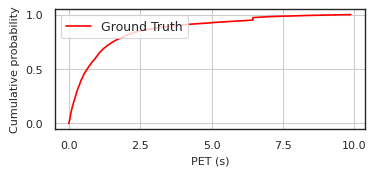

The conflict type, the main vehicle Bicycle, the subvehicle  Car. the total number is 10137


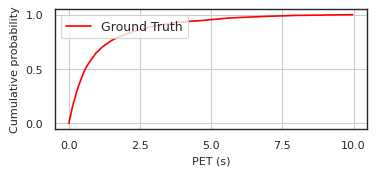

The conflict type, the main vehicle Bicycle, the subvehicle  Van. the total number is 854


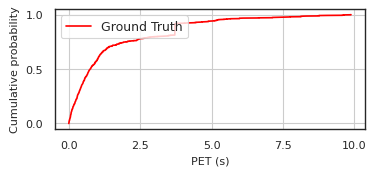

The conflict type, the main vehicle Bicycle, the subvehicle  Motorcycle. the total number is 11485


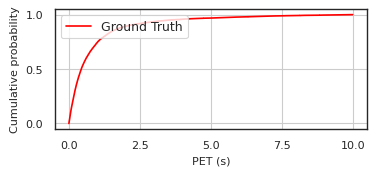

The conflict type, the main vehicle Bicycle, the subvehicle  Bus. the total number is 438


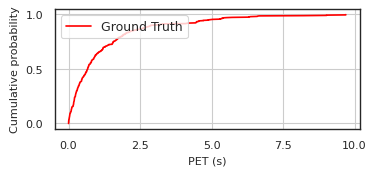

The conflict type, the main vehicle Bicycle, the subvehicle  Light Truck. the total number is 246


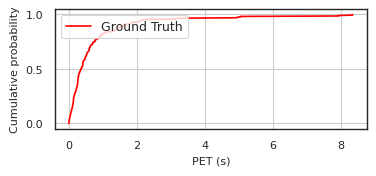

The conflict type, the main vehicle Bicycle, the subvehicle  Tuk-Tuk. the total number is 92


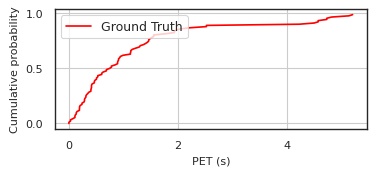

The conflict type, the main vehicle Car, the subvehicle  Bicycle. the total number is 9287


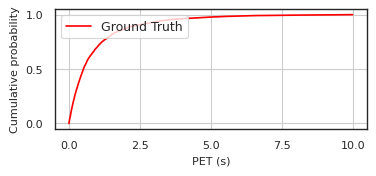

The conflict type, the main vehicle Car, the subvehicle  Car. the total number is 41532


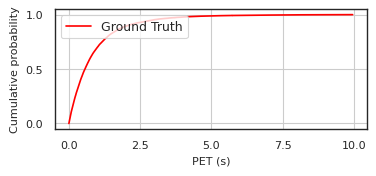

The conflict type, the main vehicle Car, the subvehicle  Van. the total number is 2162


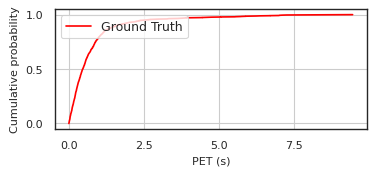

The conflict type, the main vehicle Car, the subvehicle  Motorcycle. the total number is 15279


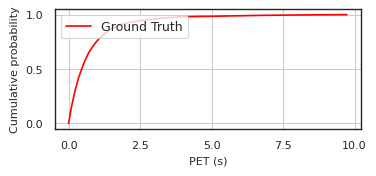

The conflict type, the main vehicle Car, the subvehicle  Bus. the total number is 1647


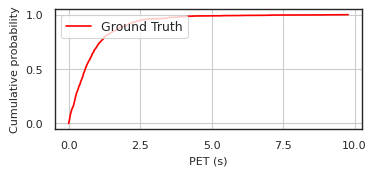

The conflict type, the main vehicle Car, the subvehicle  Light Truck. the total number is 860


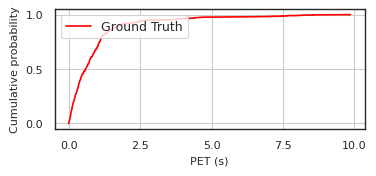

The conflict type, the main vehicle Car, the subvehicle  Tuk-Tuk. the total number is 334


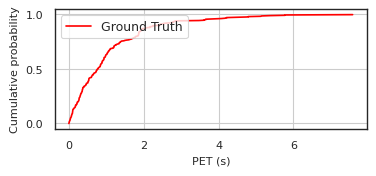

The conflict type, the main vehicle Van, the subvehicle  Bicycle. the total number is 816


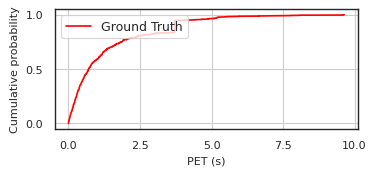

The conflict type, the main vehicle Van, the subvehicle  Car. the total number is 2233


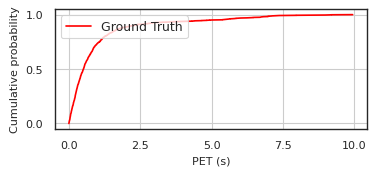

The conflict type, the main vehicle Van, the subvehicle  Van. the total number is 67


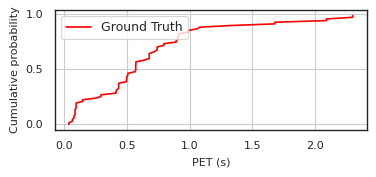

The conflict type, the main vehicle Van, the subvehicle  Motorcycle. the total number is 673


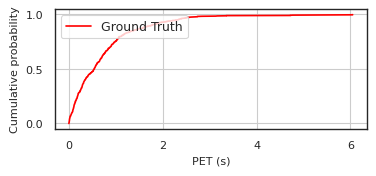

The conflict type, the main vehicle Van, the subvehicle  Bus. the total number is 72


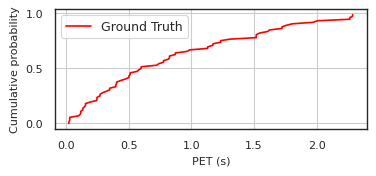

The conflict type, the main vehicle Van, the subvehicle  Light Truck. the total number is 33


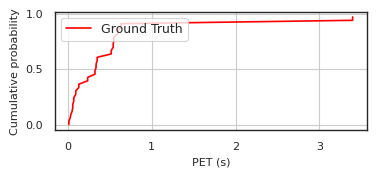

The conflict type, the main vehicle Van, the subvehicle  Tuk-Tuk. the total number is 13


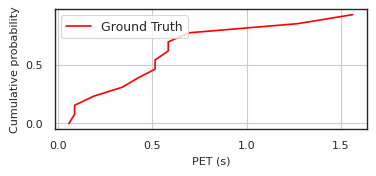

The conflict type, the main vehicle Motorcycle, the subvehicle  Bicycle. the total number is 9395


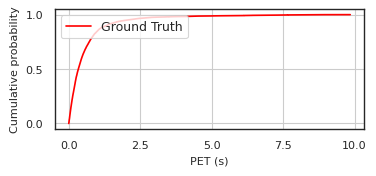

The conflict type, the main vehicle Motorcycle, the subvehicle  Car. the total number is 13723


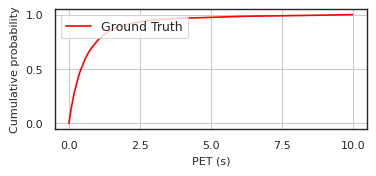

The conflict type, the main vehicle Motorcycle, the subvehicle  Van. the total number is 788


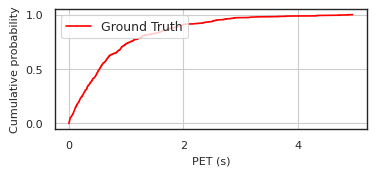

The conflict type, the main vehicle Motorcycle, the subvehicle  Motorcycle. the total number is 22205


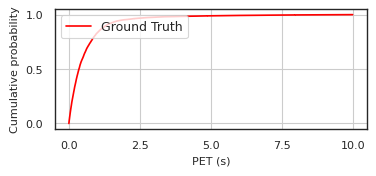

The conflict type, the main vehicle Motorcycle, the subvehicle  Bus. the total number is 976


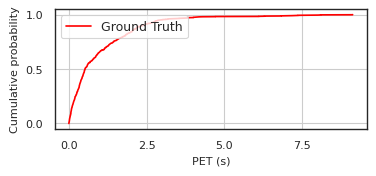

The conflict type, the main vehicle Motorcycle, the subvehicle  Light Truck. the total number is 269


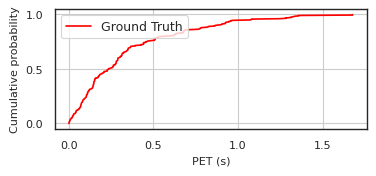

The conflict type, the main vehicle Motorcycle, the subvehicle  Tuk-Tuk. the total number is 47


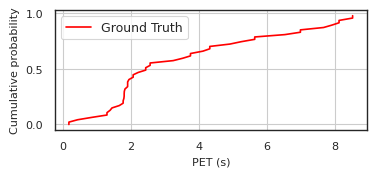

The conflict type, the main vehicle Bus, the subvehicle  Bicycle. the total number is 431


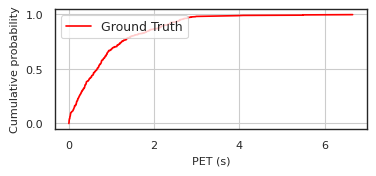

The conflict type, the main vehicle Bus, the subvehicle  Car. the total number is 1967


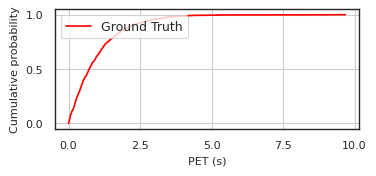

The conflict type, the main vehicle Bus, the subvehicle  Van. the total number is 81


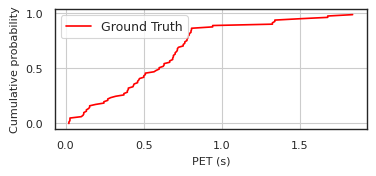

The conflict type, the main vehicle Bus, the subvehicle  Motorcycle. the total number is 962


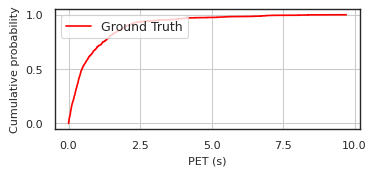

The conflict type, the main vehicle Bus, the subvehicle  Bus. the total number is 168


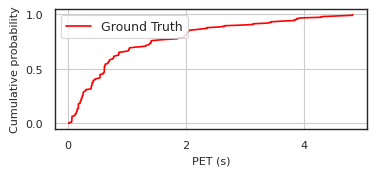

The conflict type, the main vehicle Bus, the subvehicle  Light Truck. the total number is 3


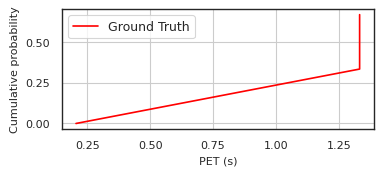

The conflict type, the main vehicle Bus, the subvehicle  Tuk-Tuk. the total number is 4


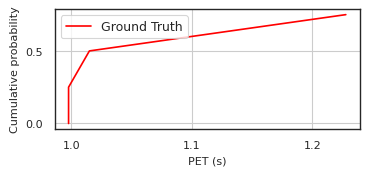

The conflict type, the main vehicle Light Truck, the subvehicle  Bicycle. the total number is 314


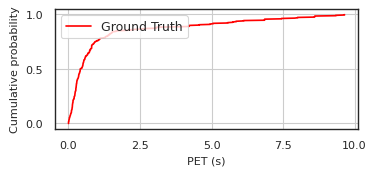

The conflict type, the main vehicle Light Truck, the subvehicle  Car. the total number is 861


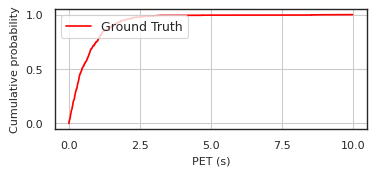

The conflict type, the main vehicle Light Truck, the subvehicle  Van. the total number is 67


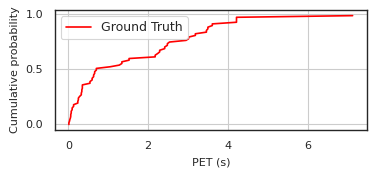

The conflict type, the main vehicle Light Truck, the subvehicle  Motorcycle. the total number is 409


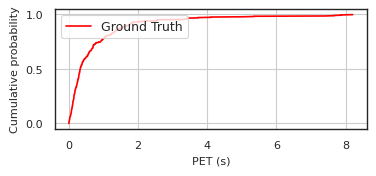

The conflict type, the main vehicle Light Truck, the subvehicle  Bus. the total number is 10


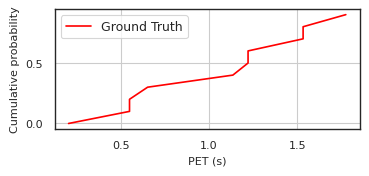

The conflict type, the main vehicle Light Truck, the subvehicle  Light Truck. the total number is 19


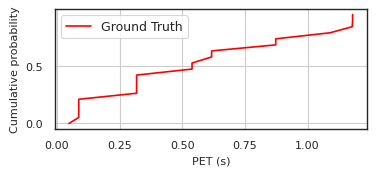

The conflict type, the main vehicle Light Truck, the subvehicle  Tuk-Tuk. the total number is 0


ValueError: ignored

In [ ]:
# " the fellow code class the conflict "
M_veh_type = data_original['m_vehicle_type'].unique()
for m_veh_type in M_veh_type:
    M_veh_pet = data_original[data_original['m_vehicle_type']==m_veh_type]
    for sub_veh_type in M_veh_type:
        M_veh_pet_sub = M_veh_pet[M_veh_pet['sub_vehicle_type'] ==sub_veh_type]
        data = M_veh_pet_sub['PET']
        print('The conflict type, the main vehicle'+str(m_veh_type)+', the subvehicle '+str(sub_veh_type)+'. the total number is '+str(len(data)))
        N = data.shape[0]
        Max_value = max(data)
        Min_pet = min(data)
        x = np.sort(data)
        y = np.arange(N) / float(N)
        fig = plt.figure(figsize=(4,2))   
        plt.xlabel('PET (s)',fontsize=8)
        plt.xticks(fontsize=8,rotation=0)
        plt.yticks(fontsize=8)
        plt.ylabel('Cumulative probability',fontsize=8)
        plt.plot(x, y,color='red',label='Ground Truth')
        plt.legend(loc="upper left",fontsize=9)   #设置图例字体大小
        plt.tight_layout()
        plt.grid()
        plt.show()

The conflict type, the main vehicle Bicycle, the subvehicle  Bicycle. the total number is 7664


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


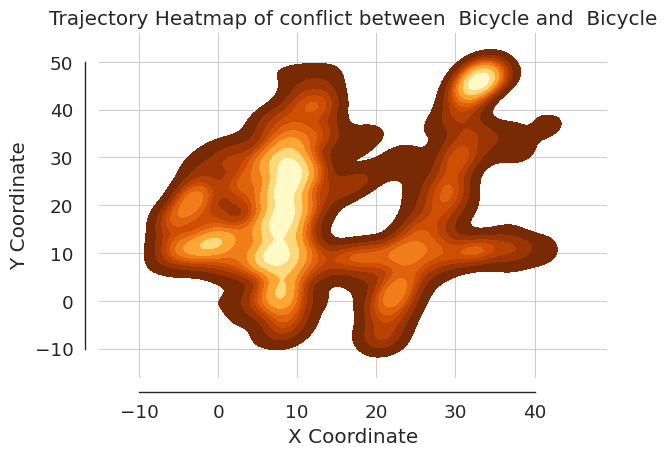

The conflict type, the main vehicle Bicycle, the subvehicle  Car. the total number is 6204


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


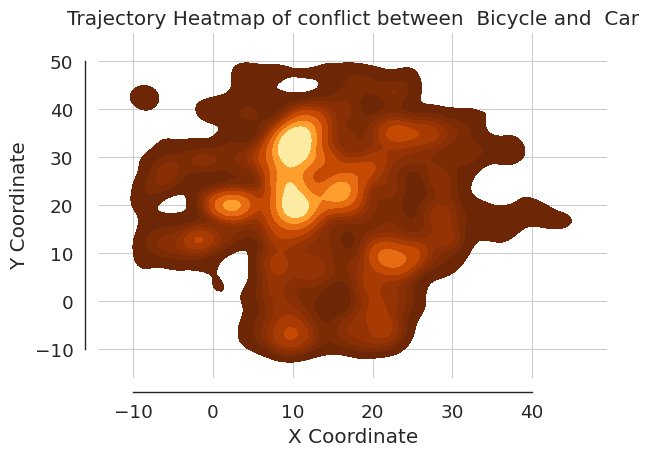

The conflict type, the main vehicle Bicycle, the subvehicle  Van. the total number is 535


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


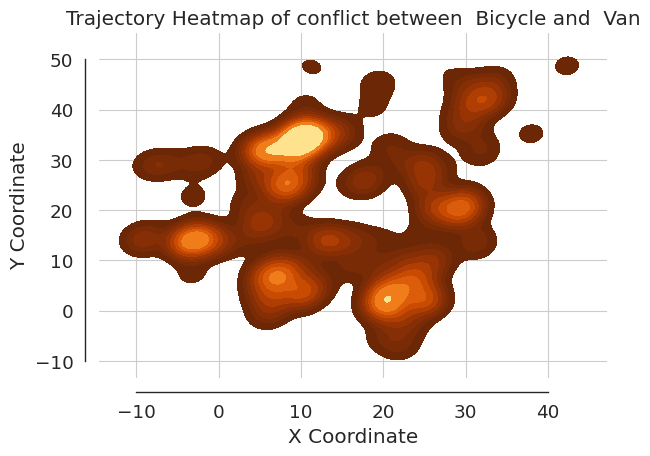

The conflict type, the main vehicle Bicycle, the subvehicle  Motorcycle. the total number is 7710


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


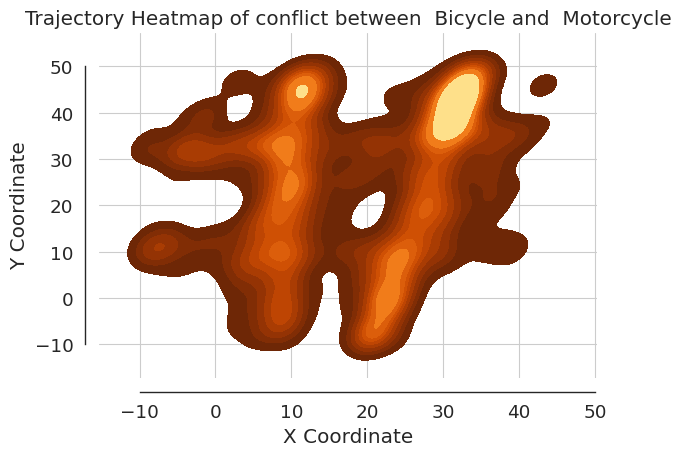

The conflict type, the main vehicle Bicycle, the subvehicle  Bus. the total number is 168


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


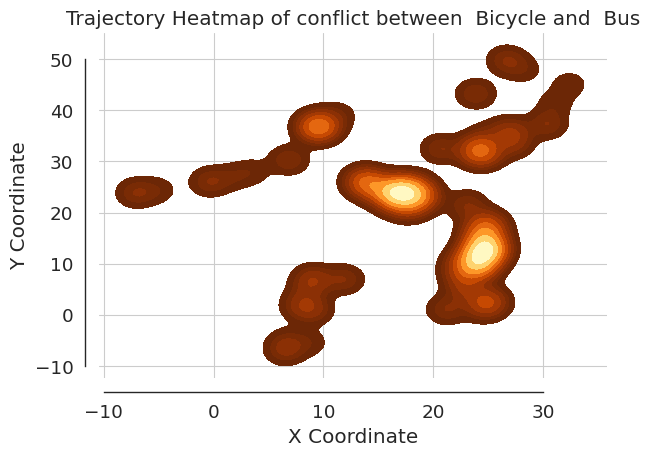

The conflict type, the main vehicle Bicycle, the subvehicle  Light Truck. the total number is 108


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


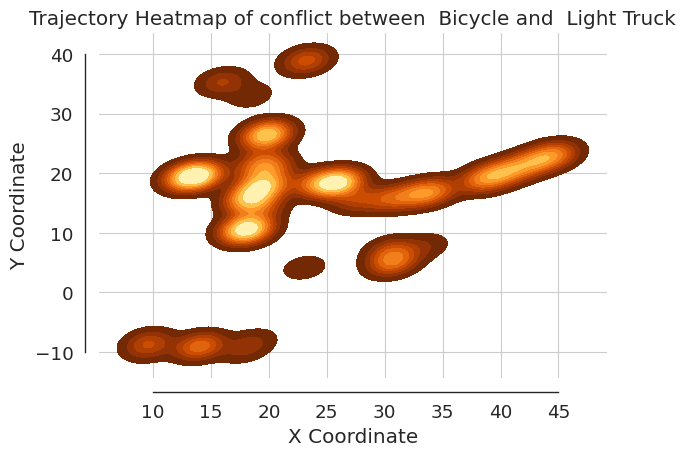

The conflict type, the main vehicle Bicycle, the subvehicle  Tuk-Tuk. the total number is 80


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


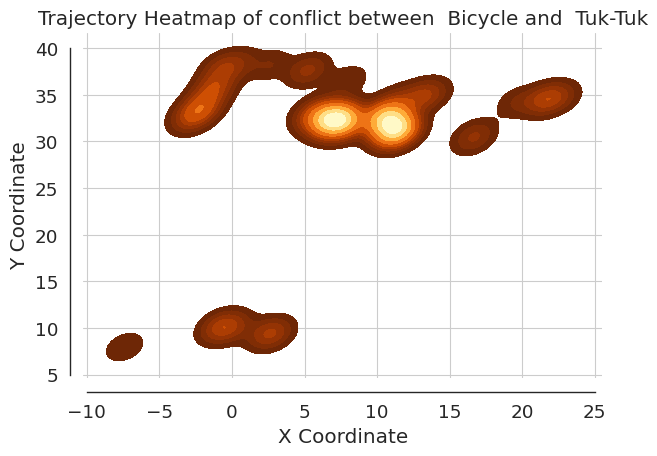

The conflict type, the main vehicle Car, the subvehicle  Bicycle. the total number is 5436


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


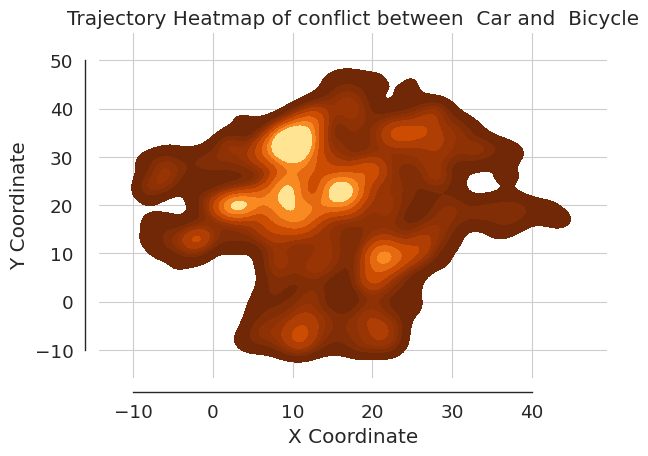

The conflict type, the main vehicle Car, the subvehicle  Car. the total number is 25526


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


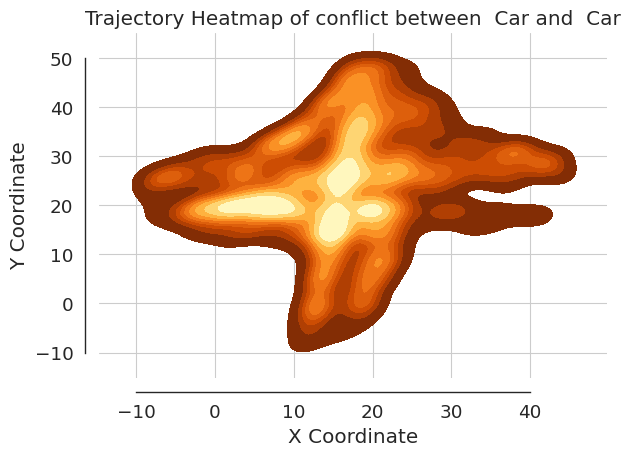

The conflict type, the main vehicle Car, the subvehicle  Van. the total number is 1268


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


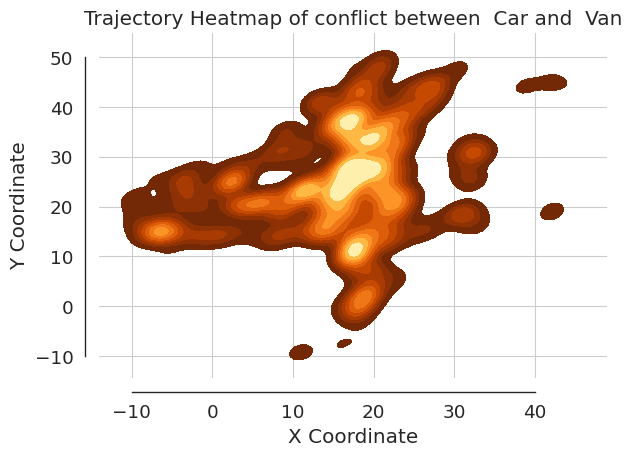

The conflict type, the main vehicle Car, the subvehicle  Motorcycle. the total number is 8240


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


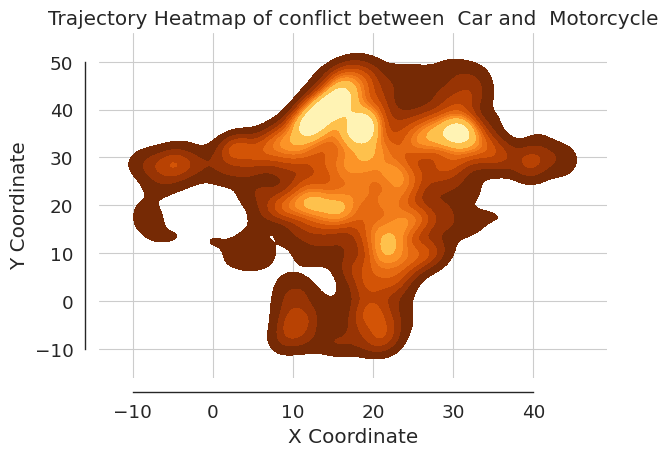

The conflict type, the main vehicle Car, the subvehicle  Bus. the total number is 722


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


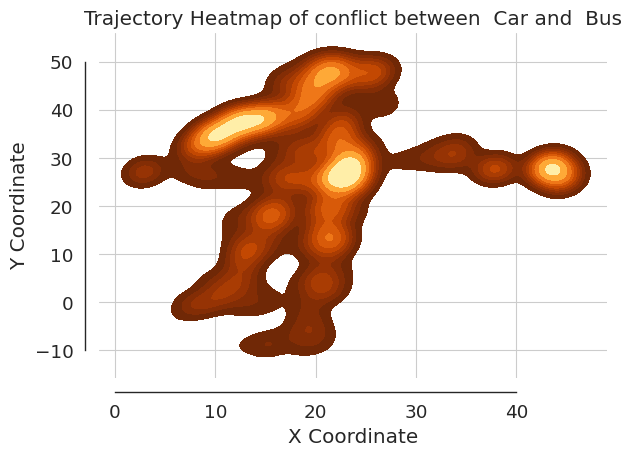

The conflict type, the main vehicle Car, the subvehicle  Light Truck. the total number is 341


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


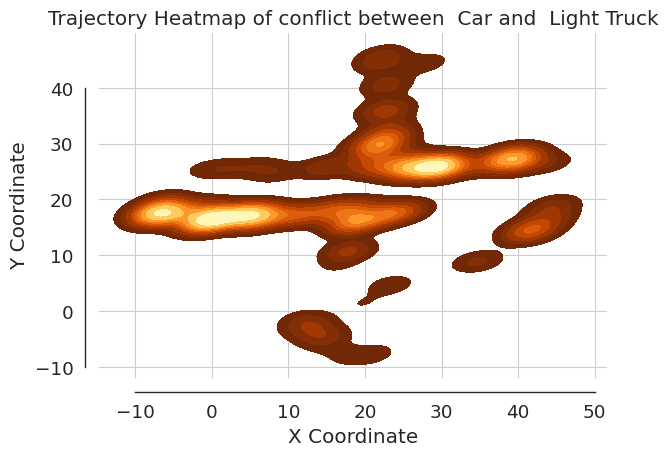

The conflict type, the main vehicle Car, the subvehicle  Tuk-Tuk. the total number is 261


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


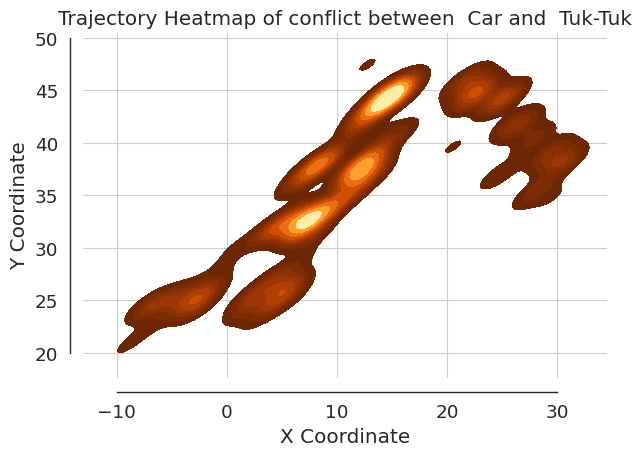

The conflict type, the main vehicle Van, the subvehicle  Bicycle. the total number is 498


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


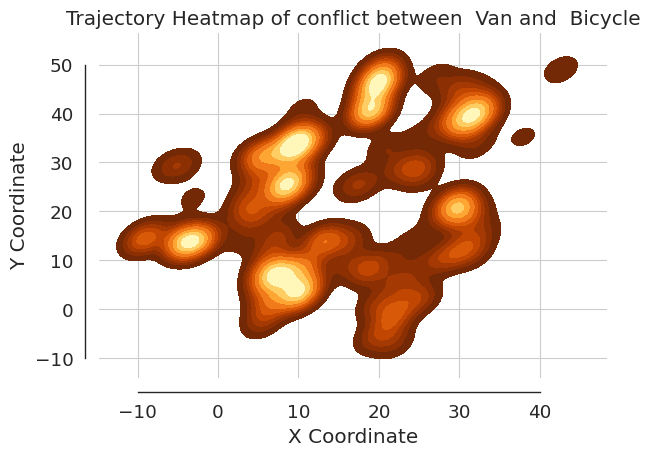

The conflict type, the main vehicle Van, the subvehicle  Car. the total number is 1395


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


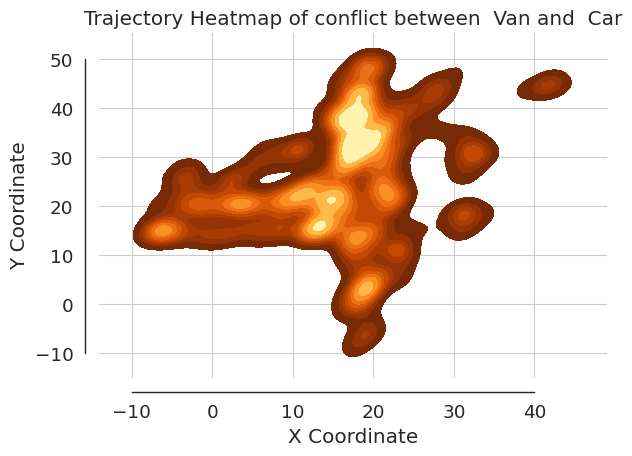

The conflict type, the main vehicle Van, the subvehicle  Van. the total number is 23


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


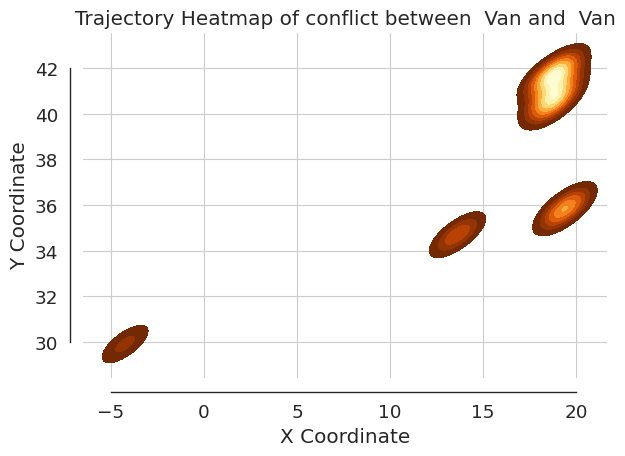

The conflict type, the main vehicle Van, the subvehicle  Motorcycle. the total number is 500


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


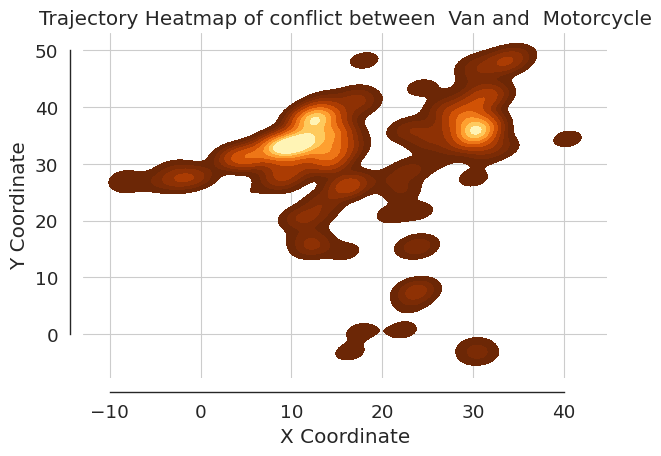

The conflict type, the main vehicle Van, the subvehicle  Bus. the total number is 26


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


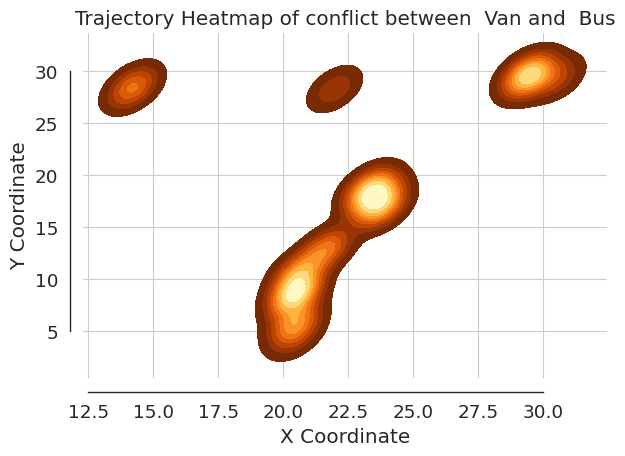

The conflict type, the main vehicle Van, the subvehicle  Light Truck. the total number is 21


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


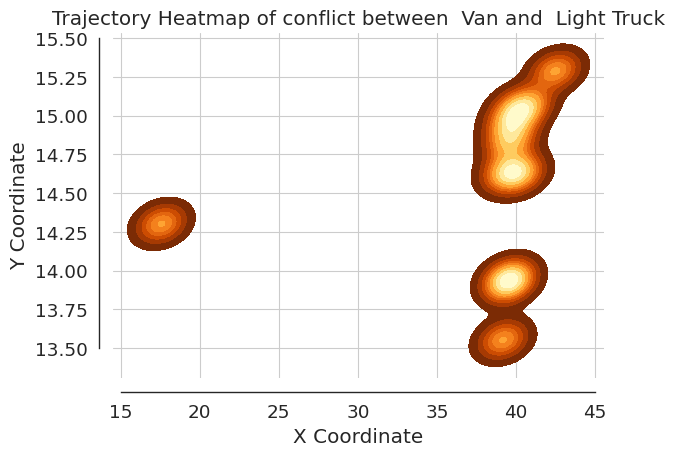

The conflict type, the main vehicle Van, the subvehicle  Tuk-Tuk. the total number is 0


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


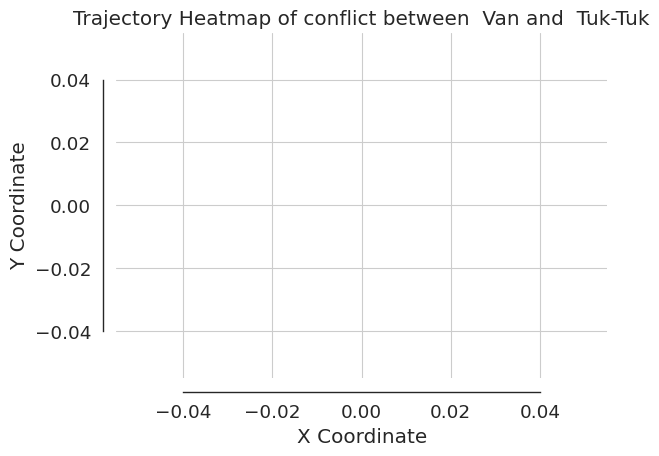

The conflict type, the main vehicle Motorcycle, the subvehicle  Bicycle. the total number is 6356


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


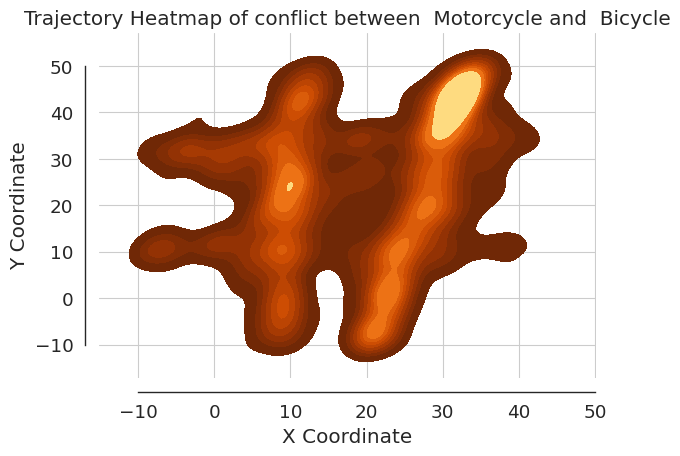

The conflict type, the main vehicle Motorcycle, the subvehicle  Car. the total number is 7465


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


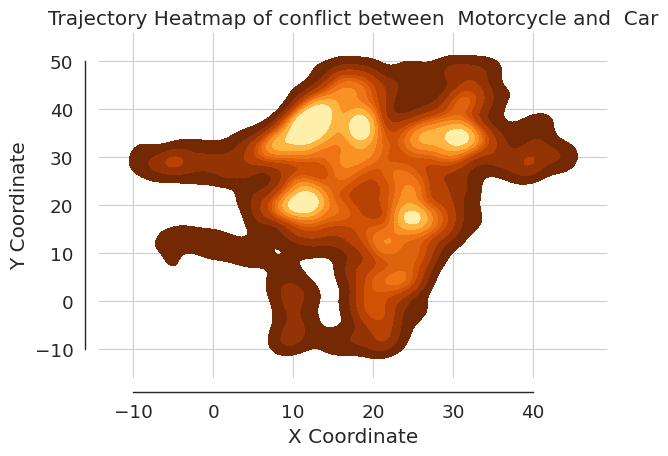

The conflict type, the main vehicle Motorcycle, the subvehicle  Van. the total number is 601


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


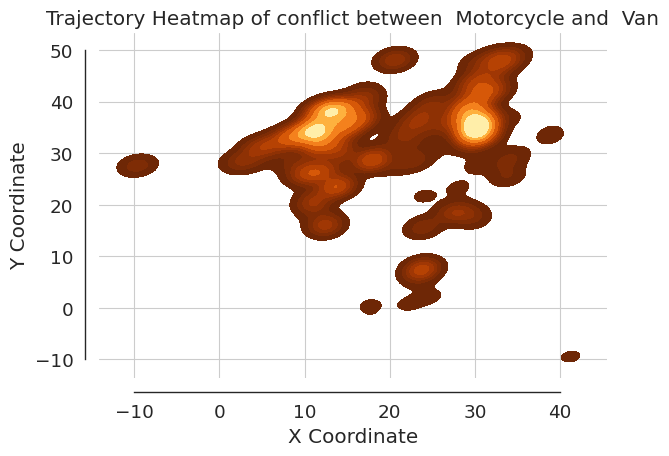

The conflict type, the main vehicle Motorcycle, the subvehicle  Motorcycle. the total number is 15162


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


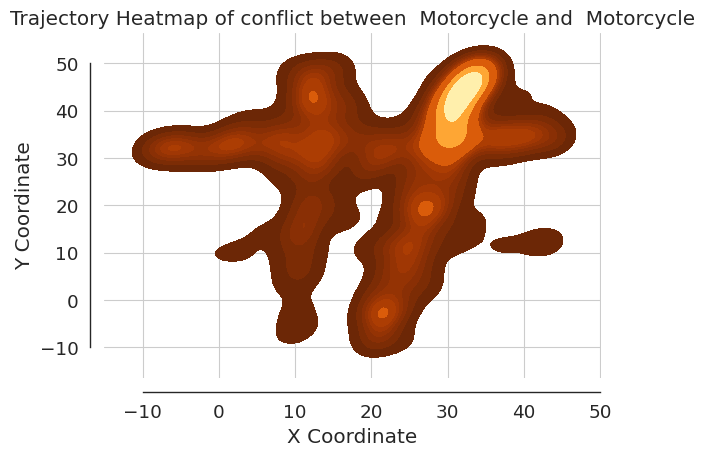

The conflict type, the main vehicle Motorcycle, the subvehicle  Bus. the total number is 566


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


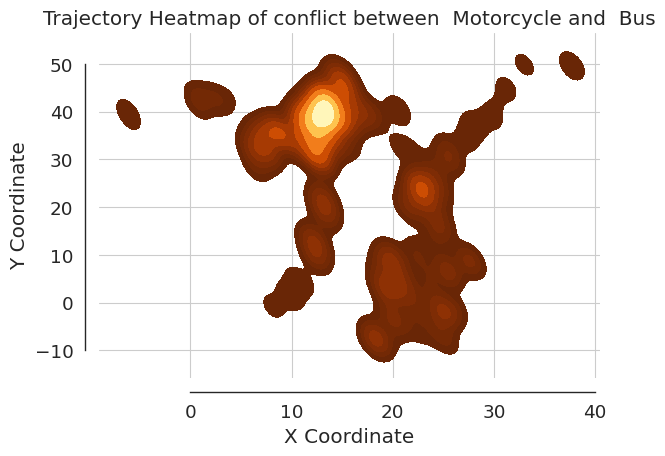

The conflict type, the main vehicle Motorcycle, the subvehicle  Light Truck. the total number is 53


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


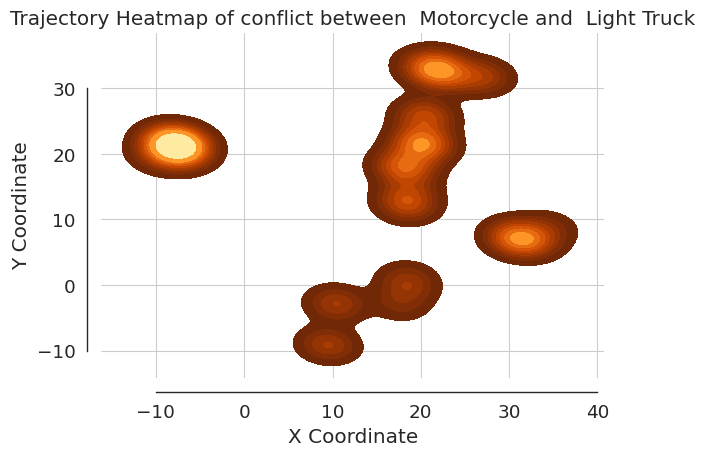

The conflict type, the main vehicle Motorcycle, the subvehicle  Tuk-Tuk. the total number is 35


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


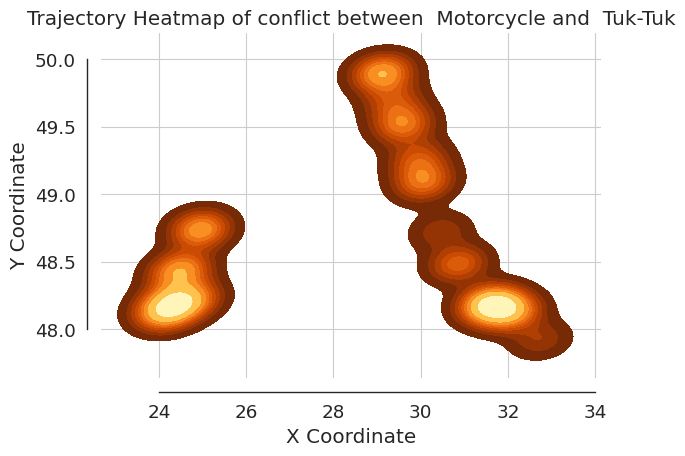

The conflict type, the main vehicle Bus, the subvehicle  Bicycle. the total number is 186


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


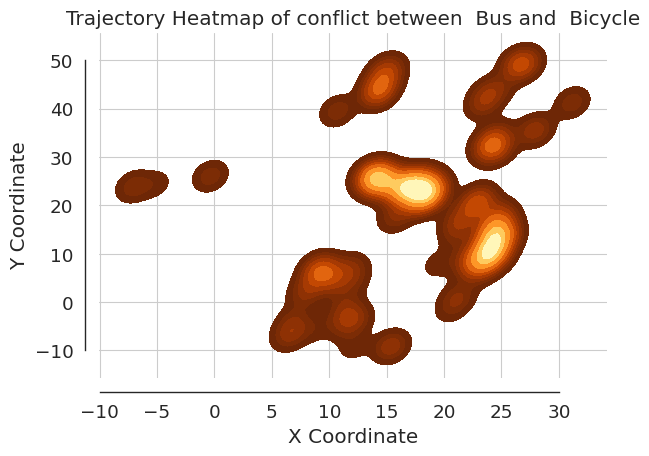

The conflict type, the main vehicle Bus, the subvehicle  Car. the total number is 1044


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


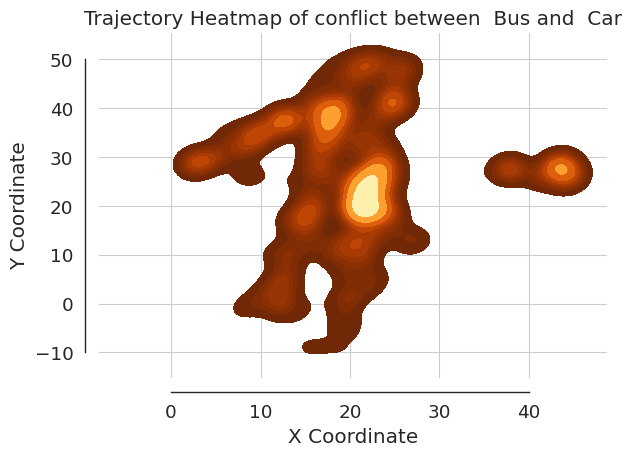

The conflict type, the main vehicle Bus, the subvehicle  Van. the total number is 48


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


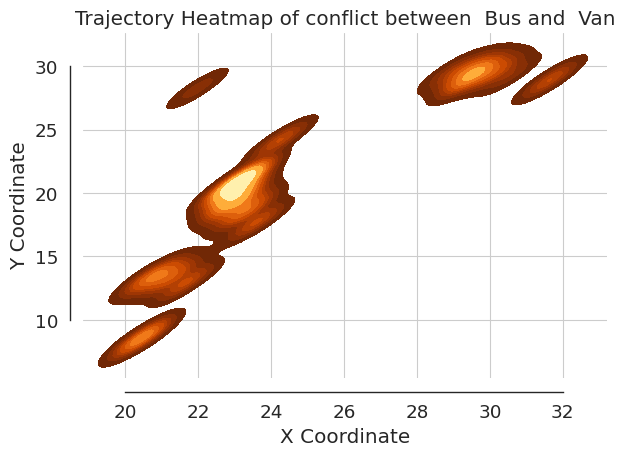

The conflict type, the main vehicle Bus, the subvehicle  Motorcycle. the total number is 462


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


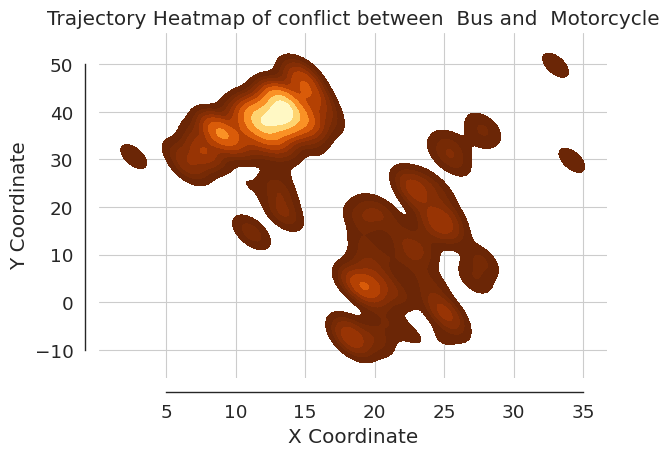

The conflict type, the main vehicle Bus, the subvehicle  Bus. the total number is 149


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


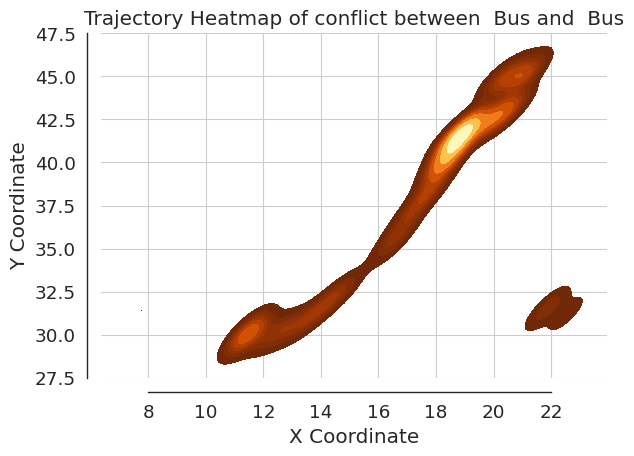

The conflict type, the main vehicle Bus, the subvehicle  Light Truck. the total number is 2


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


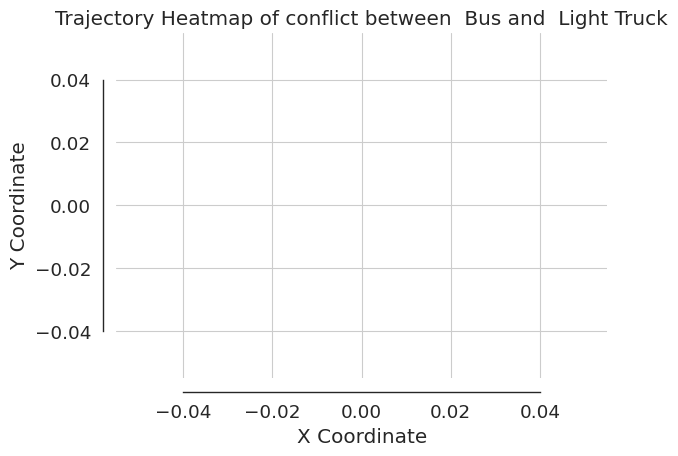

The conflict type, the main vehicle Bus, the subvehicle  Tuk-Tuk. the total number is 4


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


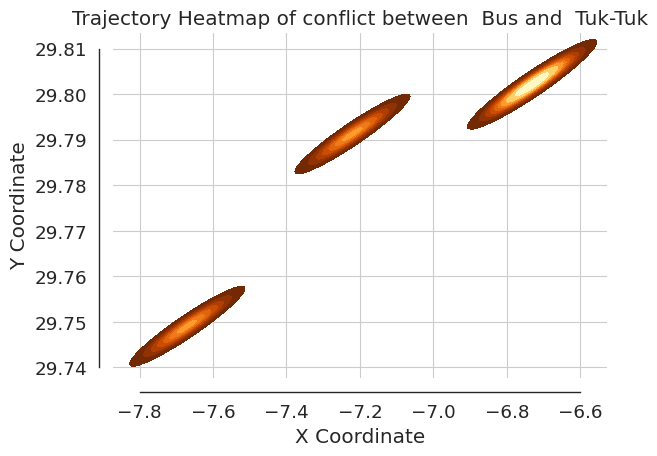

The conflict type, the main vehicle Light Truck, the subvehicle  Bicycle. the total number is 155


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


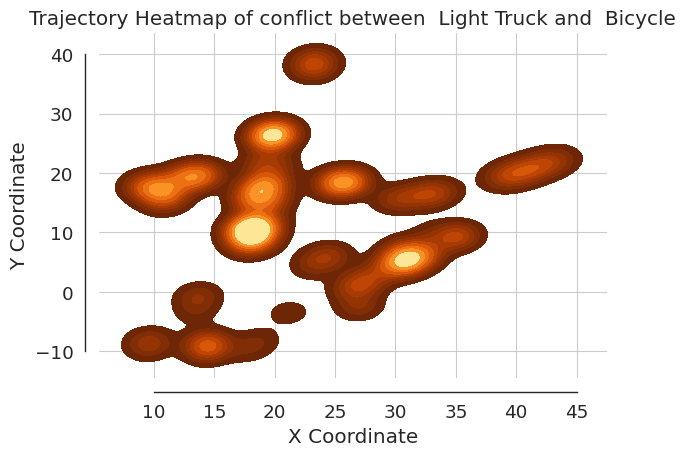

The conflict type, the main vehicle Light Truck, the subvehicle  Car. the total number is 361


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


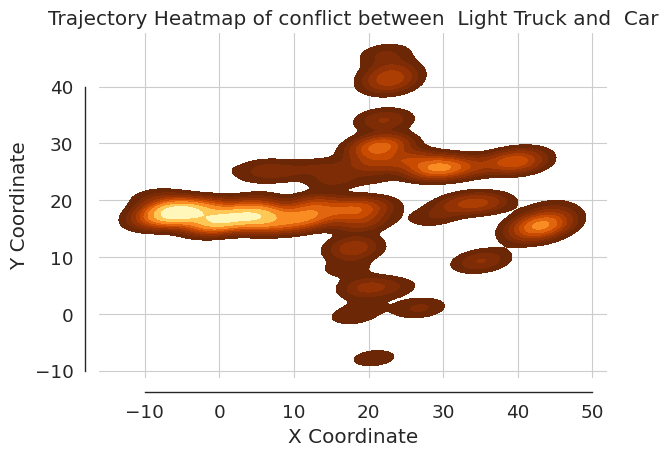

The conflict type, the main vehicle Light Truck, the subvehicle  Van. the total number is 51


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


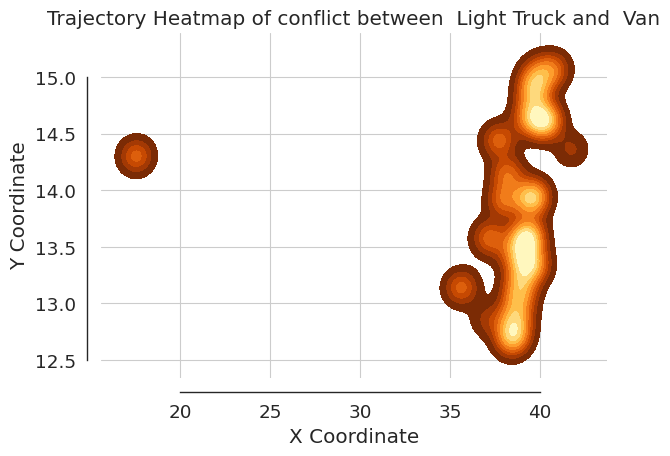

The conflict type, the main vehicle Light Truck, the subvehicle  Motorcycle. the total number is 102


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


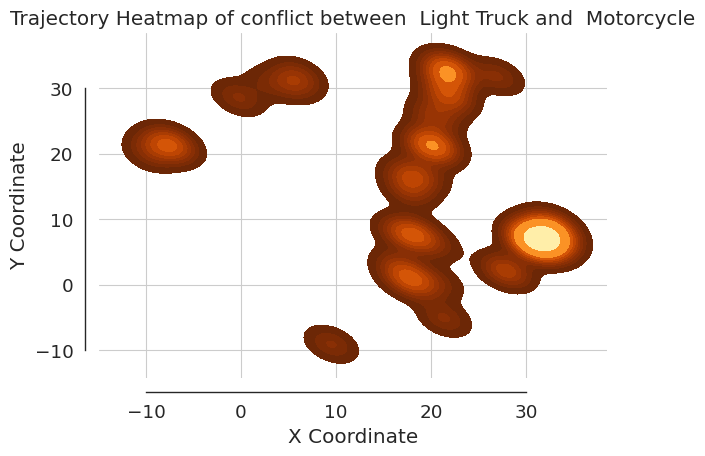

The conflict type, the main vehicle Light Truck, the subvehicle  Bus. the total number is 0


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


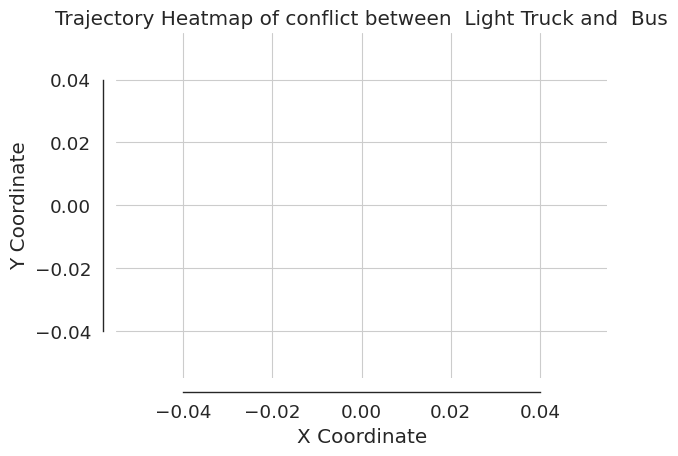

The conflict type, the main vehicle Light Truck, the subvehicle  Light Truck. the total number is 19


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


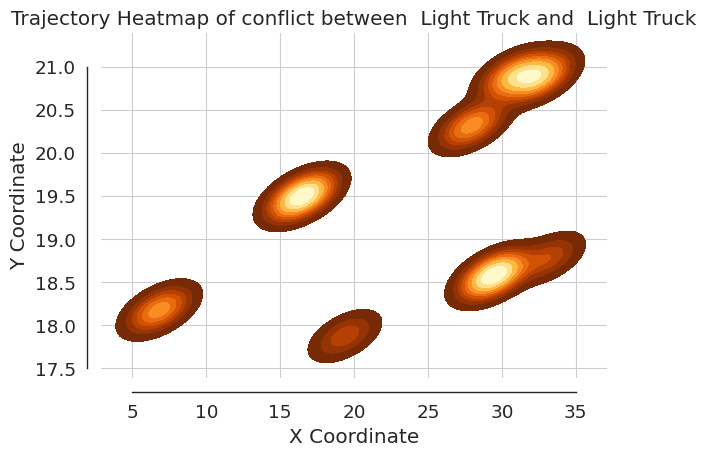

The conflict type, the main vehicle Light Truck, the subvehicle  Tuk-Tuk. the total number is 0


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


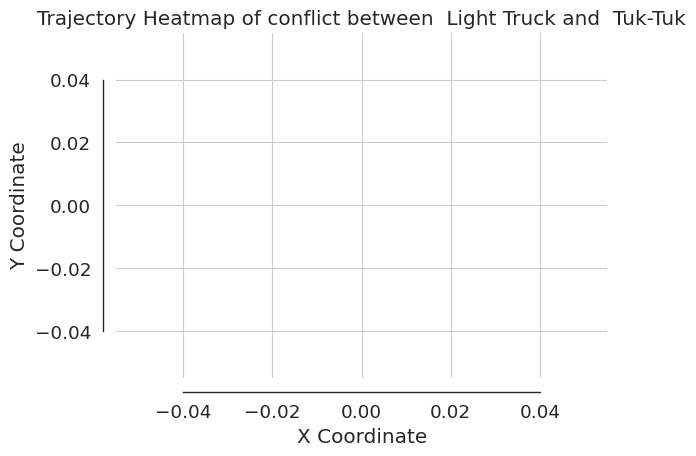

The conflict type, the main vehicle Tuk-Tuk, the subvehicle  Bicycle. the total number is 61


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


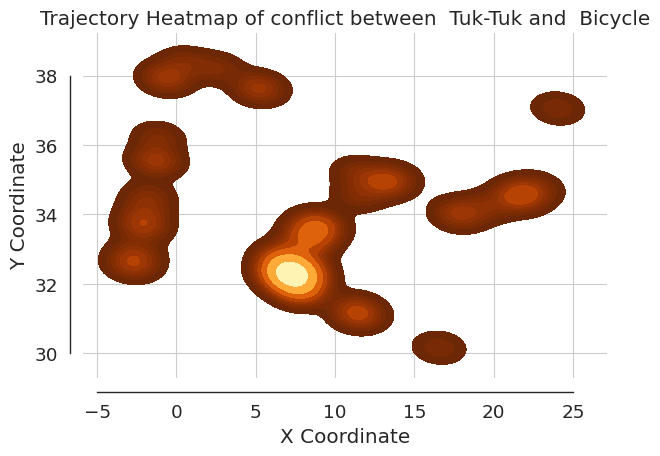

The conflict type, the main vehicle Tuk-Tuk, the subvehicle  Car. the total number is 233


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


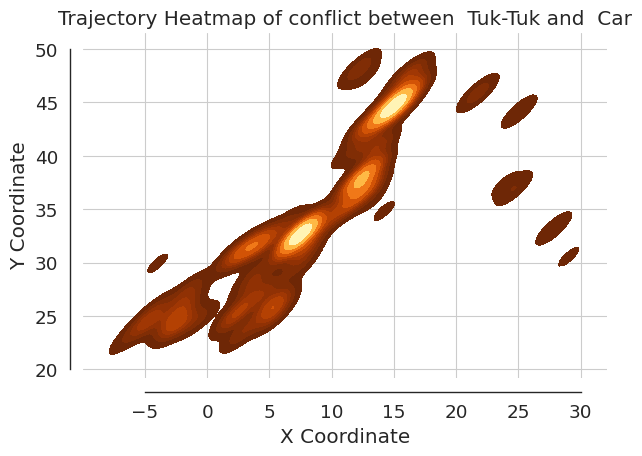

The conflict type, the main vehicle Tuk-Tuk, the subvehicle  Van. the total number is 0


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


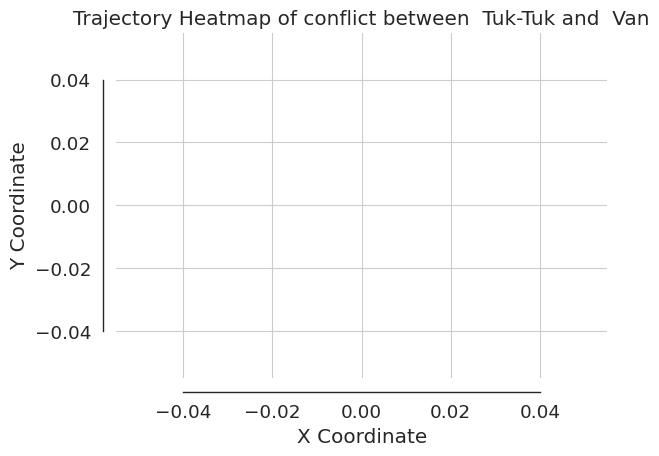

The conflict type, the main vehicle Tuk-Tuk, the subvehicle  Motorcycle. the total number is 7


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


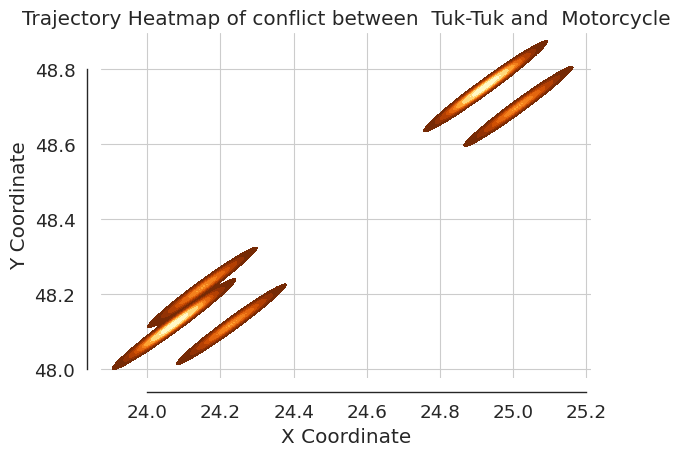

The conflict type, the main vehicle Tuk-Tuk, the subvehicle  Bus. the total number is 0


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


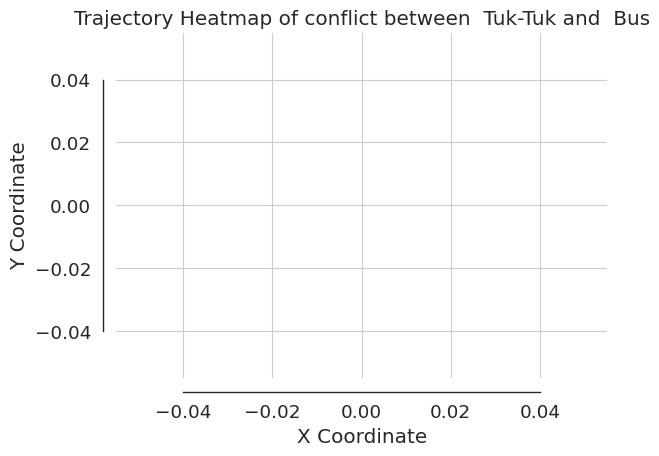

The conflict type, the main vehicle Tuk-Tuk, the subvehicle  Light Truck. the total number is 0


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


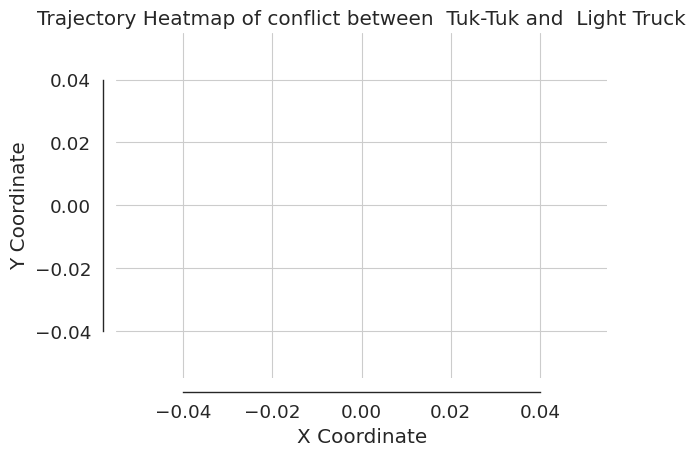

The conflict type, the main vehicle Tuk-Tuk, the subvehicle  Tuk-Tuk. the total number is 129


<ipython-input-40-e491a521af80>:26: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.15`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
<ipython-input-40-e491a521af80>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)


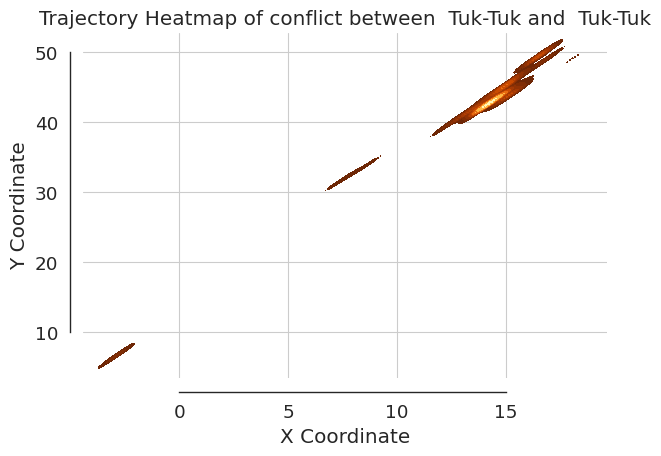

In [ ]:
# defining the libraries
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ks_2samp
%matplotlib inline

data_original =pet_df[pet_df['PET']<=5]

# classification of the conflict 
M_veh_type = data_original['m_vehicle_type'].unique()
for m_veh_type in M_veh_type:
    M_veh_pet = data_original[data_original['m_vehicle_type']==m_veh_type]
    for sub_veh_type in M_veh_type:
        M_veh_pet_sub = M_veh_pet[M_veh_pet['sub_vehicle_type'] ==sub_veh_type]
        data = M_veh_pet_sub[['cross_point_x','cross_point_y']]
        data = pd.DataFrame(data)
        # limited the edges Original_data = Original_data.drop(Original_data[Original_data.world_x <= -10].index)
        data = data.drop(data[data.cross_point_x <= -10].index)
        data = data.drop(data[data.cross_point_x >= 45].index)
        data = data.drop(data[data.cross_point_y <= -10].index)
        data = data.drop(data[data.cross_point_y >= 50].index)
        print('The conflict type, the main vehicle'+str(m_veh_type)+', the subvehicle '+str(sub_veh_type)+'. the total number is '+str(len(data)))
        # Create a 2D density plot using Seaborn's kdeplot function
        sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
        # Customize the plot
        sns.set_style('white')
        sns.despine(offset=10, trim=True)
        sns.set_context('paper', font_scale=1.5)
        # Add labels and title
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.title('Trajectory Heatmap of conflict between '+str(m_veh_type)+' and '+ str(sub_veh_type))
        plt.tight_layout()
        plt.grid()
        plt.show()

 ## ** Extract the conflict event from the trajectory conflict data!**
   ## First, classificatory /'klæsifikeitəri/ the conflict kinds based on the vehicle type;
   ## Second, classificatory the conflict based on the motion direction;
   ## Then,  

## 研究思路梳理 Sorting out the research idea

#### 提取车辆冲突风险事件过程数据，定义冲突过程影响时序变量。

**1.提取冲突风险事件。**

    a.定义什么是风险事件，PET值小于2秒，TTC值？
    b.提取PET值小于2的所有轨迹点，对应的车辆ID和潜在碰撞车辆ID,所对应的轨迹点和交通状态数据；
    C.提取冲突事件演化过程的轨迹数据和车辆风险演化过程值；(提取过程中应该选择连续的多个点，并非一个点)
    d.分析风险演化对应的运动状态量的变化。
    e.按照碰撞车辆类型进行状态事件链的集计。
**2.定义碰撞冲突过程影响变量。**

    a.车辆速度变化量、加速度变化量、急动度、曲率变化量、风险值（使用集计量还是时序变量需要斟酌）
    b.建立线性回归模型来确定基础影响变量（静态分析模型）；
    c.定义Dynamic Bayesian Network模型所需的数据类型；
**3.基于Dynamic Bayseian Network and causality inference modeling 分析动态演化过程，分析关键冲突点和最长风险预测的对比。**

    a.因素之间的因果关系分析；
    b.基于因果分析模型对风险预测的准确性分析；
    c.如何验证模型，需要进一步思考。

In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [ ]:
# def Detect_interacte_object(Main_car_data):
#     # define the interact object of the main
#     'Type_1:the minimum pet object'
#     Min_PET = min(Main_car_data['PET'])
#     Risk_frame_time_Matrix = Main_car_data.loc[Main_car_data['PET']==Min_PET]
#     Interacte_object_type1 = Risk_frame_time_Matrix['sub_vehicle_id']
#     print('--------------------------------------------------------')
#     print(Interacte_object_type1)
#     'Type_2:the most often vehicle'
#     Interacte_object_type_list = Main_car_data['sub_vehicle_id'].value_counts()
#     print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
#     print(Interacte_object_type_list)
#     'Type_3:the minimun mean of pet'
#     sub_vehicle_id = np.unique(Main_car_data['sub_vehicle_id'])
#     AM = ['vehicle_id','mean_pet']
#     df_all_vehicle = pd.DataFrame(columns = AM)
#     Interacte_object_list = []
#     for Veh_id_id in range(0,len(sub_vehicle_id),1):
#         vehicle_ID = sub_vehicle_id[Veh_id_id]
#         '逐车计算pet均值'
#         pet_vehicle_ID = Main_car_data[Main_car_data['sub_vehicle_id']==vehicle_ID]
#         vehicle_id_pet = np.mean(pet_vehicle_ID['PET'])
#         print(vehicle_ID,vehicle_id_pet)
#         df_all_vehicle['vehicle_id'] = vehicle_ID
#         df_all_vehicle['mean_pet'] = vehicle_id_pet
#     min_pet_vehicleID = min(df_all_vehicle['mean_pet'])
#     Min_pet_interact_traj = df_all_vehicle[df_all_vehicle['mean_pet']==min_pet_vehicleID]
#     Interacte_object_type3 = Min_pet_interact_traj['vehicle_id']
#     return Interacte_object_type1,Interacte_object_type2,Interacte_object_type2

def Detect_Risk_frame(PET_M_CAR):
     # search the minimum frame time
    'This function is detecte the Risk_time of the motion process'
    Min_PET = min(PET_M_CAR['PET'])
    Risk_frame_time_Matrix = PET_M_CAR.loc[PET_M_CAR['PET']==Min_PET]
    Risk_frame_time = Risk_frame_time_Matrix['m_frame_time']
    'Diagnose the Minimum PET value is true'
    Risk_frame_time_befor = Risk_frame_time.values-0.04*10
    Risk_frame_time_after = Risk_frame_time.values+0.04*10
    'Extracte the trajectory between the risk_frame_time_before and after 10 seconds'
    Near_conflict_processor = PET_M_CAR.loc[(PET_M_CAR['m_frame_time']>=Risk_frame_time_befor[0])&(PET_M_CAR['m_frame_time']<=Risk_frame_time_after[0])]
    "calculate the mean and the std of conflict PET"
    Mean_pet = np.mean(Near_conflict_processor['PET'])
    Std_pet = np.std(Near_conflict_processor['PET'])
    Object_of_conflict = Risk_frame_time_Matrix['sub_vehicle_id']
    # print('The car’s lagest risk value is'+str(Min_PET)+';'+'Mean Risk is'+str(Mean_pet)+';'+'The SD of the pet is'+ str(Std_pet)+'.')
    'The conflict point between the two wvehicle'
    conflict_point = Risk_frame_time_Matrix[['cross_point_x','cross_point_y']]
    return Risk_frame_time,Min_PET,Mean_pet,Std_pet,conflict_point

def Detect_Risk_subcar(PET_M_CAR):
     # search the minimum frame time
    'This function is detecte the Risk_time of the motion process'
    Min_PET = min(PET_M_CAR['PET'])
    Risk_frame_time_Matrix = PET_M_CAR.loc[PET_M_CAR['PET']==Min_PET]
    Object_of_conflict = Risk_frame_time_Matrix['sub_vehicle_id']
    return Object_of_conflict

def Event_extract(PET_data,Risk_moment,Time_gap_befor,Time_gap_after):
    # Extract the state befor and after the minimun PET 2 seconds from the car_conflict_pet
    'The PET_data is the orginal conflict data,Risk_moment is the memont with the minimum value of the PET,Time_gap is the time befor and after the minimum time'
    Time_list = pd.DataFrame(PET_data['m_frame_time'])
    Start_conflict_frame = (Risk_moment - Time_gap_befor)
    if len(Time_list.values)>0:
      if min(Time_list.values)>=Start_conflict_frame:
          Start_extract_frame = min(Time_list.values)
      else:
          Start_extract_frame = Start_conflict_frame
      End_conflict_frame = Risk_moment + Time_gap_after
      if max(Time_list.values) < End_conflict_frame:
          End_extract_frame = max(Time_list.values)
      else:
          End_extract_frame = End_conflict_frame
      # choice the trajectory 
      min_pet_motion = PET_data.loc[(PET_data['m_frame_time']>=Start_extract_frame[0])&(PET_data['m_frame_time']<=End_extract_frame[0])]
    else:
      min_pet_motion = []
    return min_pet_motion 

The conflict between vehicle  8 and the vehicle   [26]


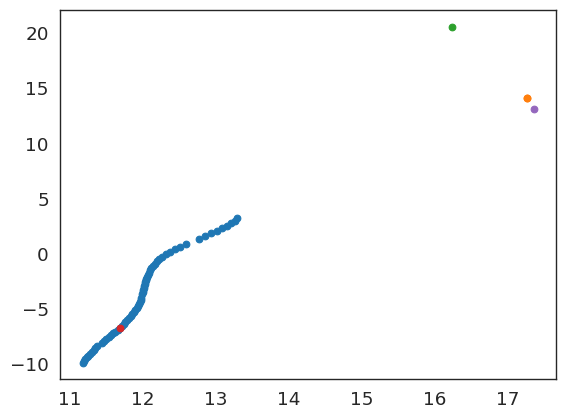

The conflict between vehicle  18 and the vehicle   [16]


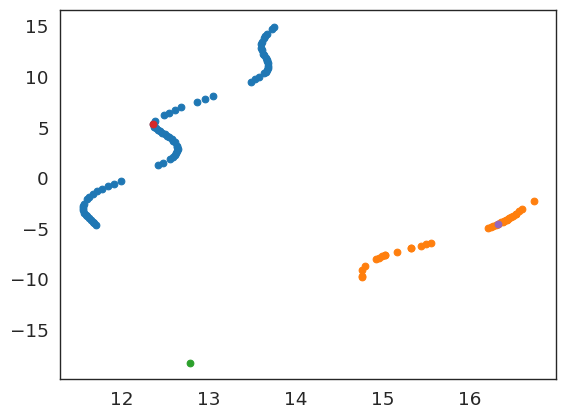

The conflict between vehicle  19 and the vehicle   [3]


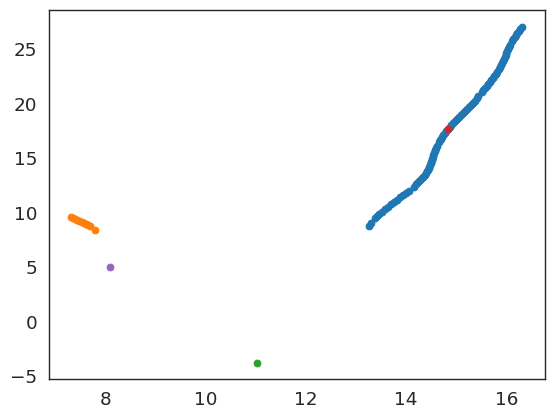

The conflict between vehicle  50 and the vehicle   [11]


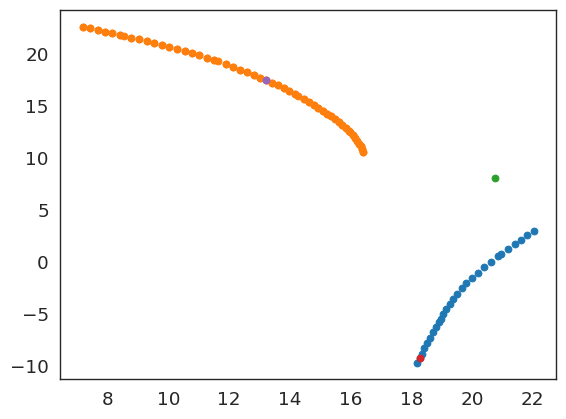

The conflict between vehicle  85 and the vehicle   [94]


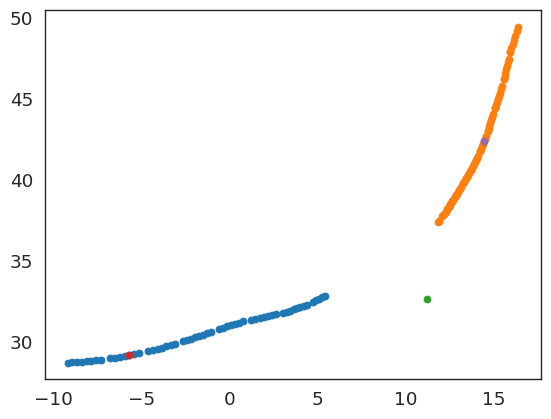

The conflict between vehicle  94 and the vehicle   [85]


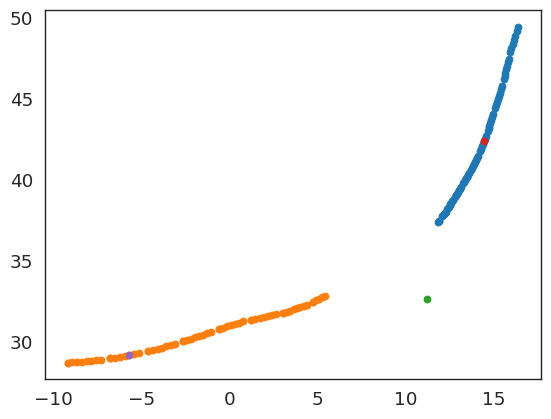

The conflict between vehicle  138 and the vehicle   [140]


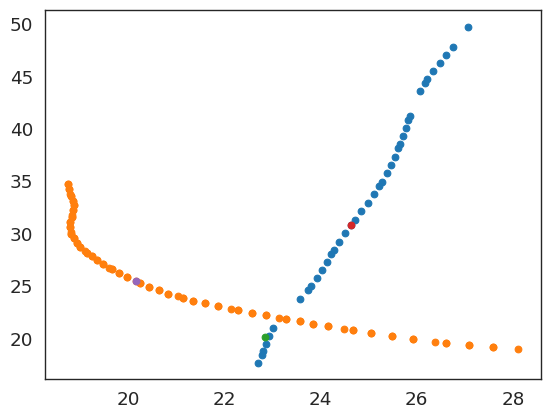

The conflict between vehicle  148 and the vehicle   [161]


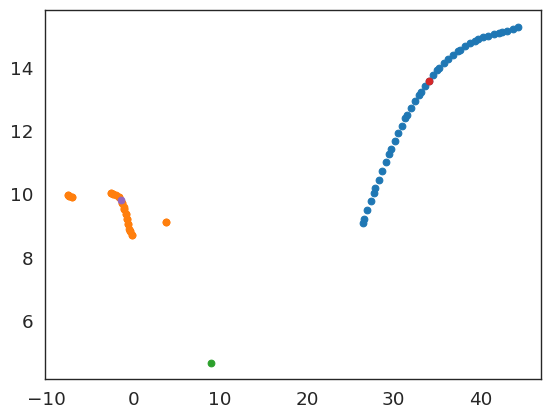

The conflict between vehicle  112 and the vehicle   [161]


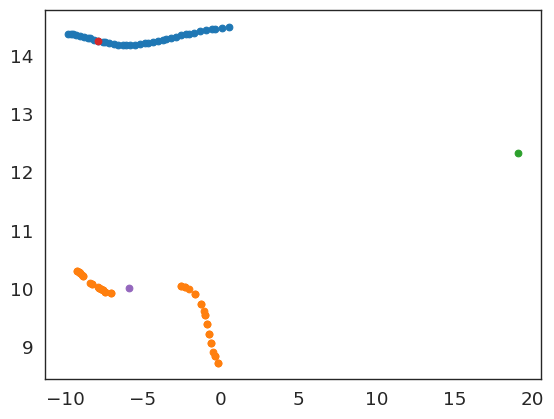

The conflict between vehicle  197 and the vehicle   [128]


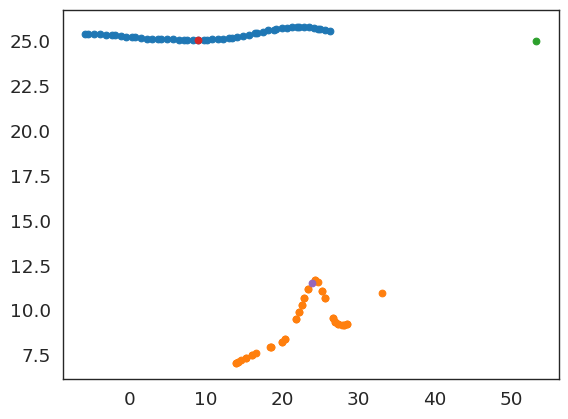

The conflict between vehicle  202 and the vehicle   [205]


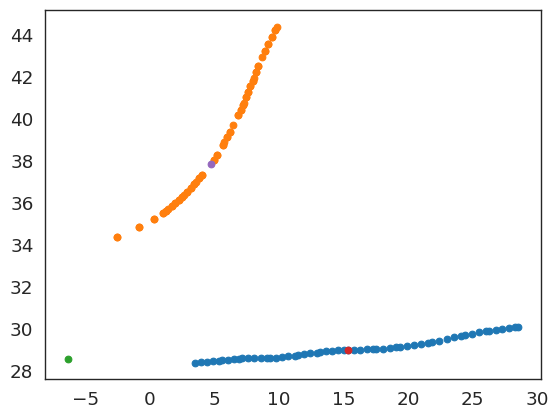

The conflict between vehicle  17 and the vehicle   [128]


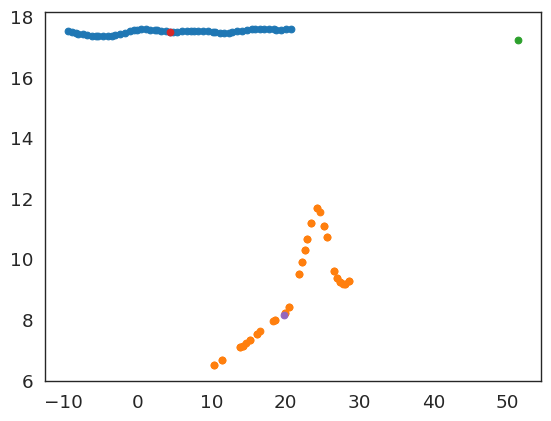

The conflict between vehicle  153 and the vehicle   [223]


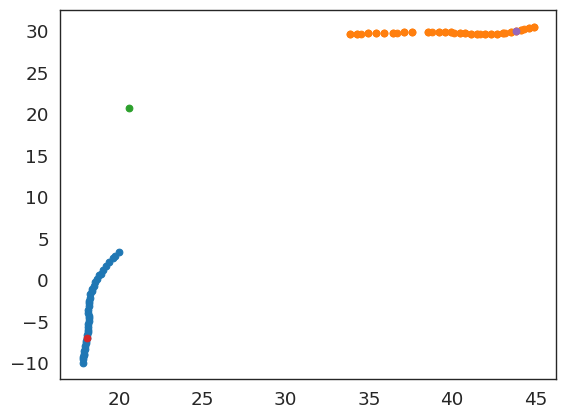

The conflict between vehicle  223 and the vehicle   [153]


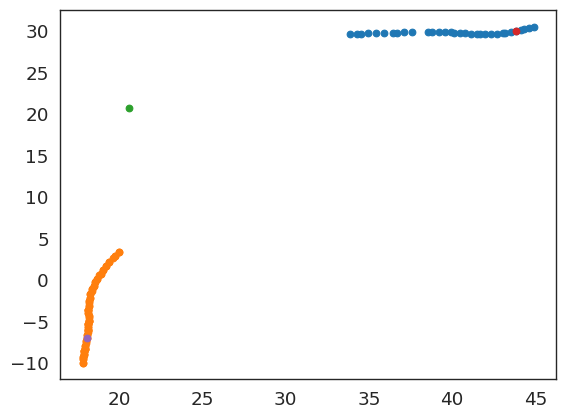

The conflict between vehicle  246 and the vehicle   [252]


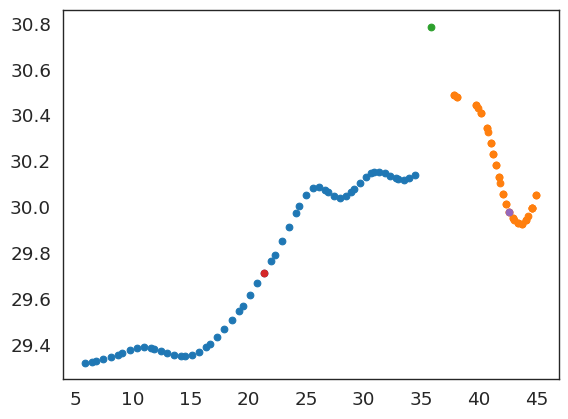

The conflict between vehicle  266 and the vehicle   [280]


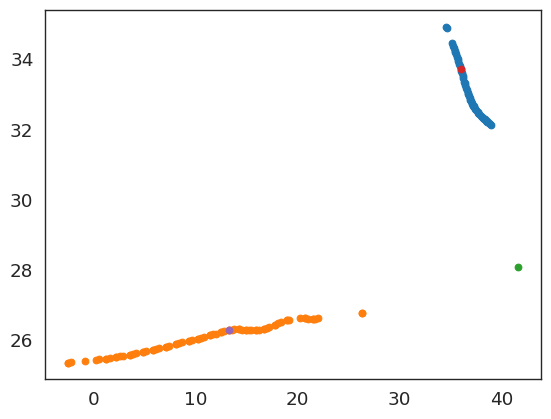

The conflict between vehicle  280 and the vehicle   [281]


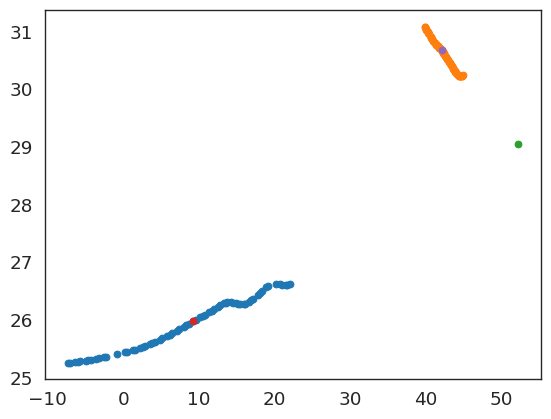

The conflict between vehicle  283 and the vehicle   [252]


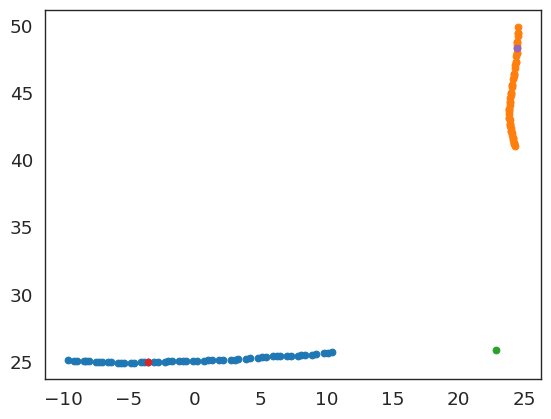

The conflict between vehicle  290 and the vehicle   [281]


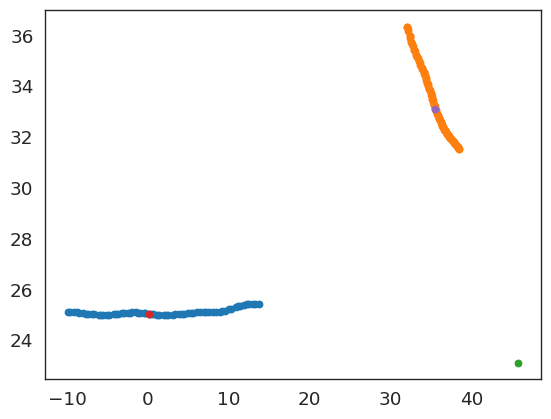

The conflict between vehicle  299 and the vehicle   [303]


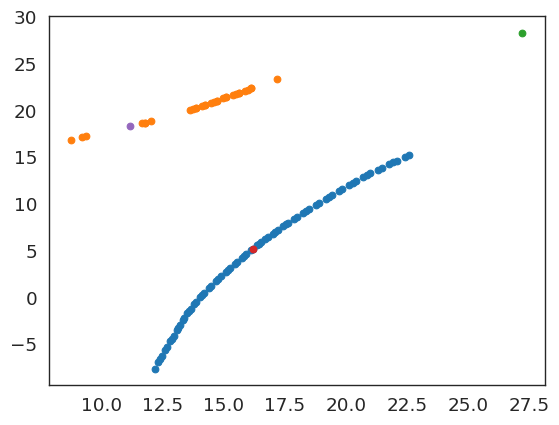

The conflict between vehicle  47 and the vehicle   [245]


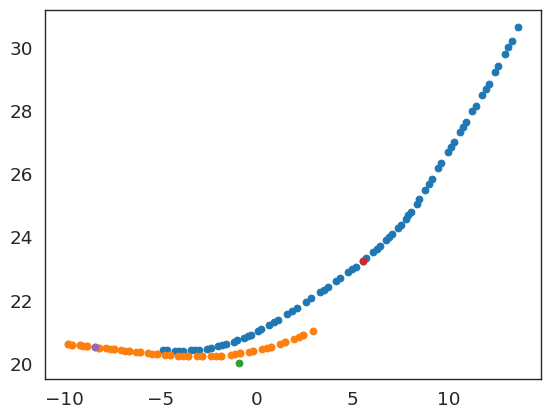

The conflict between vehicle  245 and the vehicle   [47]


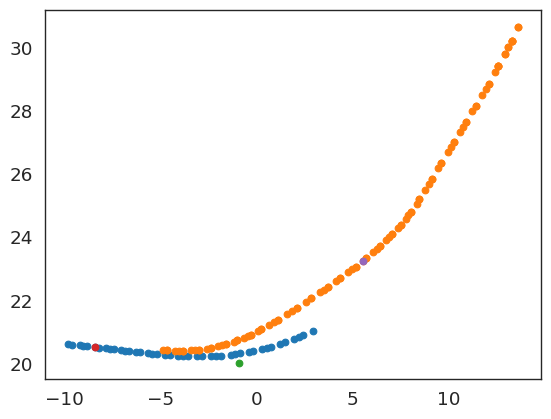

The conflict between vehicle  80 and the vehicle   [245]


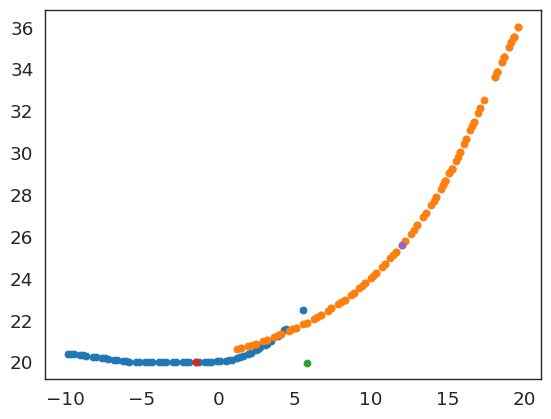

The conflict between vehicle  315 and the vehicle   [317]


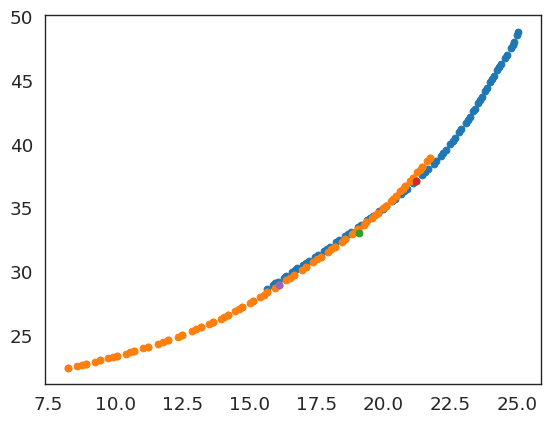

The conflict between vehicle  317 and the vehicle   [315]


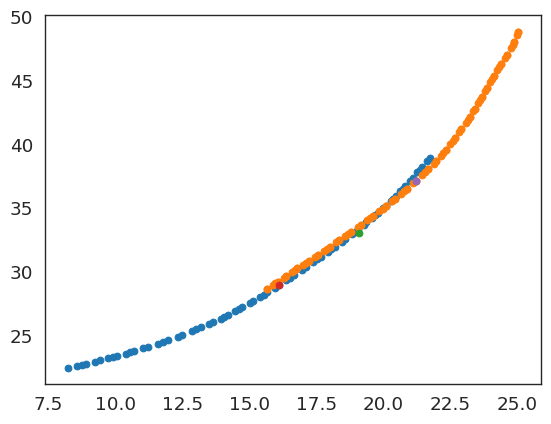

The conflict between vehicle  324 and the vehicle   [317]


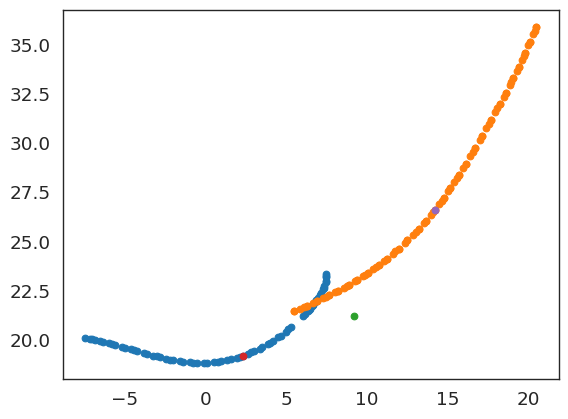

The conflict between vehicle  328 and the vehicle   [326]


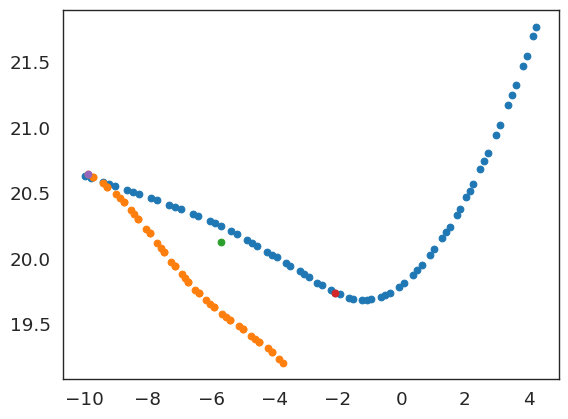

The conflict between vehicle  337 and the vehicle   [335]


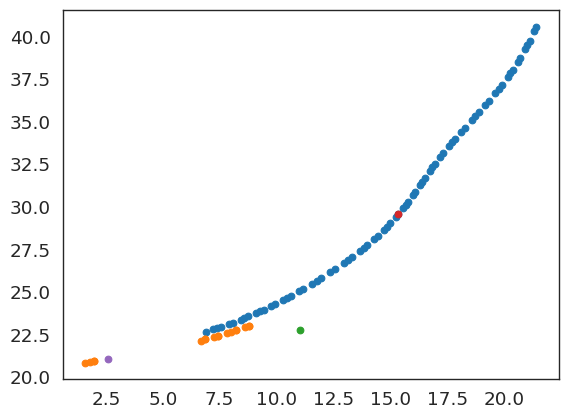

The conflict between vehicle  162 and the vehicle   [372]


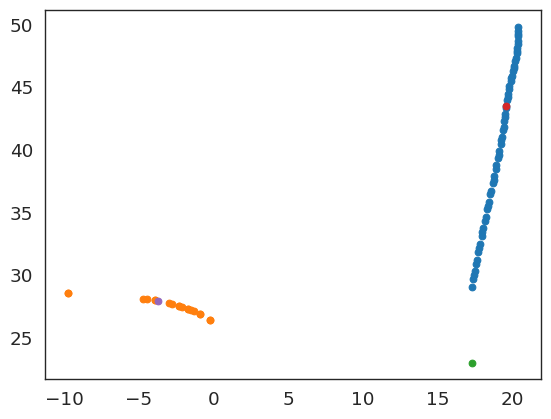

The conflict between vehicle  383 and the vehicle   [411]


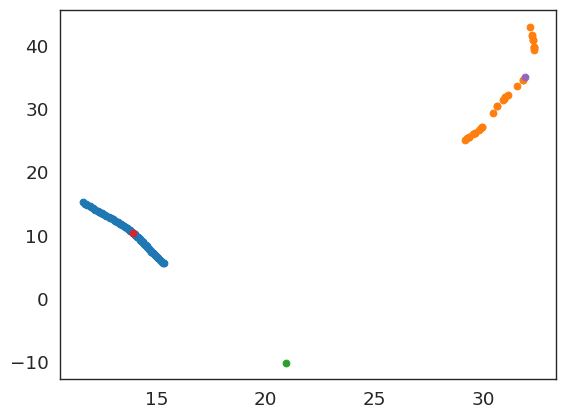

The conflict between vehicle  409 and the vehicle   [408]


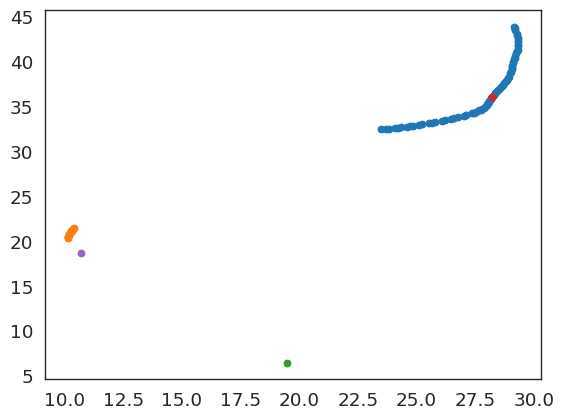

The conflict between vehicle  418 and the vehicle   [441]


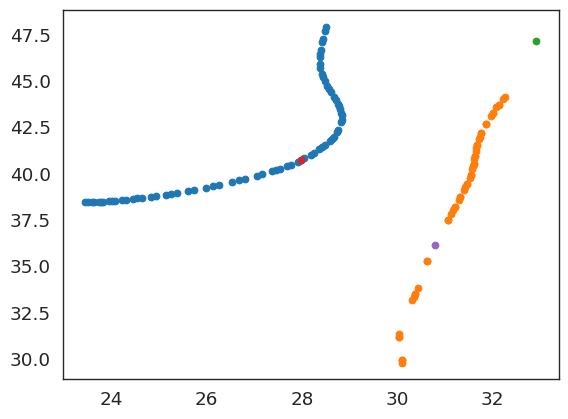

The conflict between vehicle  417 and the vehicle   [383]


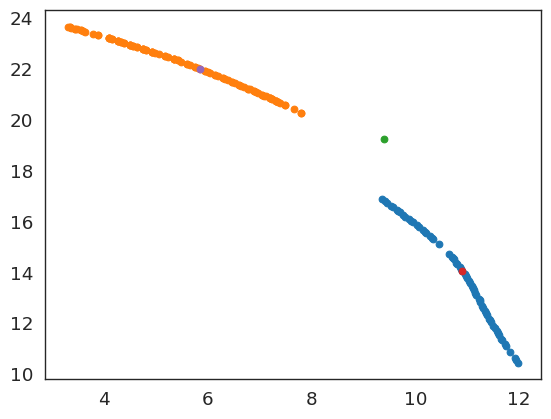

The conflict between vehicle  429 and the vehicle   [441]


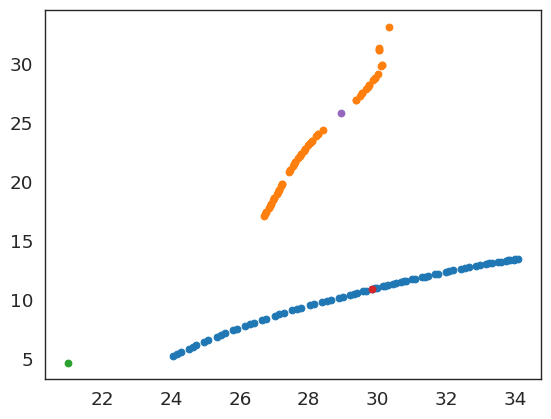

The conflict between vehicle  431 and the vehicle   [433]


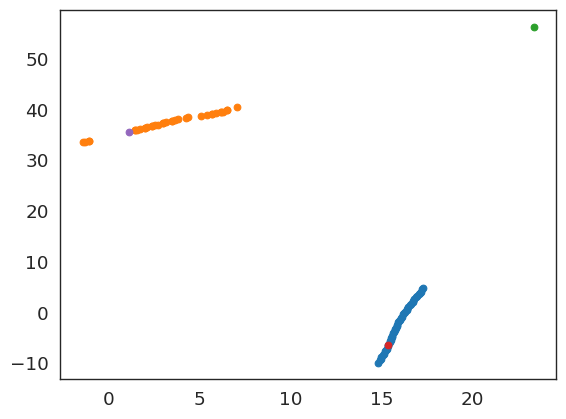

The conflict between vehicle  427 and the vehicle   [444]


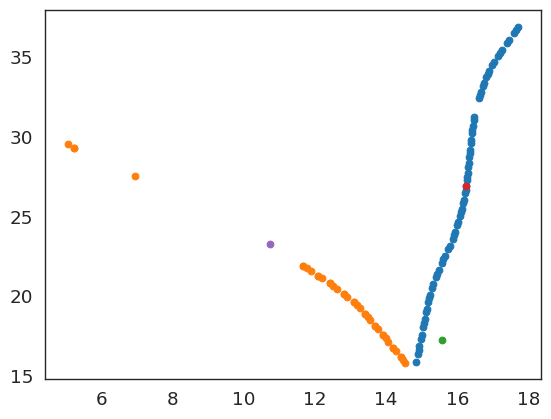

The conflict between vehicle  450 and the vehicle   [460]


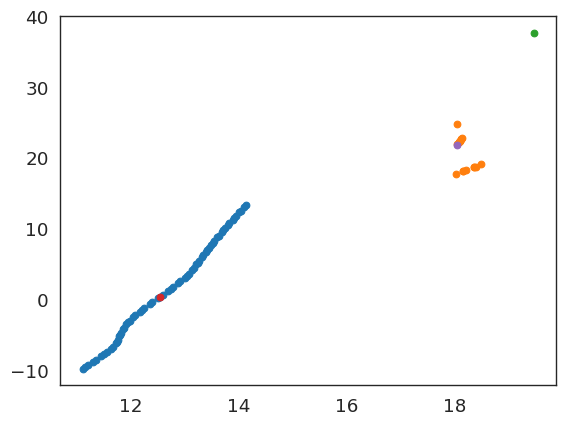

The conflict between vehicle  467 and the vehicle   [464]


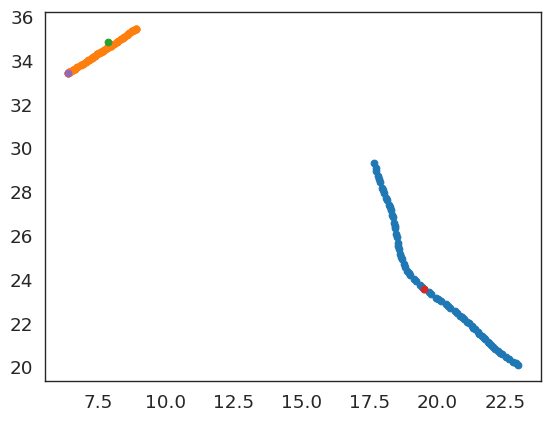

The conflict between vehicle  463 and the vehicle   [468]


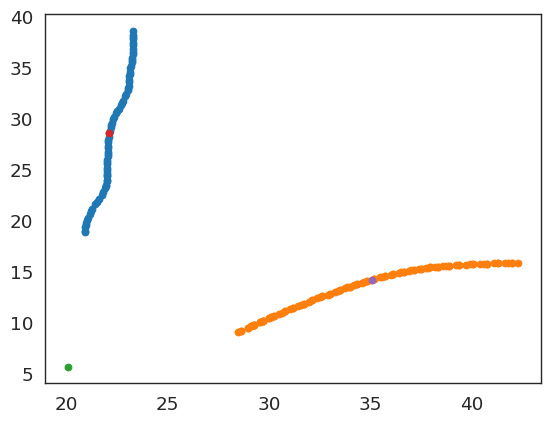

The conflict between vehicle  468 and the vehicle   [463]


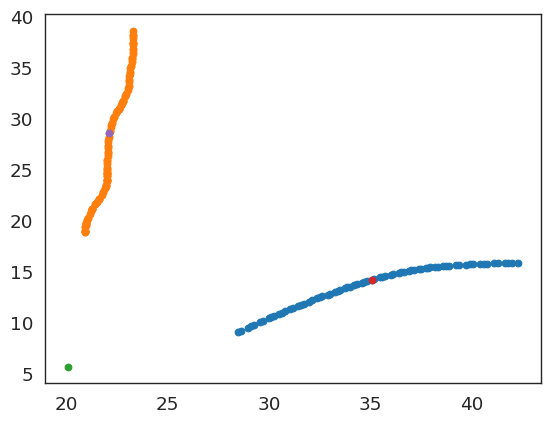

The conflict between vehicle  470 and the vehicle   [506]


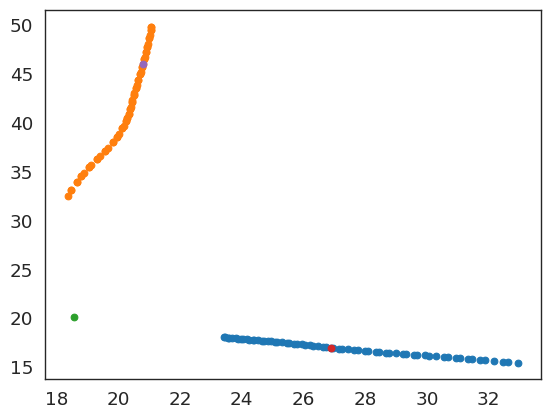

The conflict between vehicle  471 and the vehicle   [479]


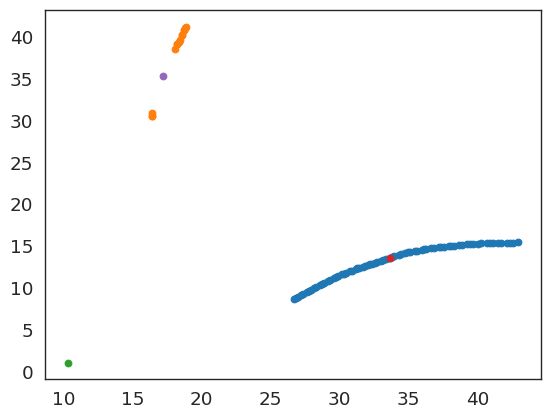

The conflict between vehicle  490 and the vehicle   [479]


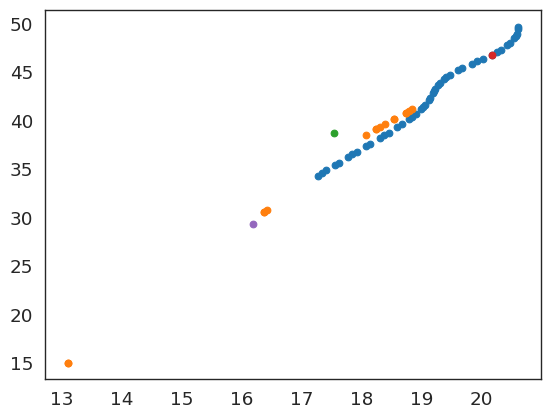

The conflict between vehicle  506 and the vehicle   [470]


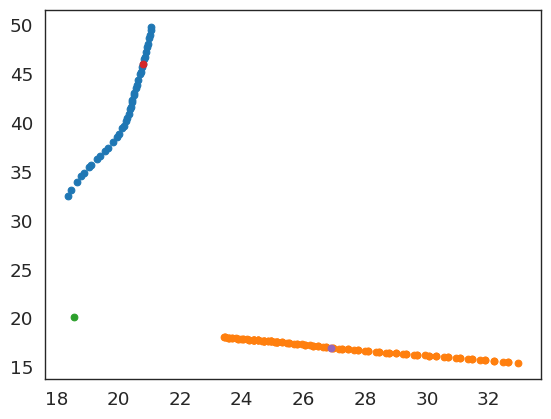

The conflict between vehicle  511 and the vehicle   [464]


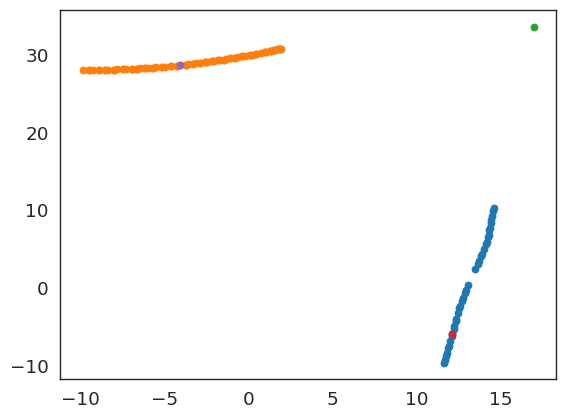

The conflict between vehicle  515 and the vehicle   [529]


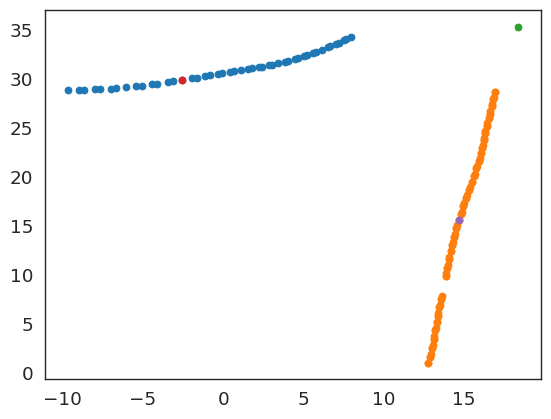

The conflict between vehicle  545 and the vehicle   [536]


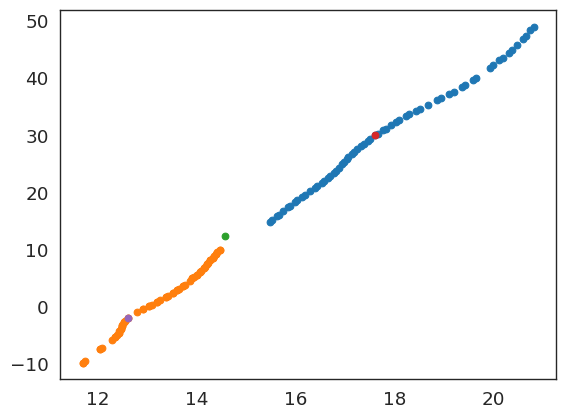

The conflict between vehicle  333 and the vehicle   [601]


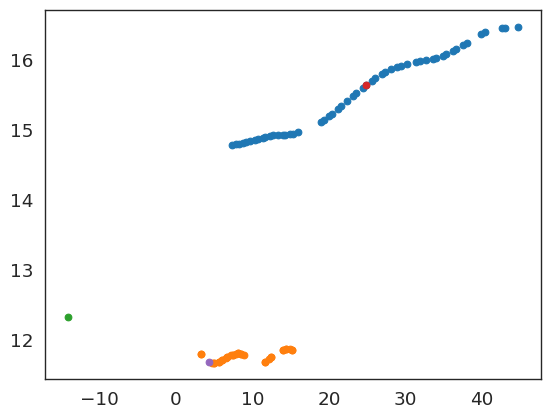

The conflict between vehicle  613 and the vehicle   [637]


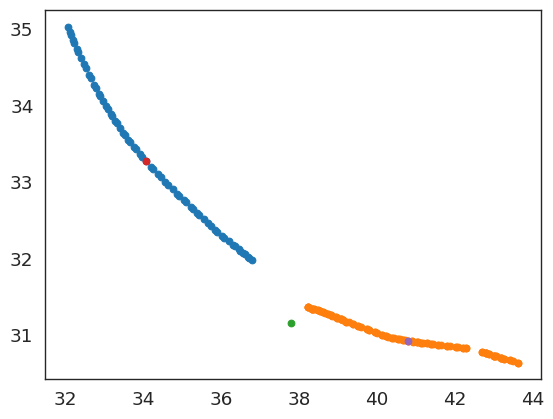

The conflict between vehicle  634 and the vehicle   [621]


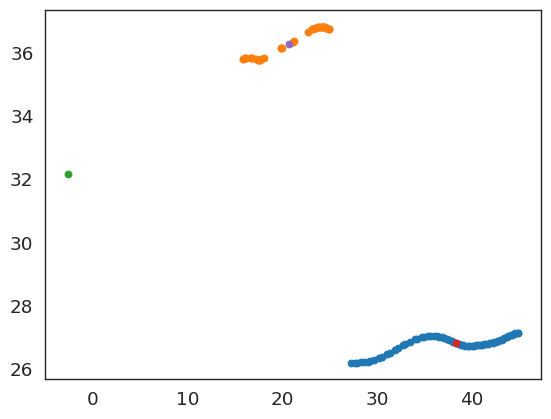

The conflict between vehicle  637 and the vehicle   [613]


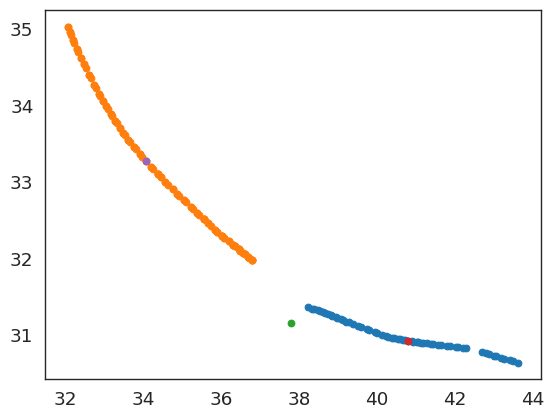

The conflict between vehicle  648 and the vehicle   [643]


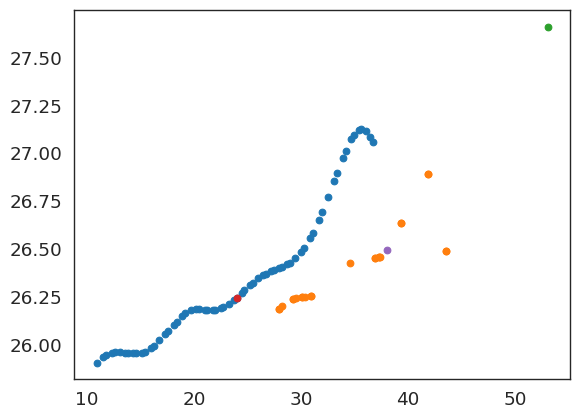

The conflict between vehicle  632 and the vehicle   [626]


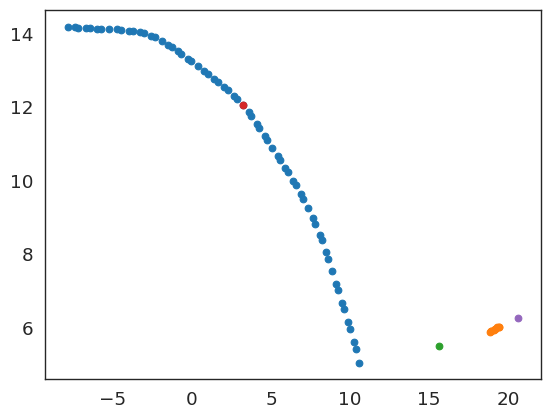

The conflict between vehicle  674 and the vehicle   [691]


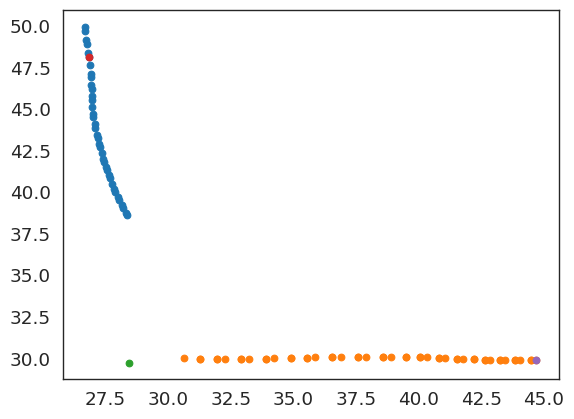

The conflict between vehicle  680 and the vehicle   [684]


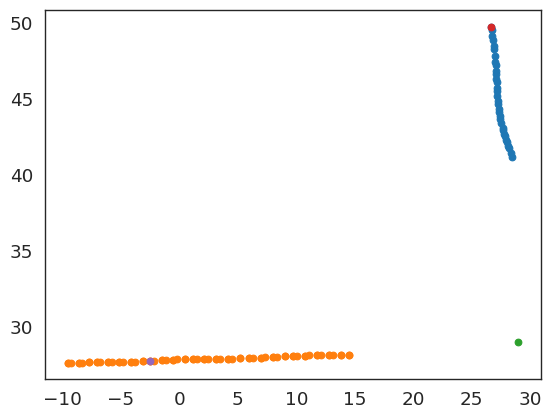

The conflict between vehicle  671 and the vehicle   [676]


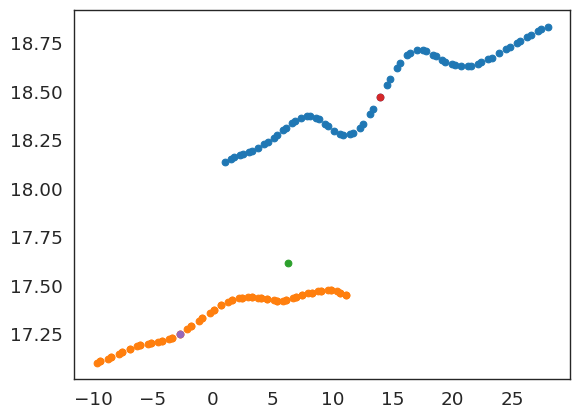

The conflict between vehicle  691 and the vehicle   [674]


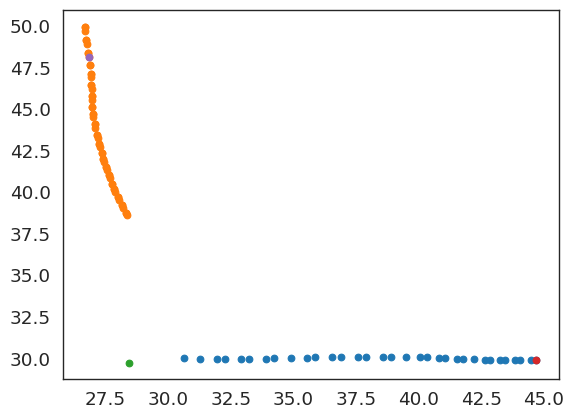

The conflict between vehicle  681 and the vehicle   [688]


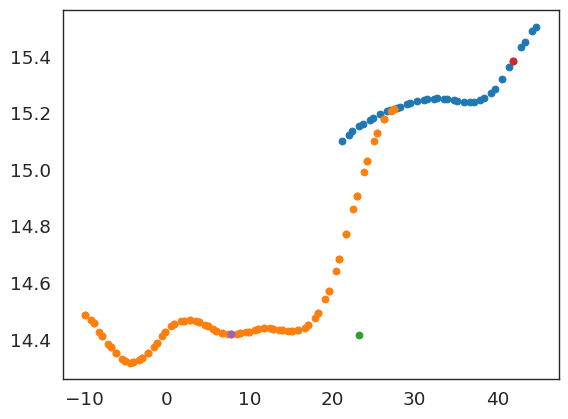

The conflict between vehicle  699 and the vehicle   [702]


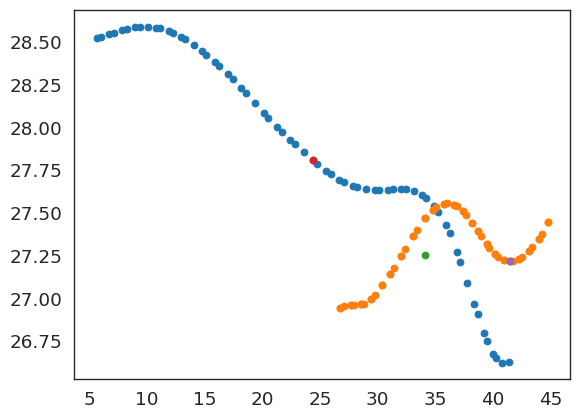

The conflict between vehicle  700 and the vehicle   [705]


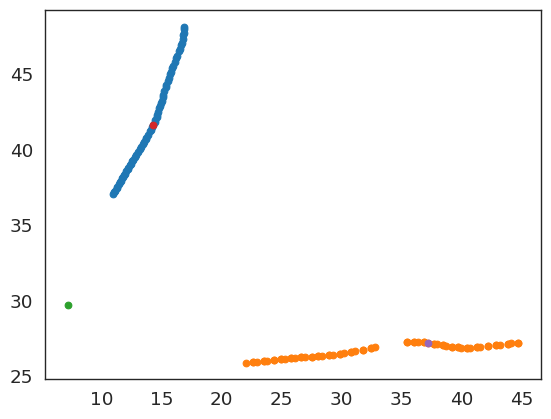

The conflict between vehicle  720 and the vehicle   [454]


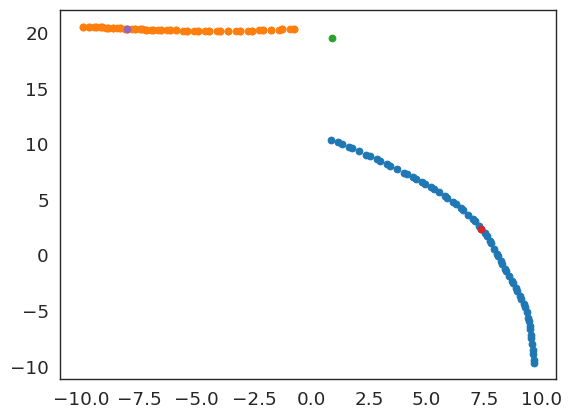

The conflict between vehicle  423 and the vehicle   [454]


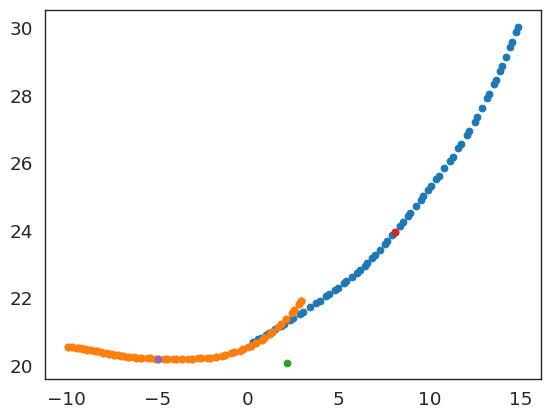

The conflict between vehicle  454 and the vehicle   [423]


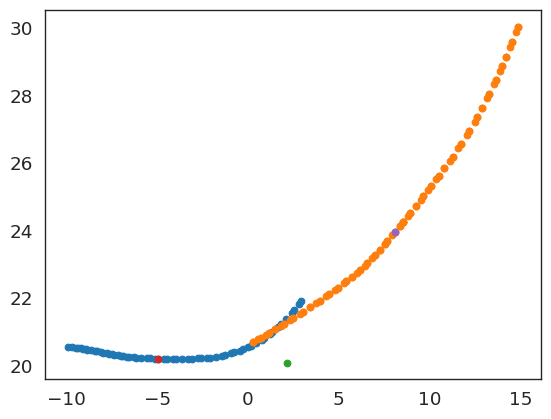

The conflict between vehicle  689 and the vehicle   [735]


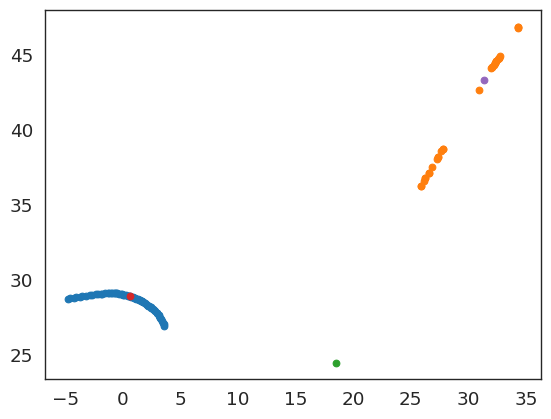

The conflict between vehicle  711 and the vehicle   [732]


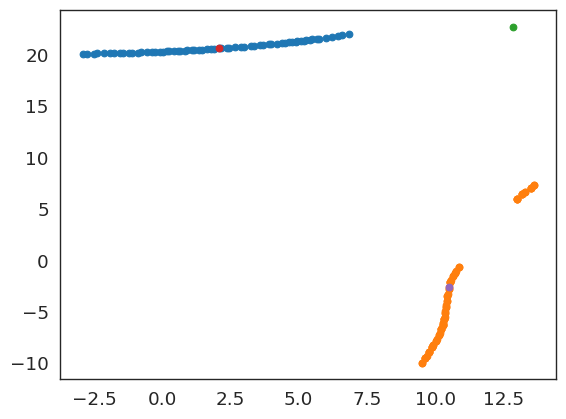

The conflict between vehicle  738 and the vehicle   [718]


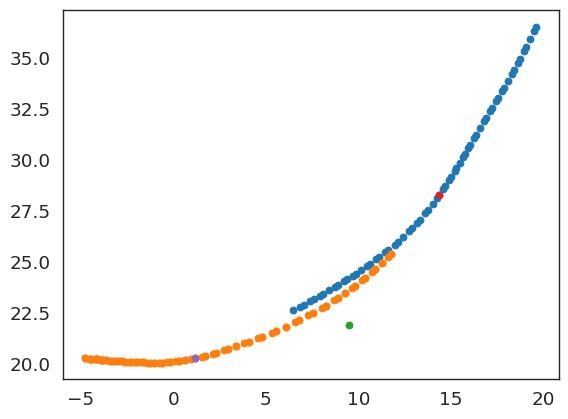

The conflict between vehicle  718 and the vehicle   [738]


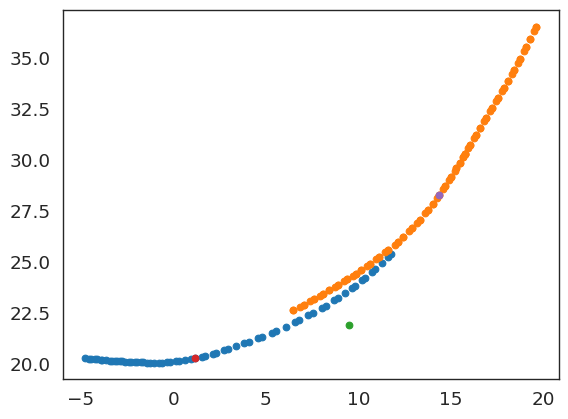

The conflict between vehicle  750 and the vehicle   [761]


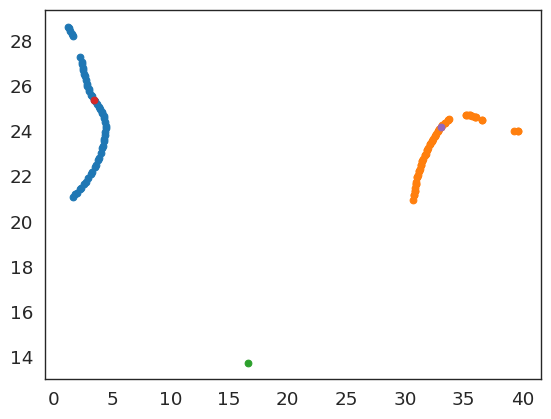

The conflict between vehicle  746 and the vehicle   [752]


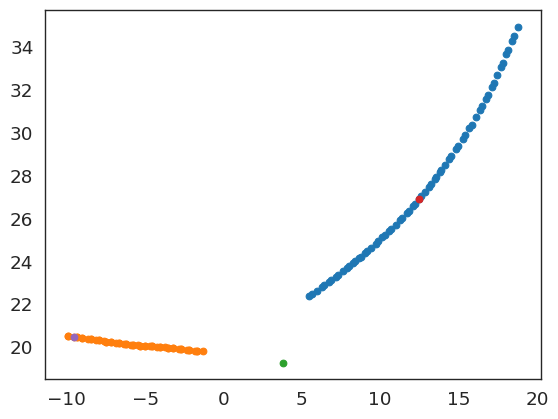

The conflict between vehicle  759 and the vehicle   [764]


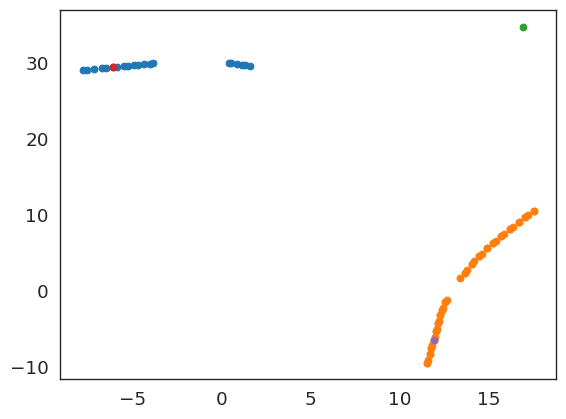

The conflict between vehicle  764 and the vehicle   [768]


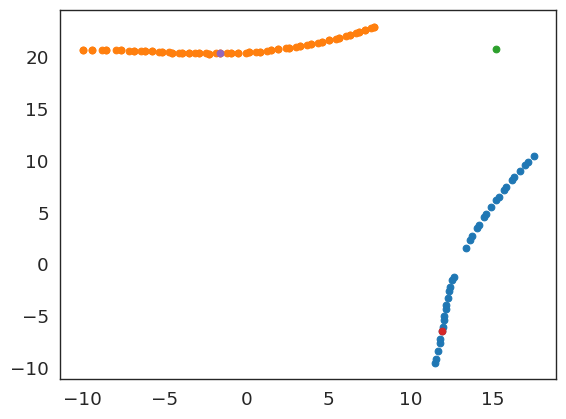

The conflict between vehicle  752 and the vehicle   [746]


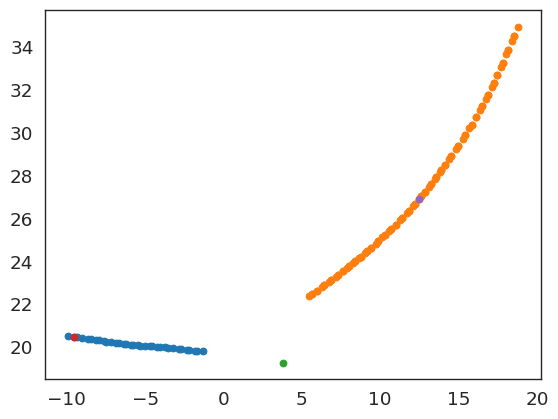

The conflict between vehicle  783 and the vehicle   [787]


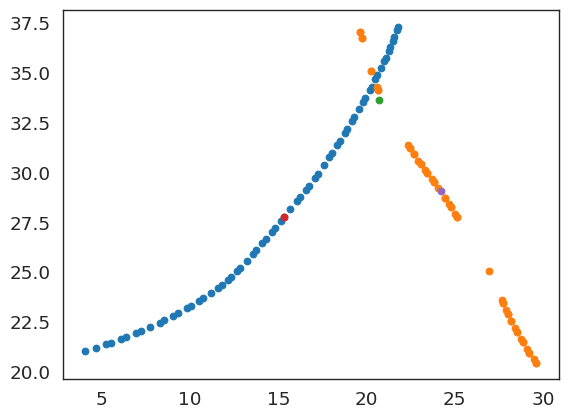

The conflict between vehicle  591 and the vehicle   [803]


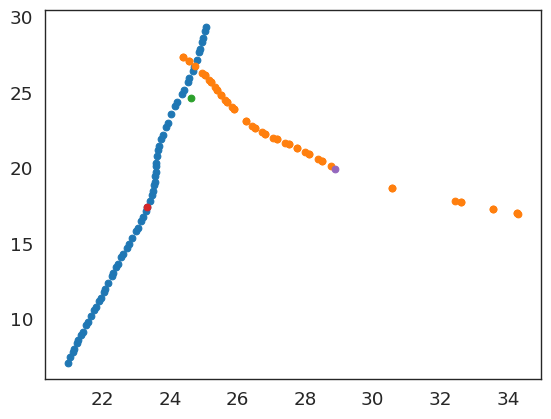

The conflict between vehicle  817 and the vehicle   [823]


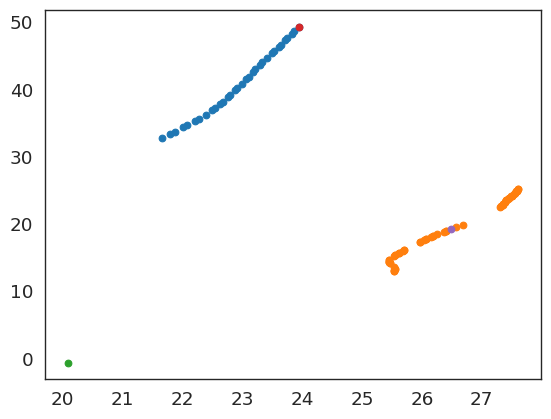

The conflict between vehicle  839 and the vehicle   [864]


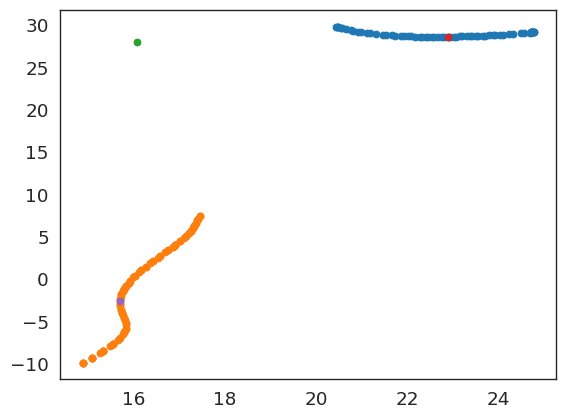

The conflict between vehicle  816 and the vehicle   [814]


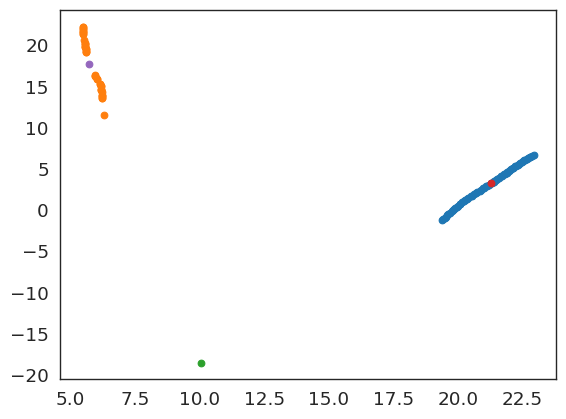

The conflict between vehicle  831 and the vehicle   [850]


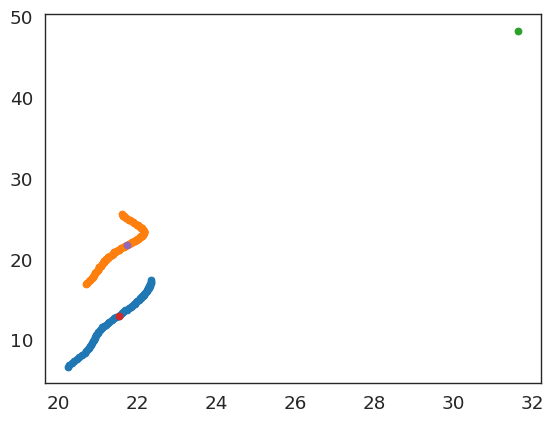

The conflict between vehicle  867 and the vehicle   [868]


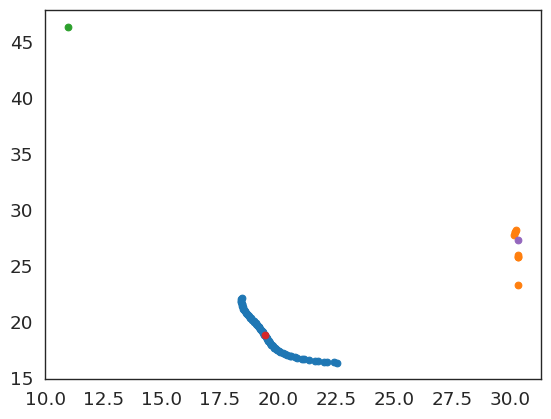

The conflict between vehicle  849 and the vehicle   [894]


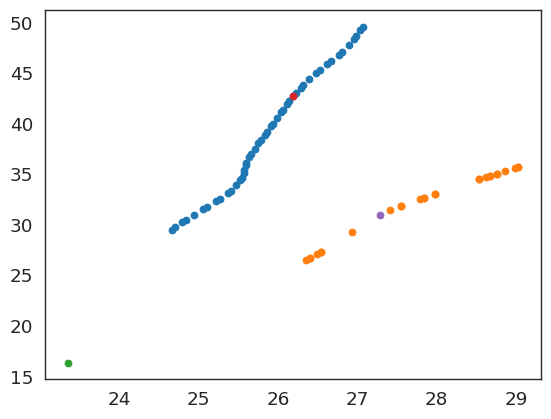

The conflict between vehicle  898 and the vehicle   [904]


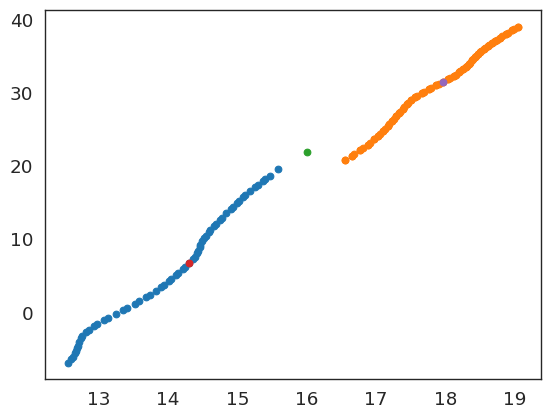

The conflict between vehicle  902 and the vehicle   [898]


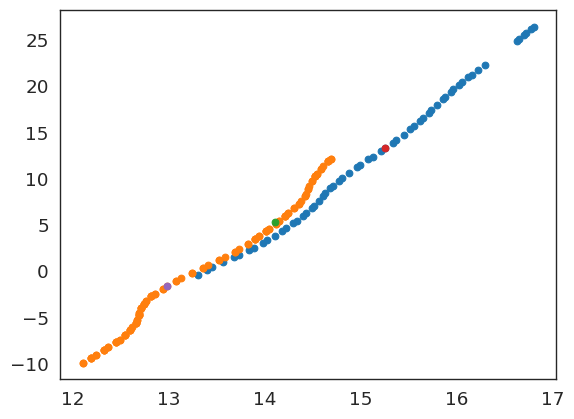

The conflict between vehicle  938 and the vehicle   [939]


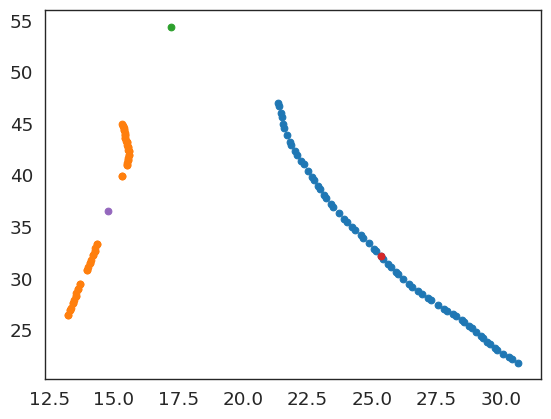

The conflict between vehicle  932 and the vehicle   [957]


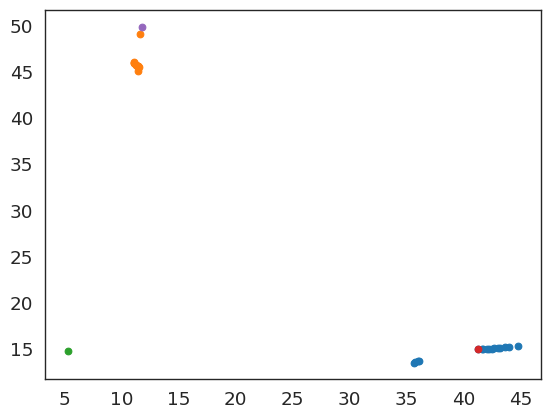

The conflict between vehicle  927 and the vehicle   [916]


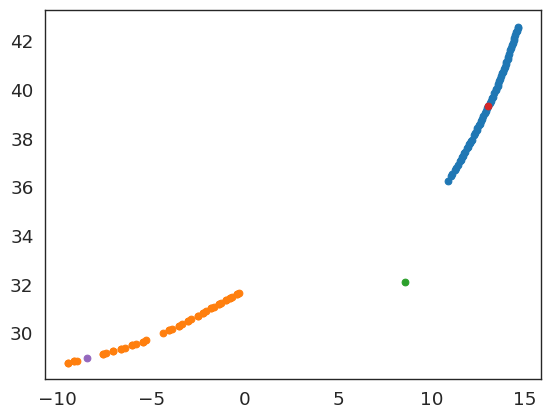

The conflict between vehicle  952 and the vehicle   [945]


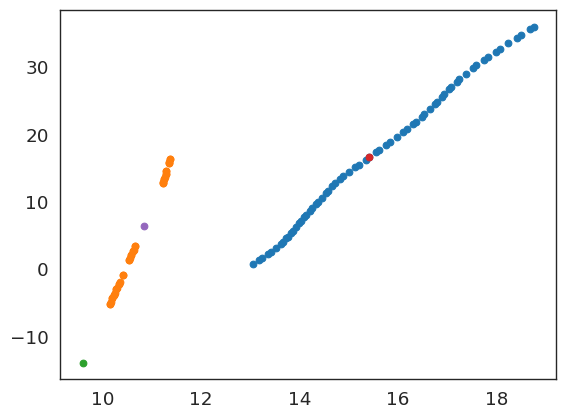

The conflict between vehicle  951 and the vehicle   [927]


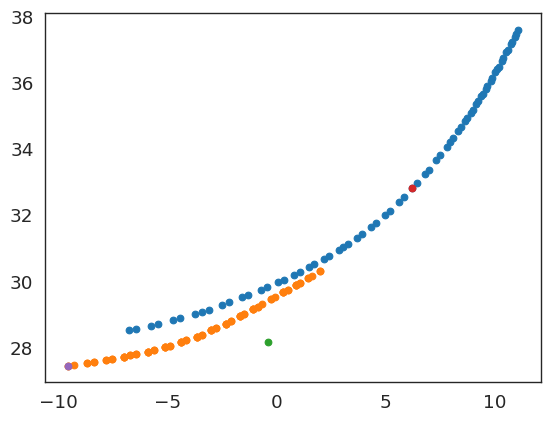

The conflict between vehicle  955 and the vehicle   [956]


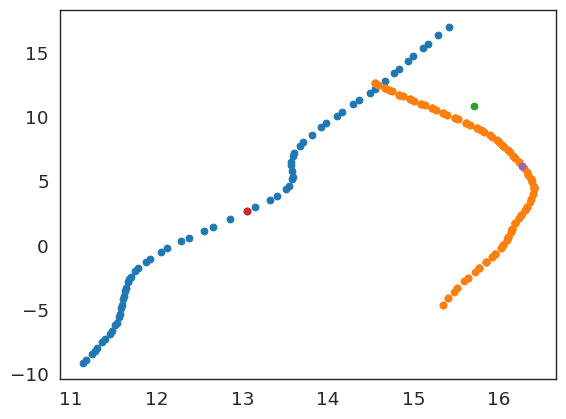

The conflict between vehicle  956 and the vehicle   [959]


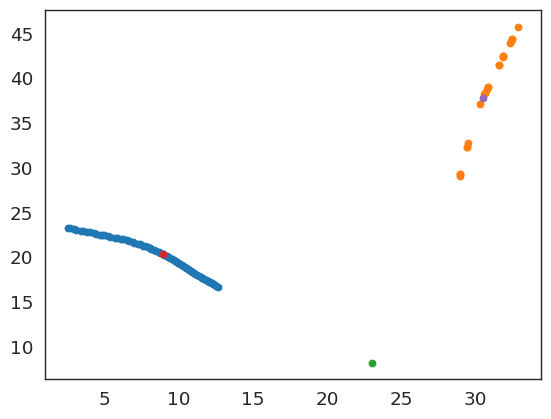

The conflict between vehicle  975 and the vehicle   [980]


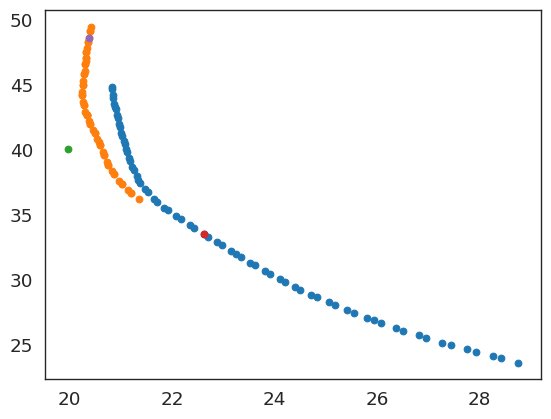

The conflict between vehicle  995 and the vehicle   [989]


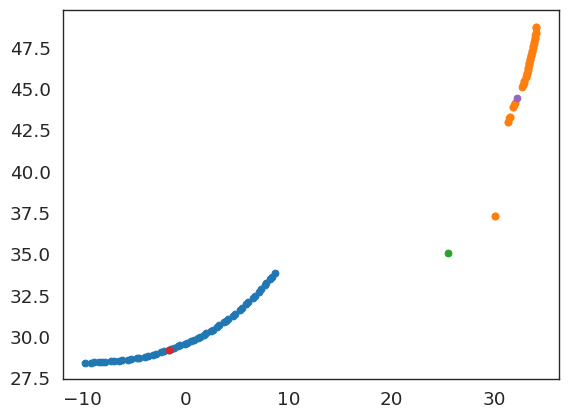

The conflict between vehicle  1004 and the vehicle   [996]


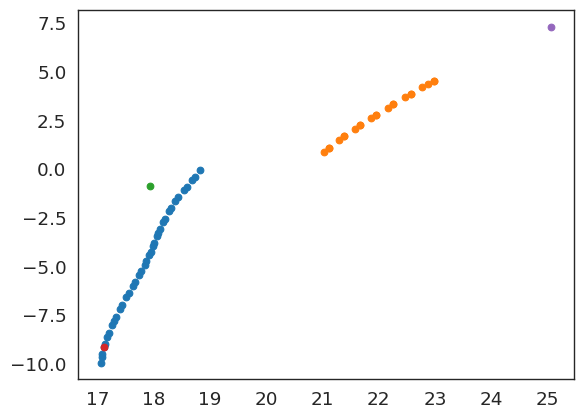

The conflict between vehicle  1005 and the vehicle   [1014]


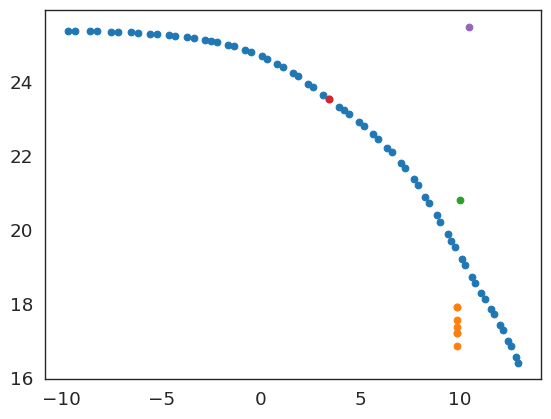

The conflict between vehicle  1024 and the vehicle   [1039]


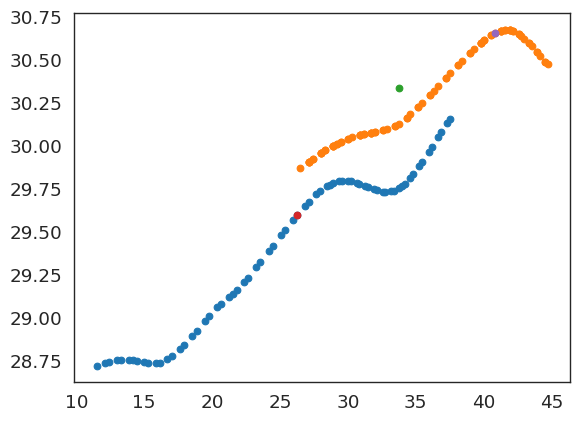

The conflict between vehicle  1039 and the vehicle   [1024]


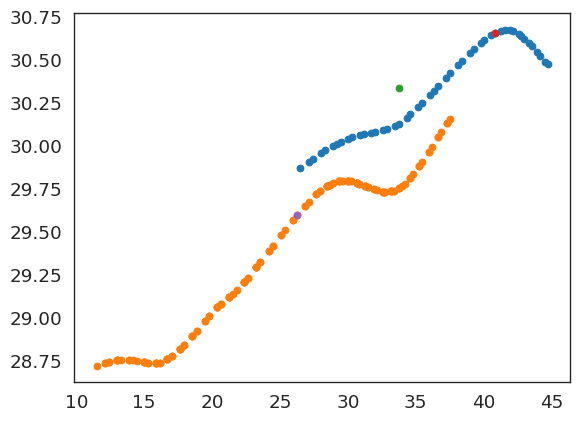

The conflict between vehicle  1060 and the vehicle   [1046]


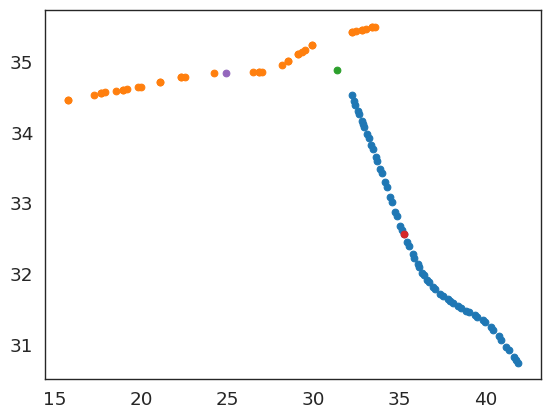

The conflict between vehicle  807 and the vehicle   [785]


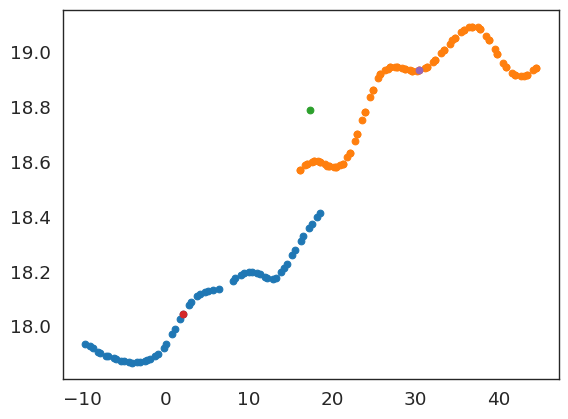

The conflict between vehicle  36 and the vehicle   [38]


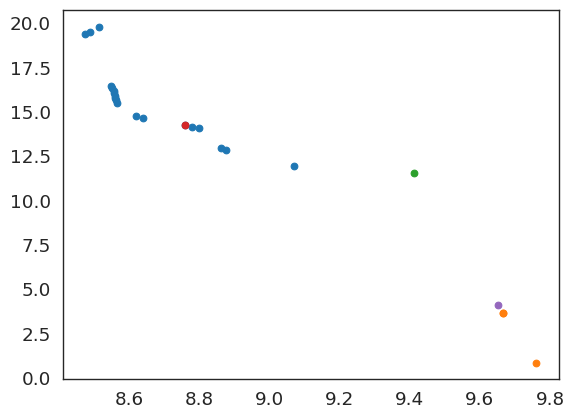

The conflict between vehicle  26 and the vehicle   [38]


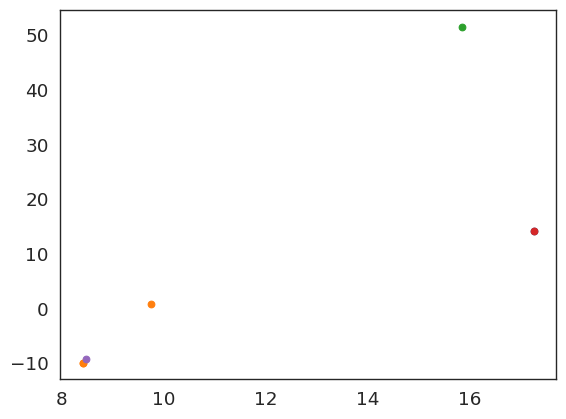

The conflict between vehicle  70 and the vehicle   [69]


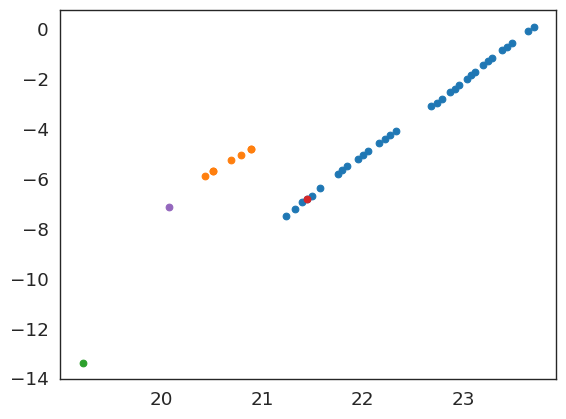

The conflict between vehicle  161 and the vehicle   [159]


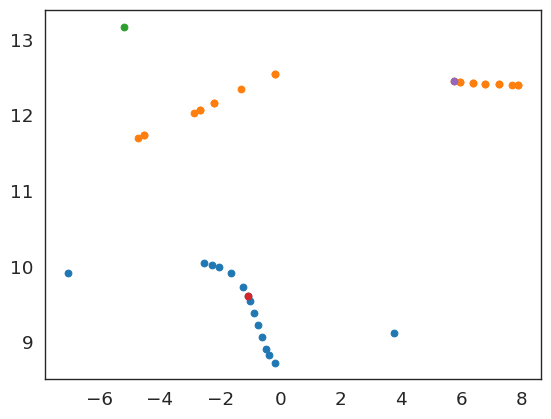

The conflict between vehicle  159 and the vehicle   [161]


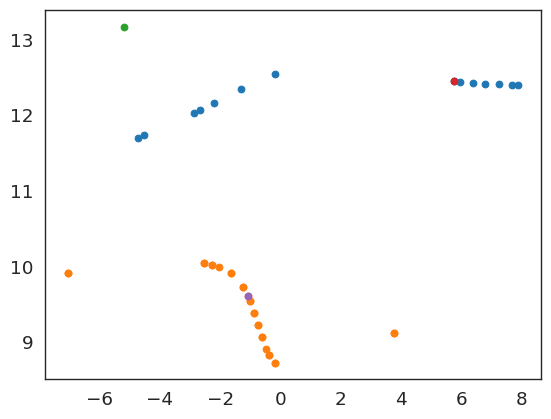

The conflict between vehicle  157 and the vehicle   [186]


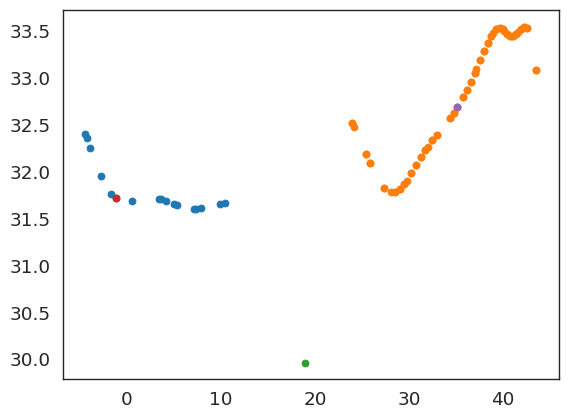

The conflict between vehicle  165 and the vehicle   [161]


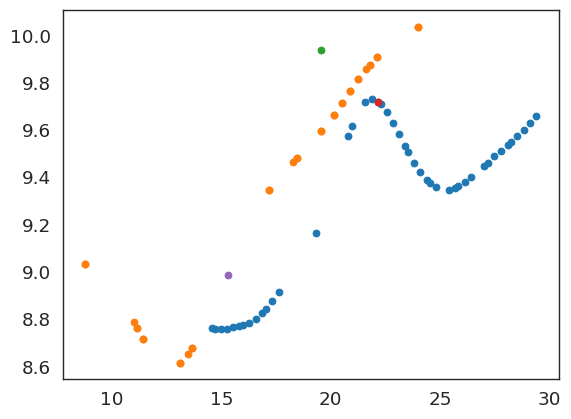

The conflict between vehicle  170 and the vehicle   [205]


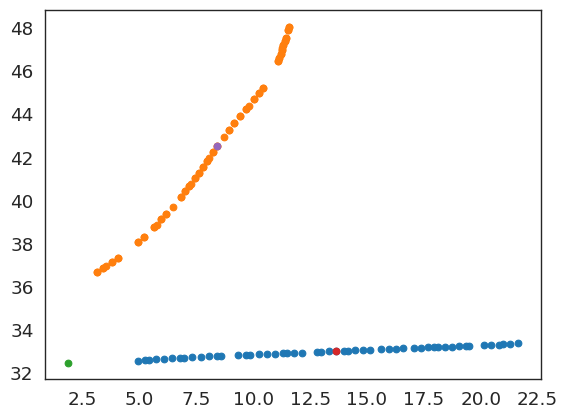

The conflict between vehicle  186 and the vehicle   [157]


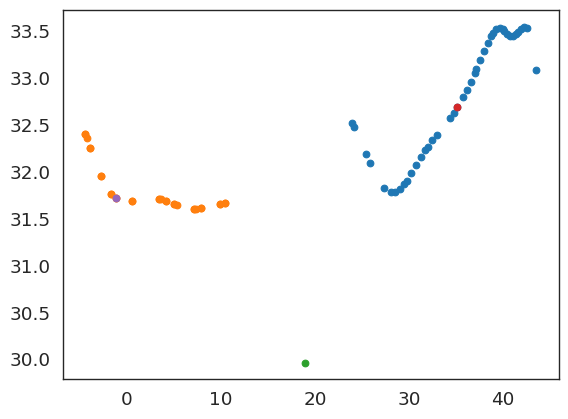

The conflict between vehicle  194 and the vehicle   [199]


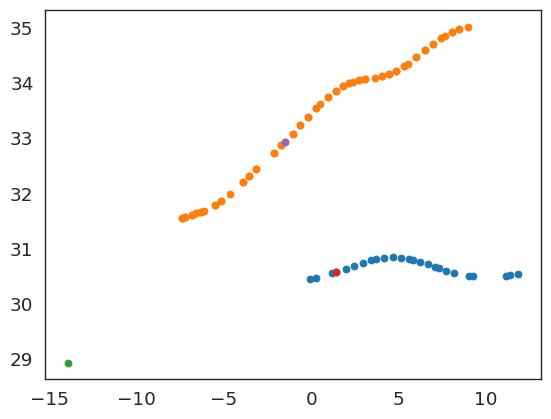

The conflict between vehicle  225 and the vehicle   [239]


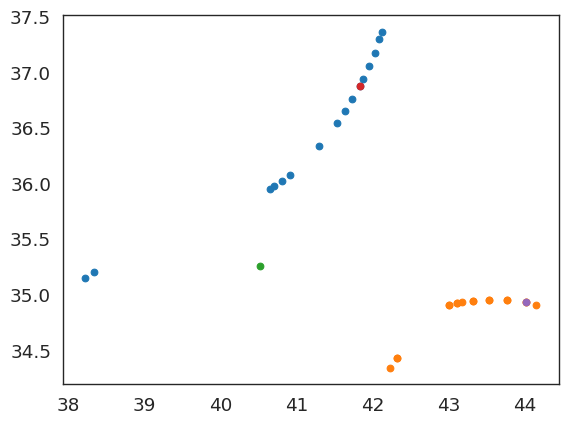

The conflict between vehicle  230 and the vehicle   [214]


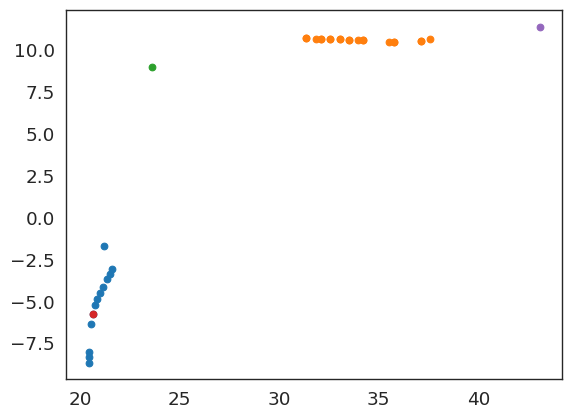

The conflict between vehicle  236 and the vehicle   [225]


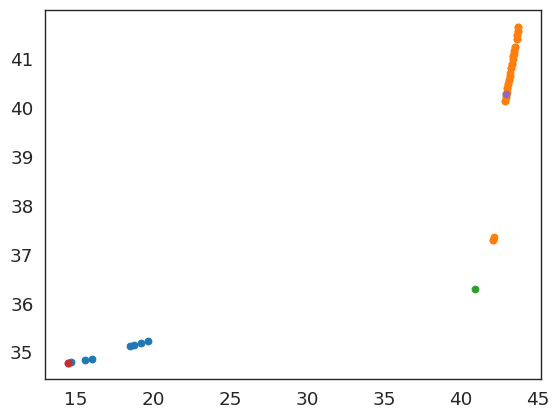

The conflict between vehicle  216 and the vehicle   [239]


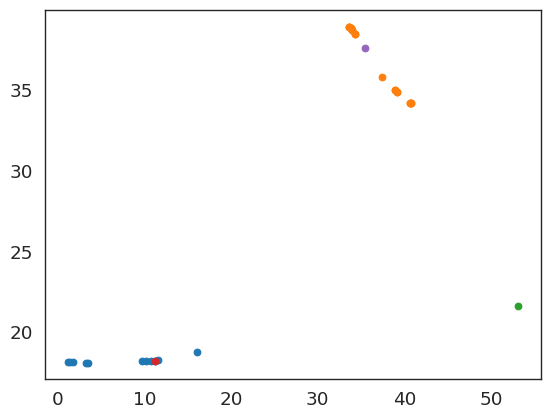

The conflict between vehicle  242 and the vehicle   [236]


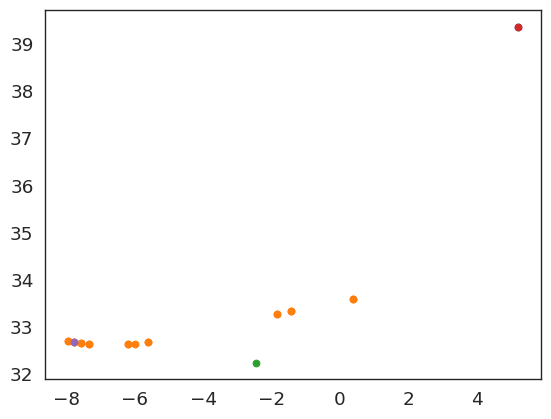

The conflict between vehicle  311 and the vehicle   [310]


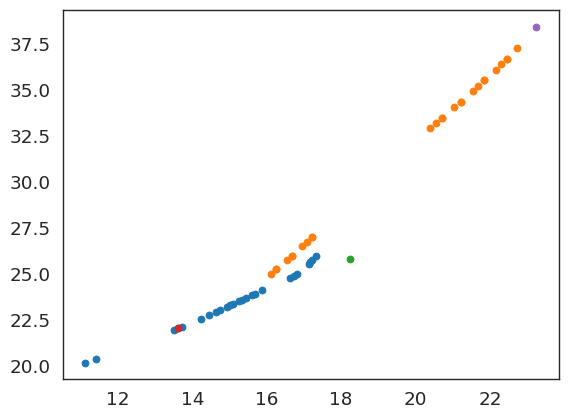

The conflict between vehicle  304 and the vehicle   [313]


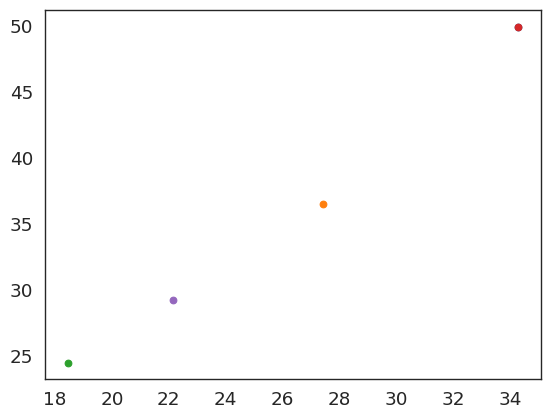

The conflict between vehicle  352 and the vehicle   [356]


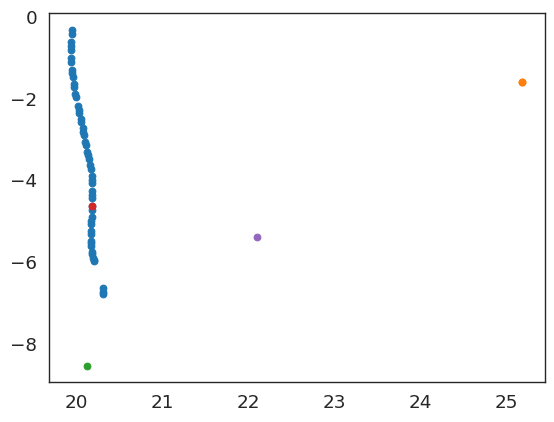

The conflict between vehicle  356 and the vehicle   [380]


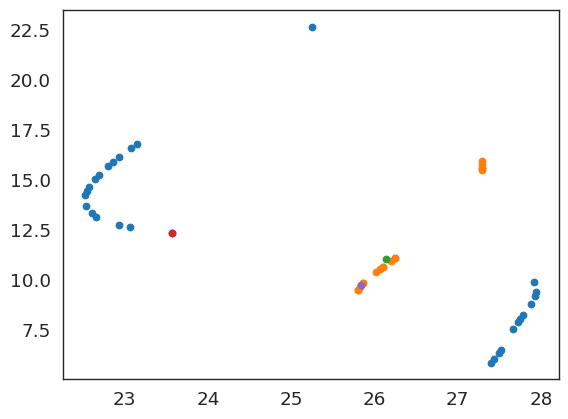

The conflict between vehicle  363 and the vehicle   [391]


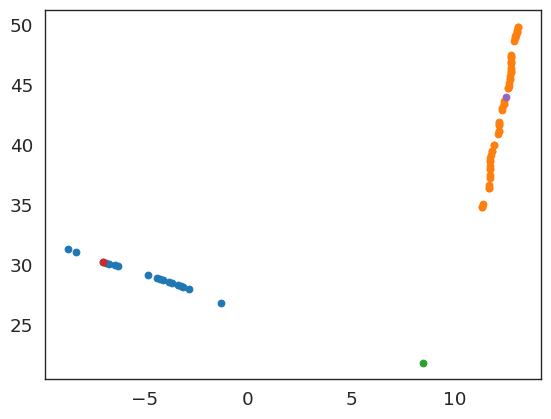

The conflict between vehicle  372 and the vehicle   [378]


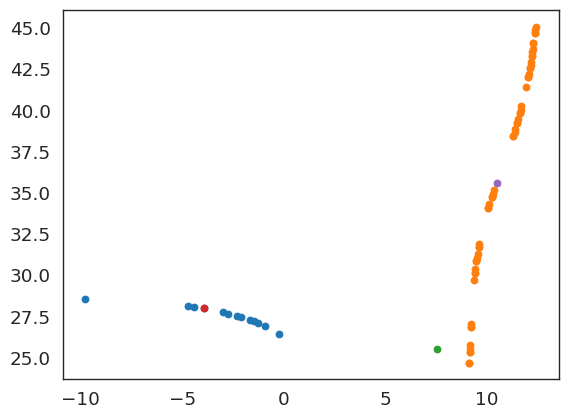

The conflict between vehicle  374 and the vehicle   [380]


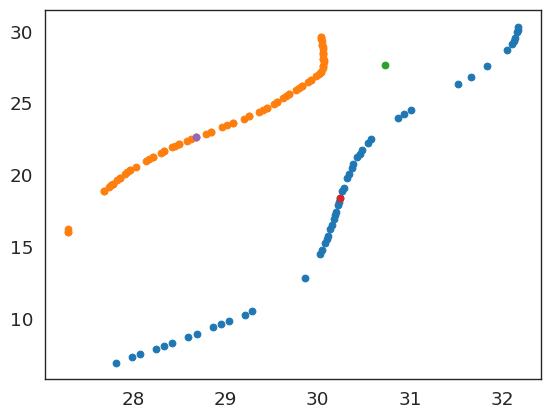

The conflict between vehicle  380 and the vehicle   [374]


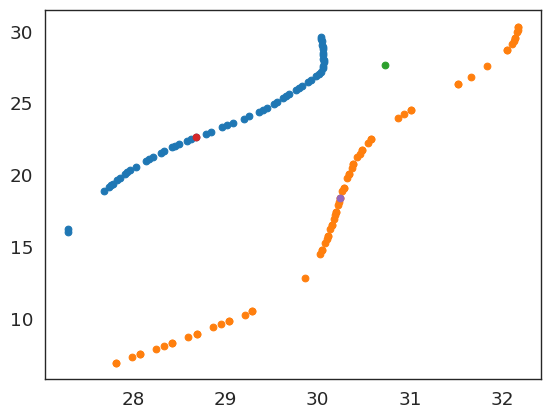

The conflict between vehicle  384 and the vehicle   [413]


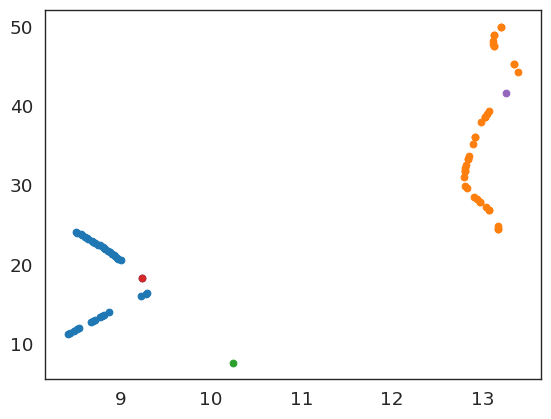

The conflict between vehicle  385 and the vehicle   [387]


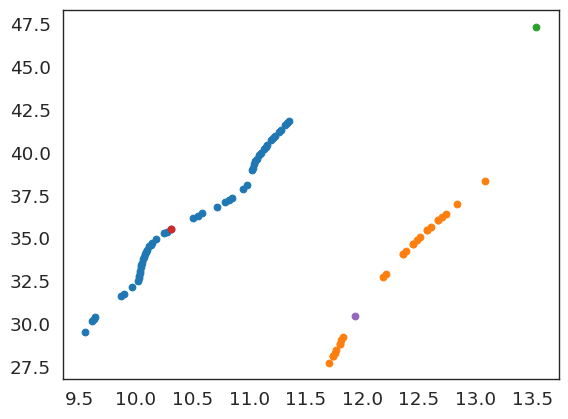

The conflict between vehicle  387 and the vehicle   [394]


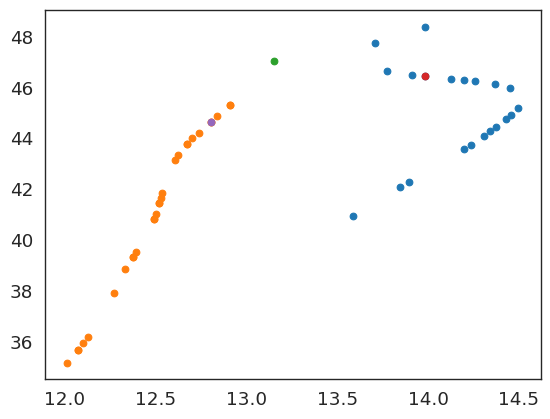

The conflict between vehicle  391 and the vehicle   [405]


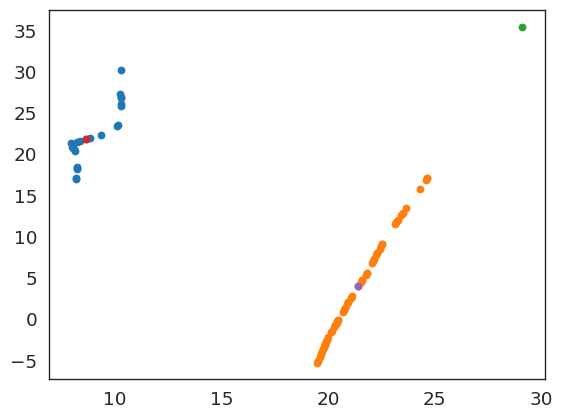

The conflict between vehicle  394 and the vehicle   [387]


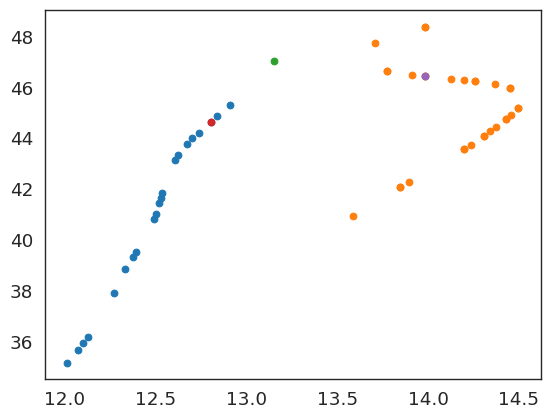

The conflict between vehicle  398 and the vehicle   [411]


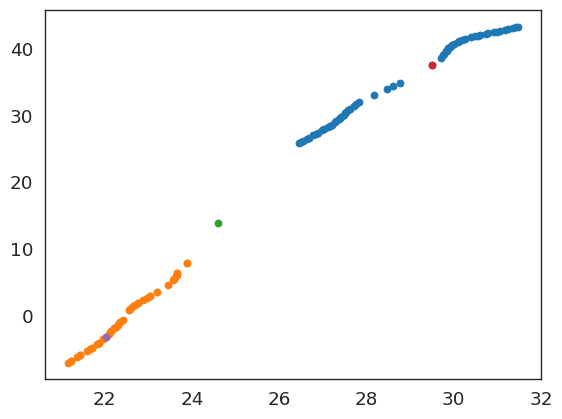

The conflict between vehicle  397 and the vehicle   [391]


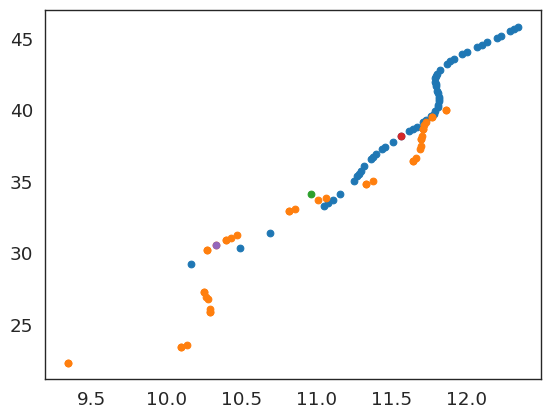

The conflict between vehicle  404 and the vehicle   [410]


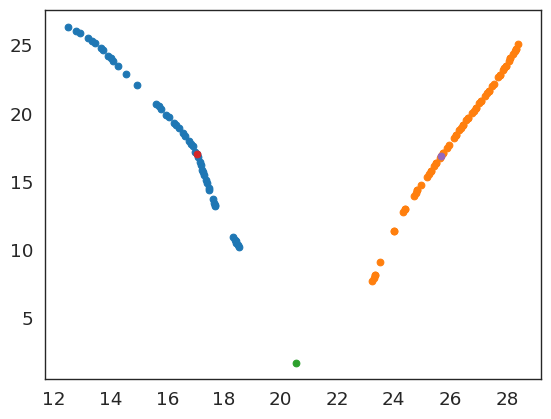

The conflict between vehicle  405 and the vehicle   [391]


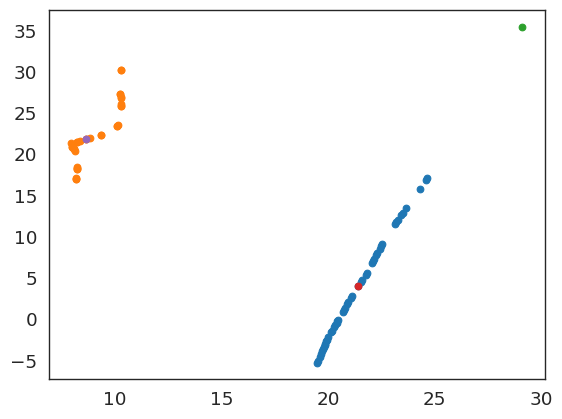

The conflict between vehicle  410 and the vehicle   [416]


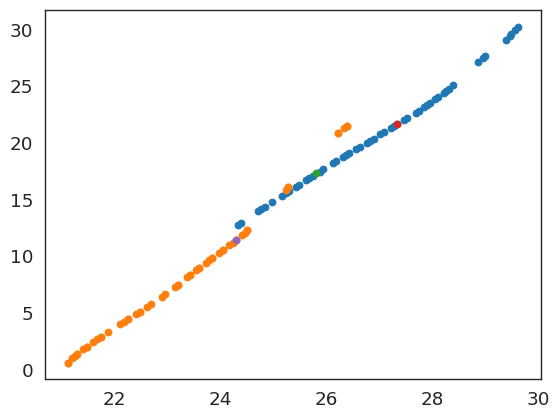

The conflict between vehicle  411 and the vehicle   [397]


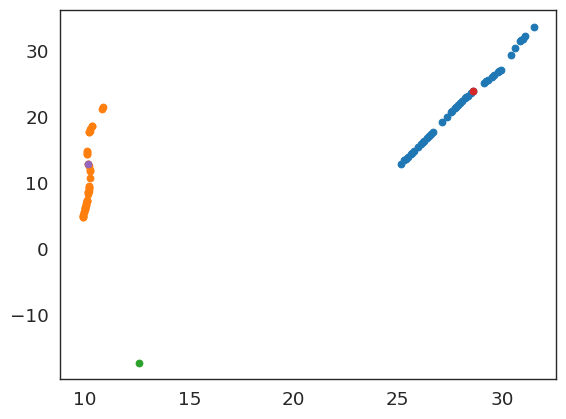

The conflict between vehicle  408 and the vehicle   [444]


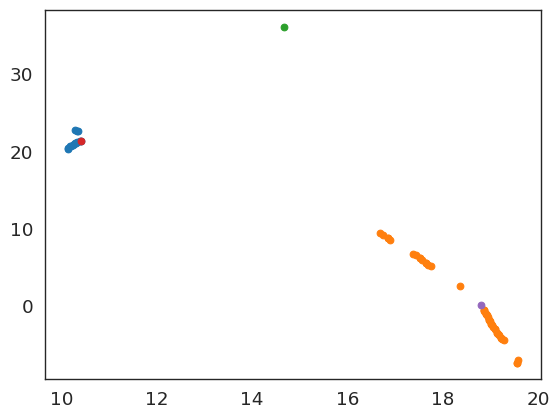

The conflict between vehicle  416 and the vehicle   [410]


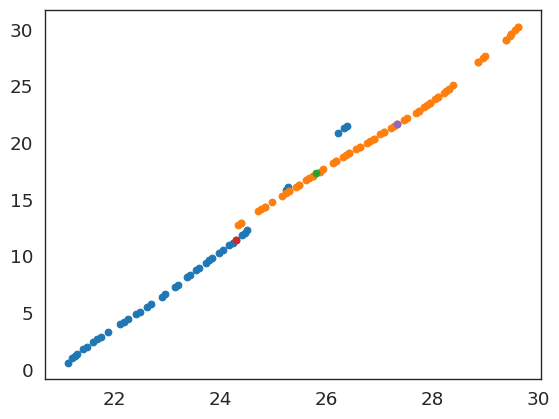

The conflict between vehicle  433 and the vehicle   [424]


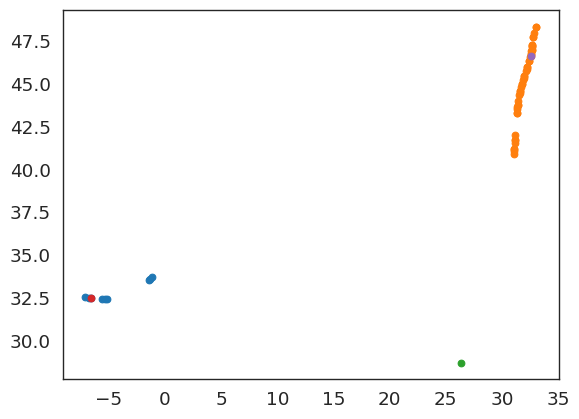

The conflict between vehicle  441 and the vehicle   [442]


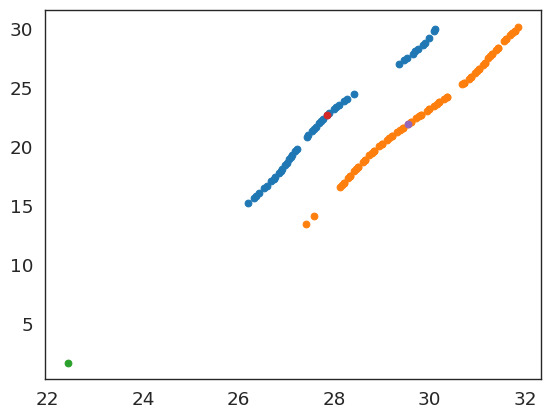

The conflict between vehicle  442 and the vehicle   [438]


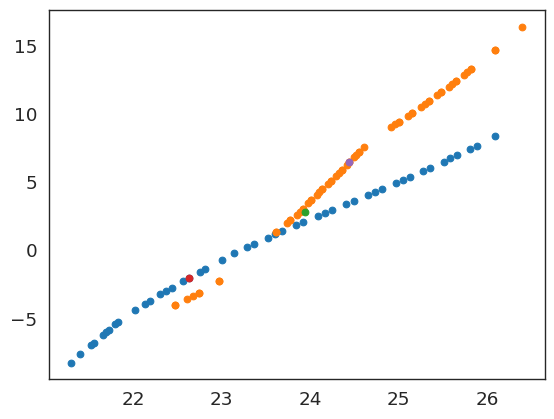

The conflict between vehicle  444 and the vehicle   [466]


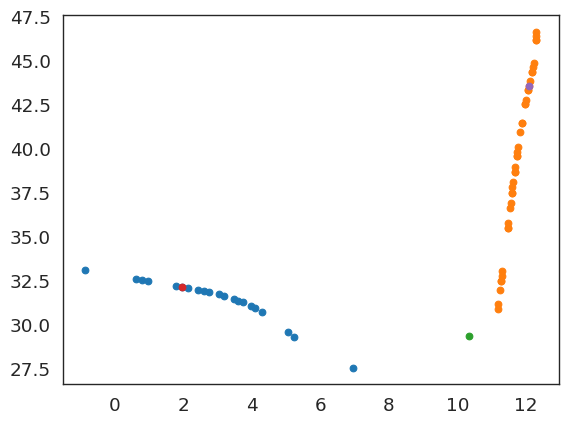

The conflict between vehicle  451 and the vehicle   [460]


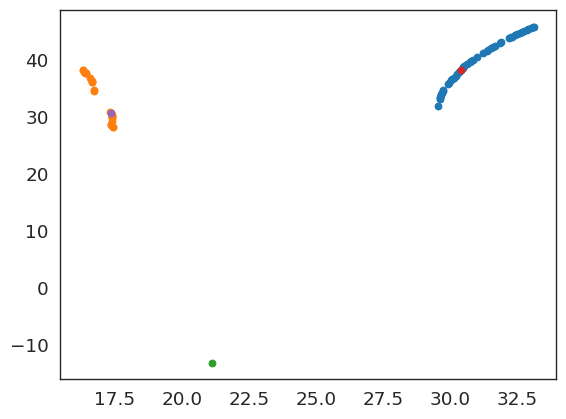

The conflict between vehicle  460 and the vehicle   [466]


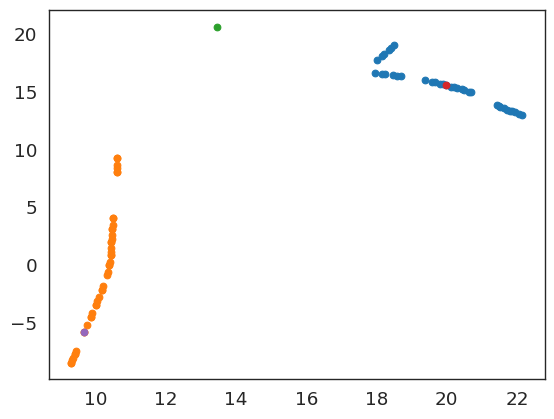

The conflict between vehicle  484 and the vehicle   [476]


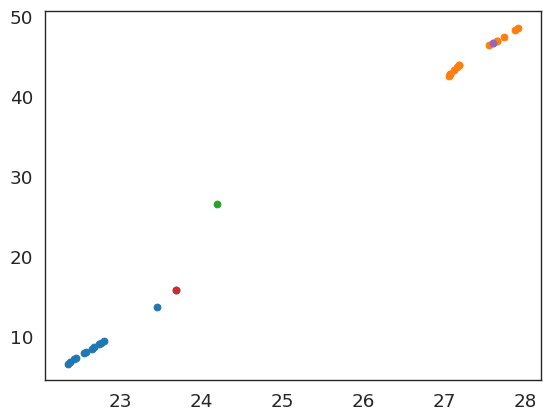

The conflict between vehicle  479 and the vehicle   [460]


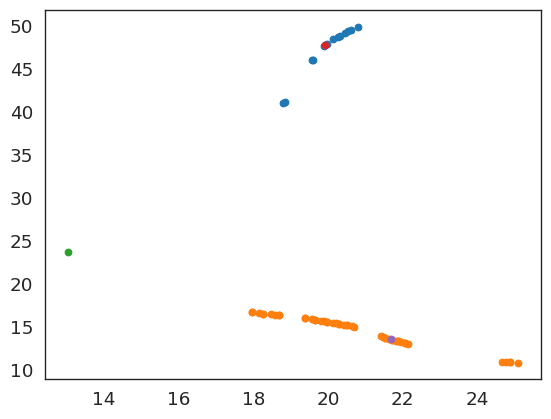

The conflict between vehicle  499 and the vehicle   [484]


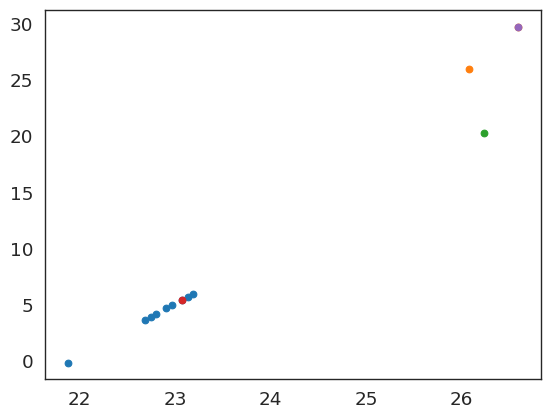

The conflict between vehicle  505 and the vehicle   [512]


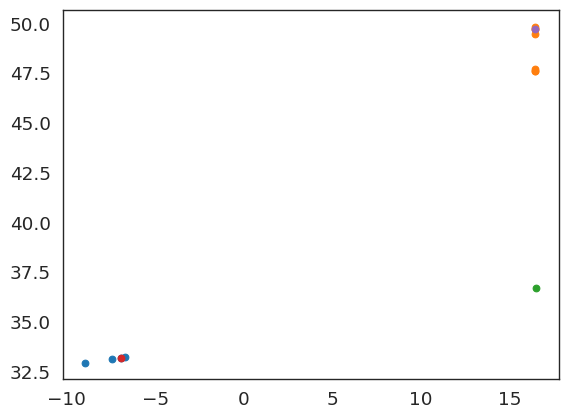

The conflict between vehicle  503 and the vehicle   [517]


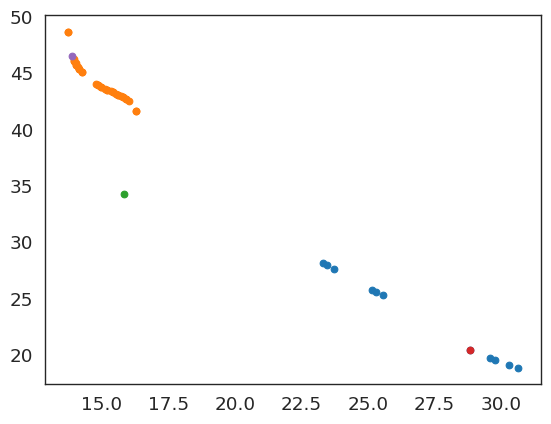

The conflict between vehicle  512 and the vehicle   [505]


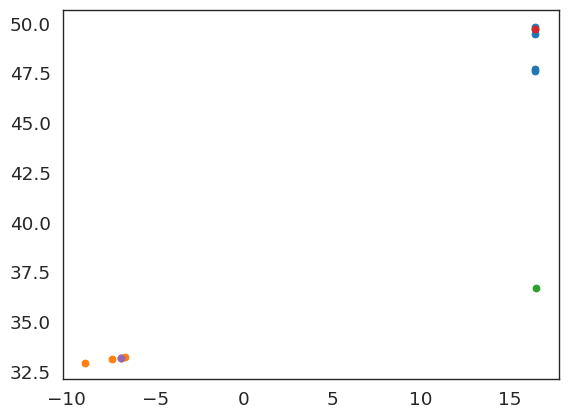

The conflict between vehicle  519 and the vehicle   [517]


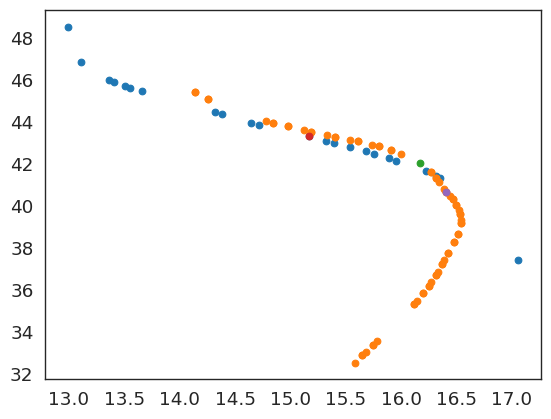

The conflict between vehicle  301 and the vehicle   [601]


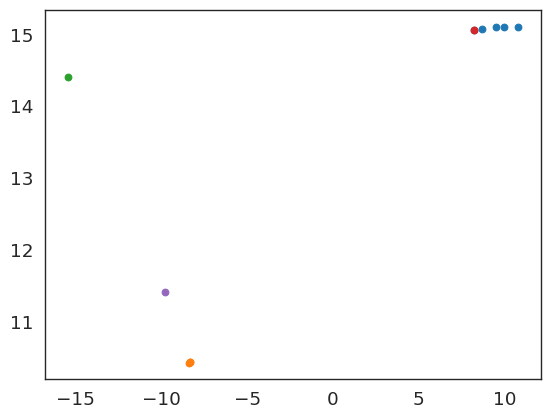

The conflict between vehicle  599 and the vehicle   [601]


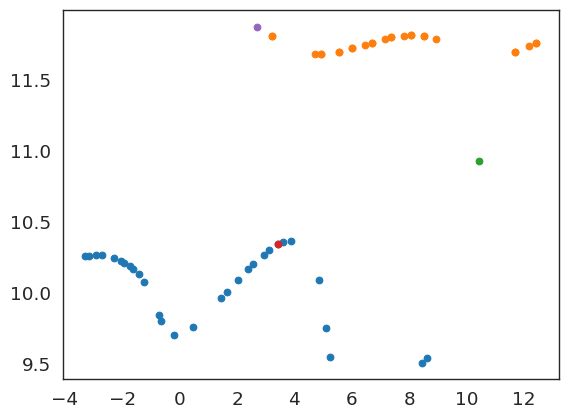

The conflict between vehicle  583 and the vehicle   [601]


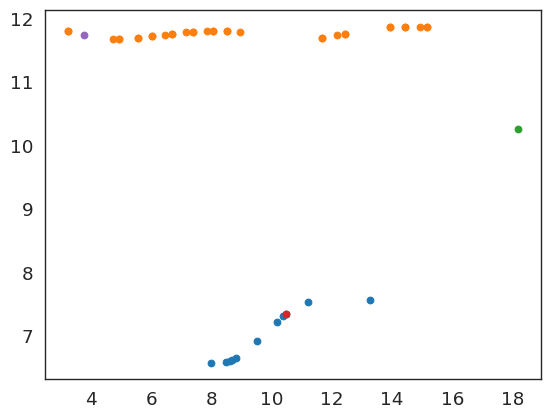

The conflict between vehicle  593 and the vehicle   [603]


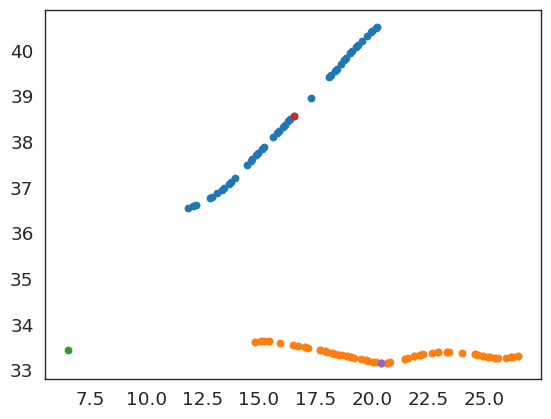

The conflict between vehicle  621 and the vehicle   [640]


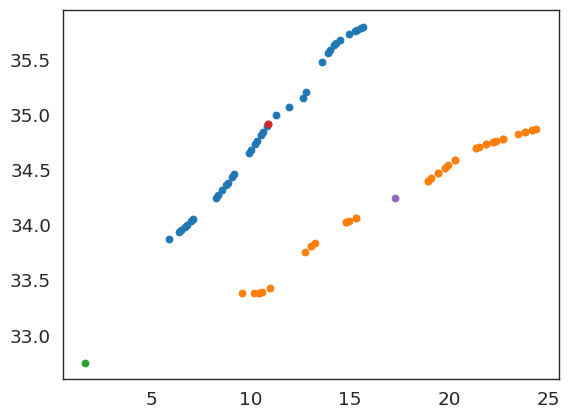

The conflict between vehicle  624 and the vehicle   [623]


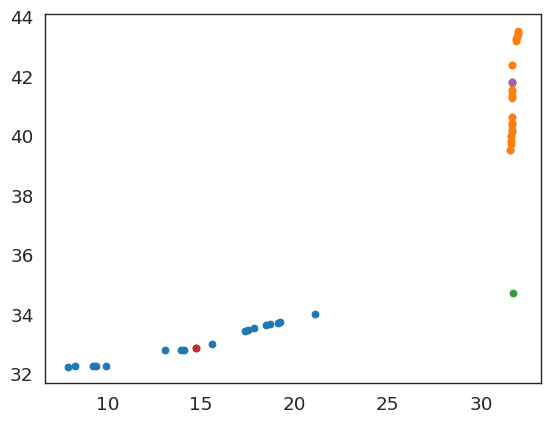

The conflict between vehicle  625 and the vehicle   [624]


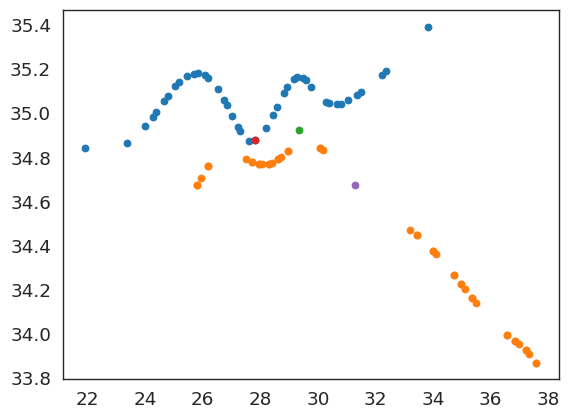

The conflict between vehicle  622 and the vehicle   [624]


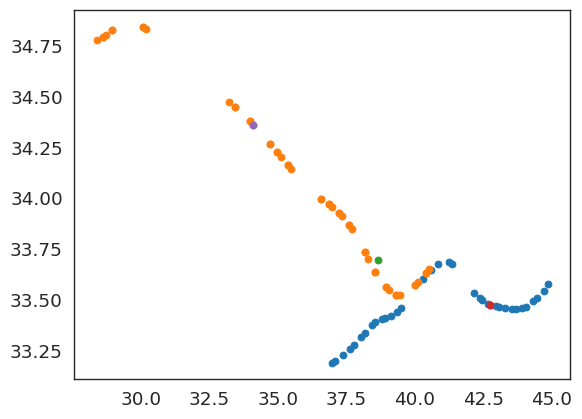

The conflict between vehicle  656 and the vehicle   [646]


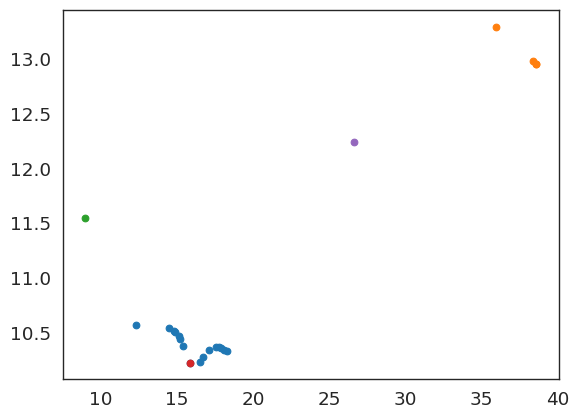

The conflict between vehicle  735 and the vehicle   [734]


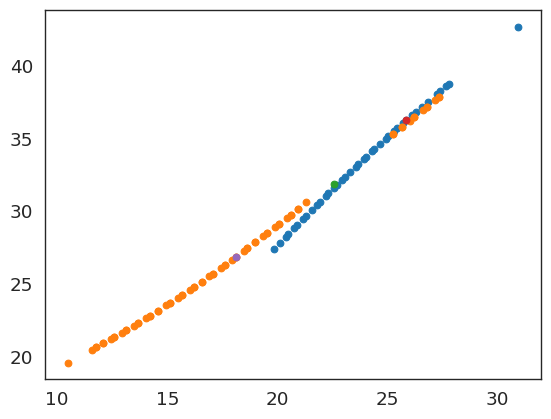

The conflict between vehicle  731 and the vehicle   [735]


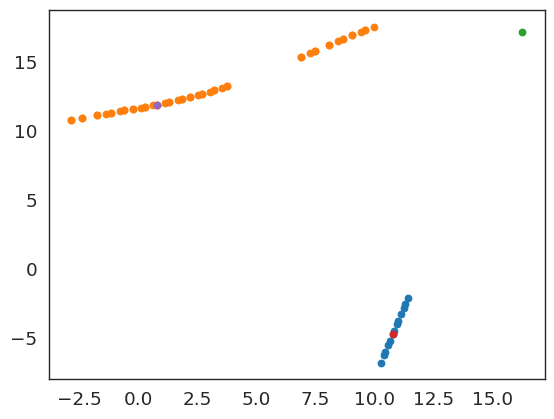

The conflict between vehicle  734 and the vehicle   [735]


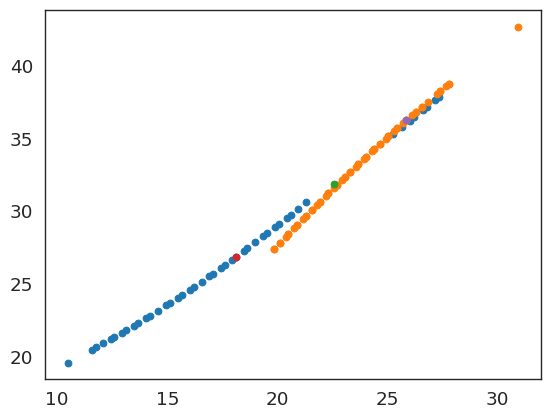

The conflict between vehicle  740 and the vehicle   [751]


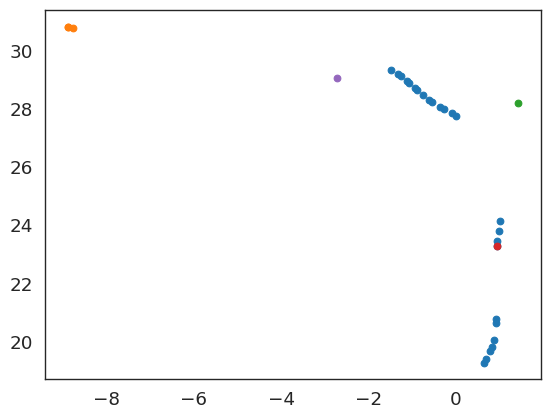

The conflict between vehicle  741 and the vehicle   [735]


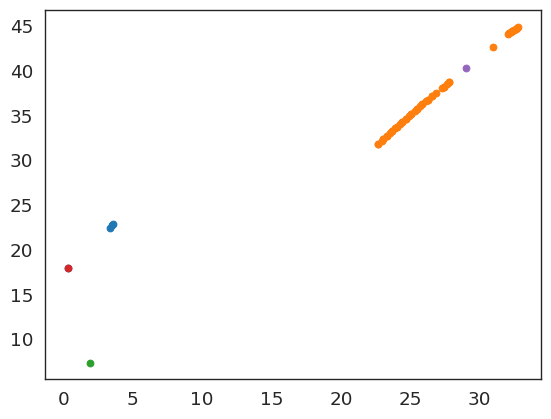

The conflict between vehicle  772 and the vehicle   [775]


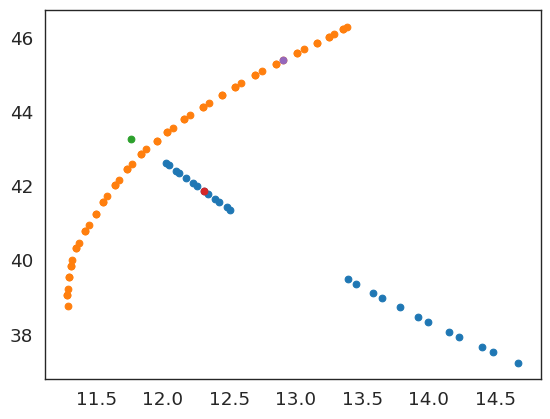

The conflict between vehicle  779 and the vehicle   [787]


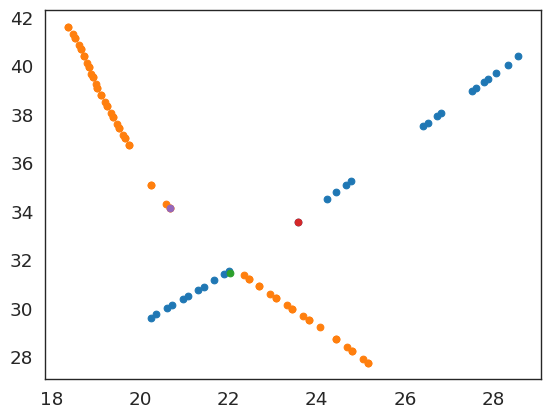

The conflict between vehicle  787 and the vehicle   [775]


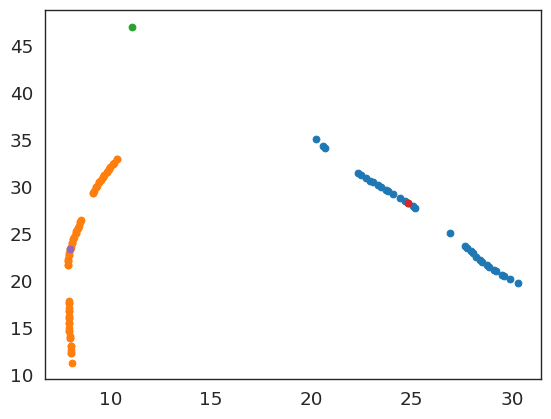

The conflict between vehicle  782 and the vehicle   [835]


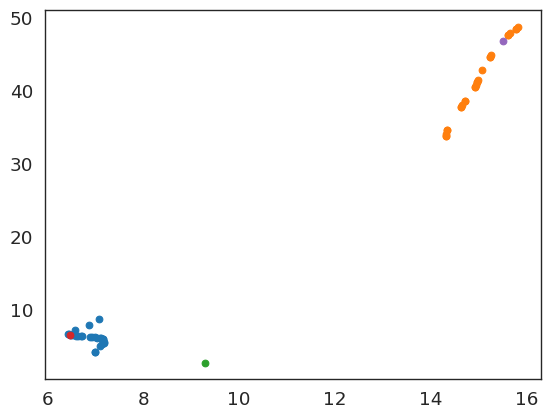

The conflict between vehicle  757 and the vehicle   [775]


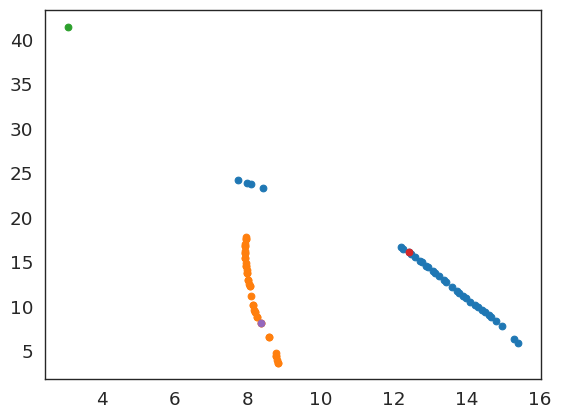

The conflict between vehicle  794 and the vehicle   [811]


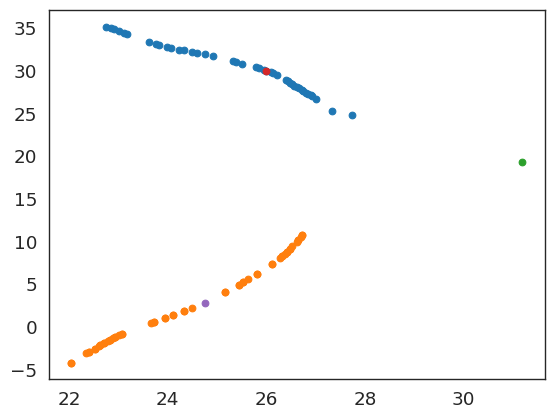

The conflict between vehicle  805 and the vehicle   [757]


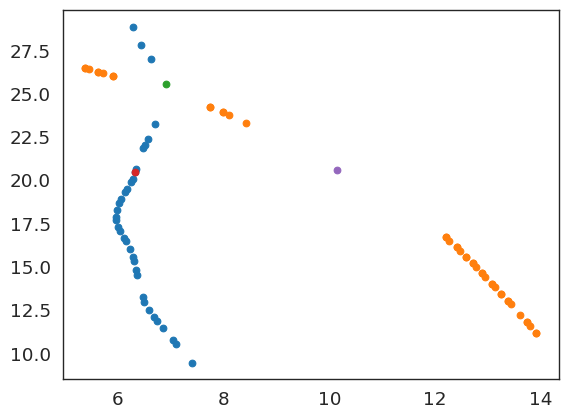

The conflict between vehicle  803 and the vehicle   [813]


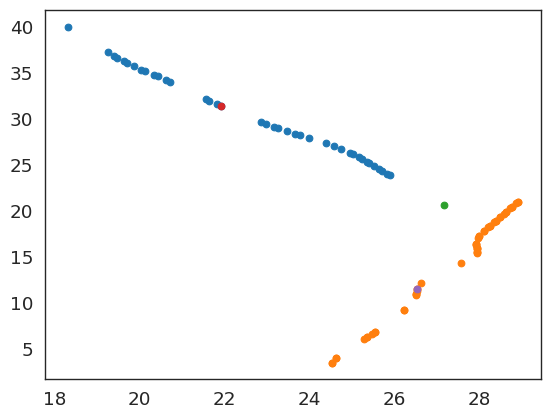

The conflict between vehicle  801 and the vehicle   [810]


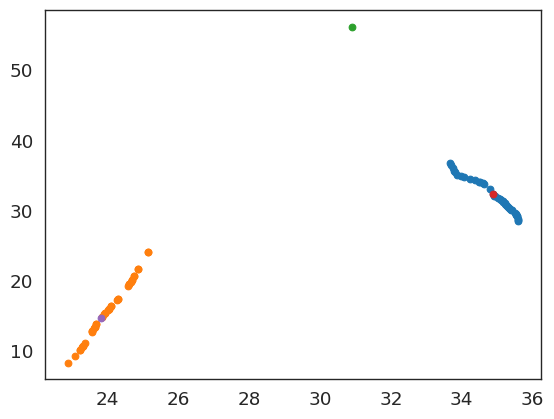

The conflict between vehicle  806 and the vehicle   [824]


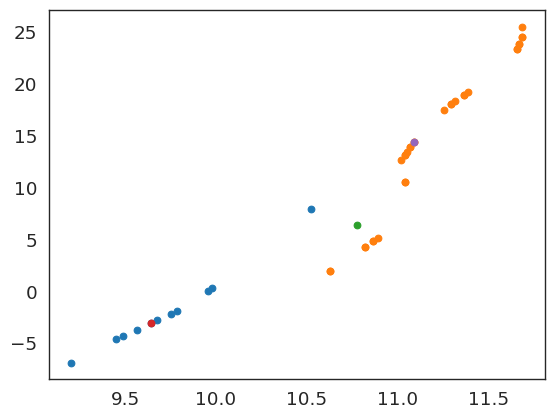

The conflict between vehicle  809 and the vehicle   [798]


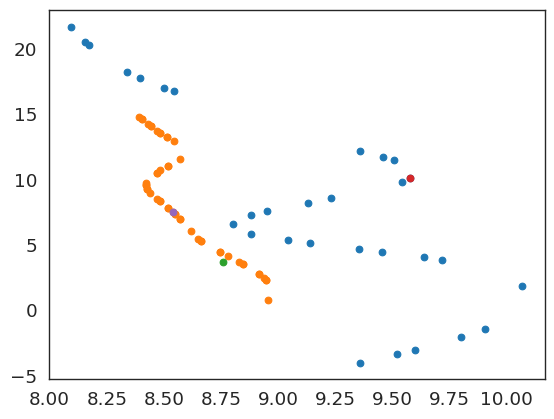

The conflict between vehicle  820 and the vehicle   [808]


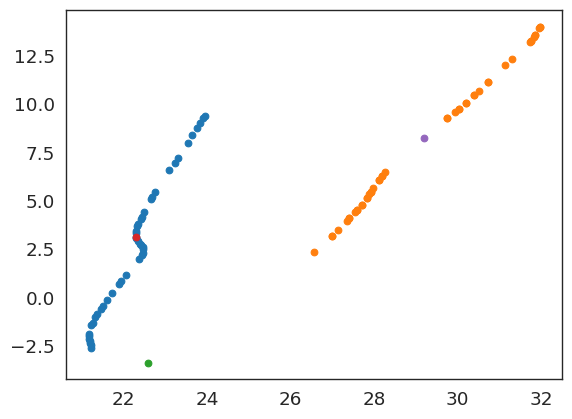

The conflict between vehicle  823 and the vehicle   [825]


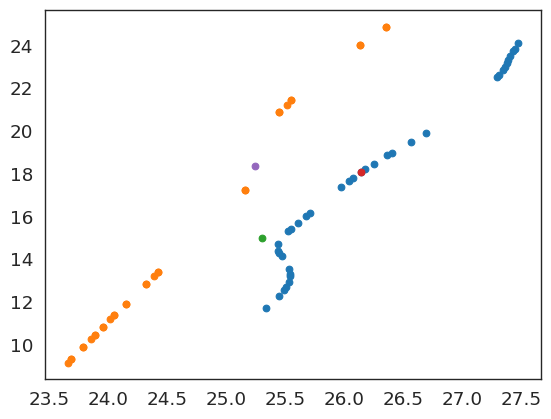

The conflict between vehicle  824 and the vehicle   [806]


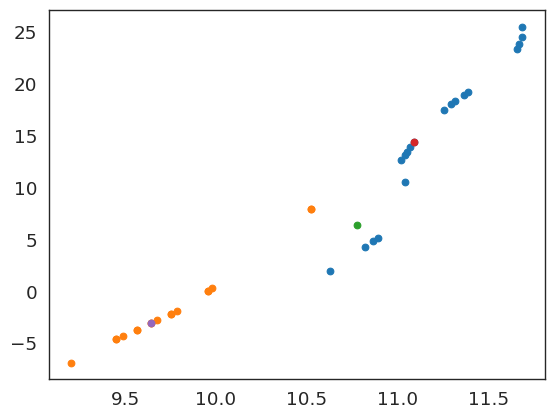

The conflict between vehicle  814 and the vehicle   [798]


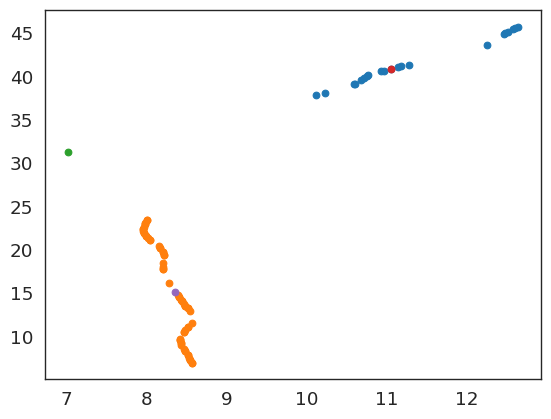

The conflict between vehicle  830 and the vehicle   [836]


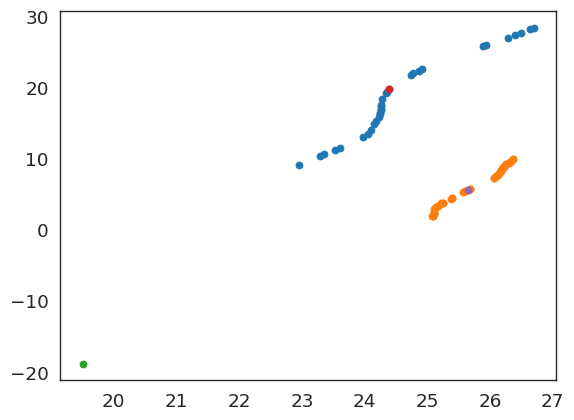

The conflict between vehicle  833 and the vehicle   [857]


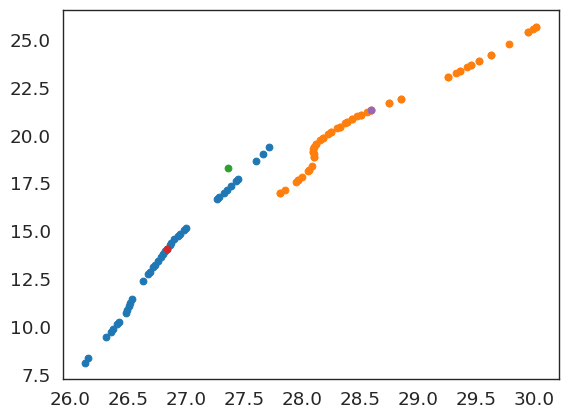

The conflict between vehicle  834 and the vehicle   [798]


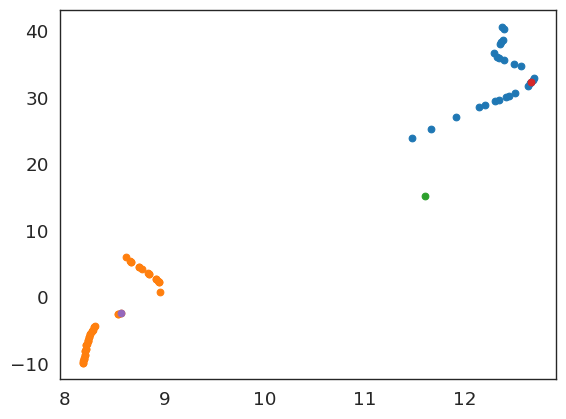

The conflict between vehicle  836 and the vehicle   [851]


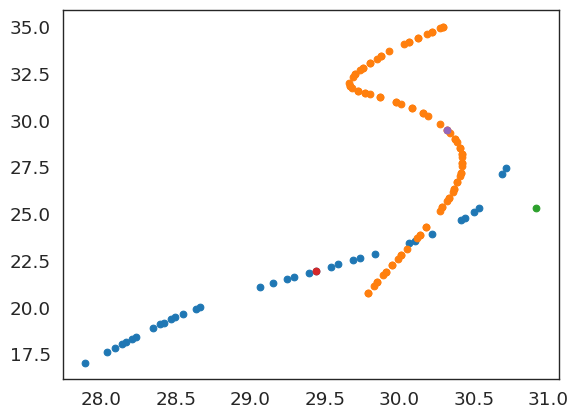

The conflict between vehicle  835 and the vehicle   [842]


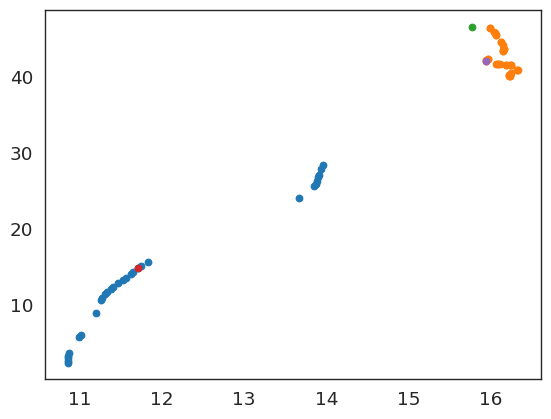

The conflict between vehicle  851 and the vehicle   [836]


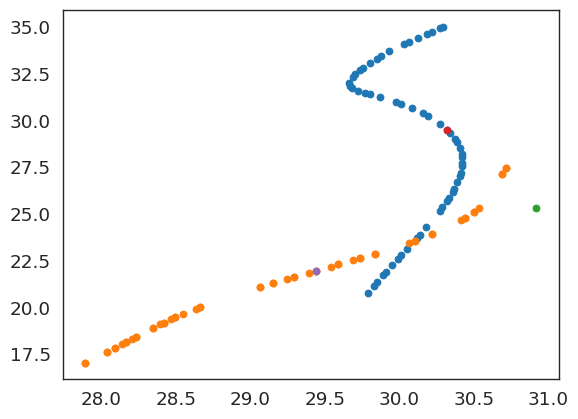

The conflict between vehicle  852 and the vehicle   [877]


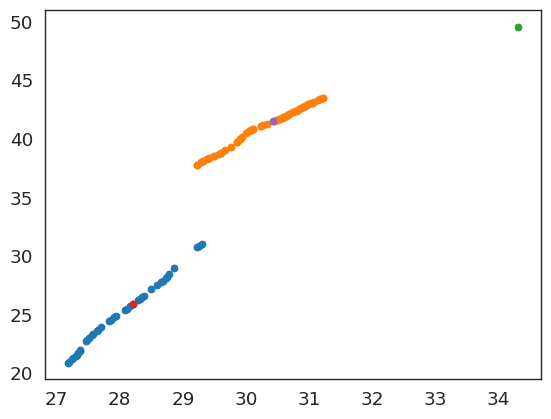

The conflict between vehicle  842 and the vehicle   [856]


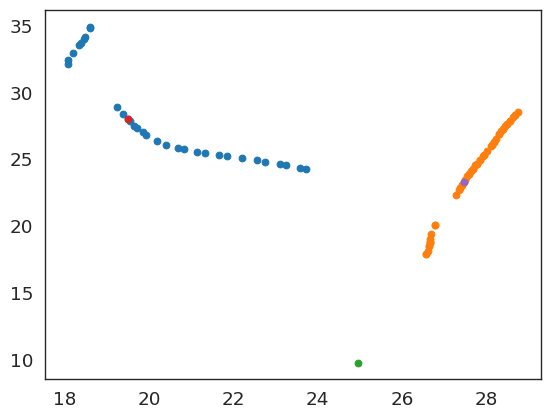

The conflict between vehicle  857 and the vehicle   [862]


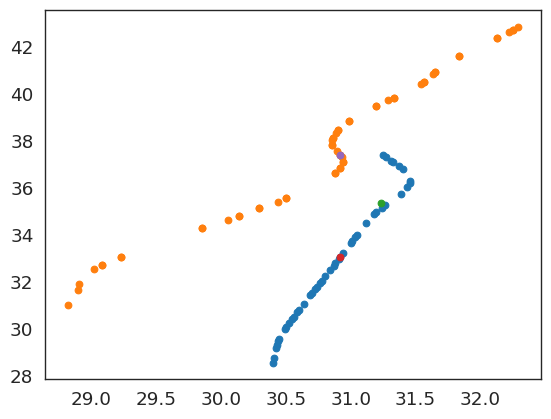

The conflict between vehicle  832 and the vehicle   [825]


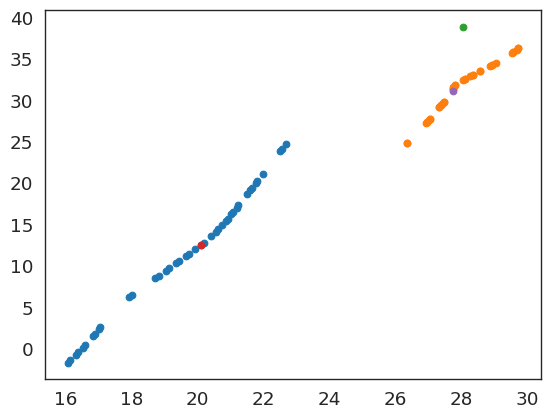

The conflict between vehicle  845 and the vehicle   [851]


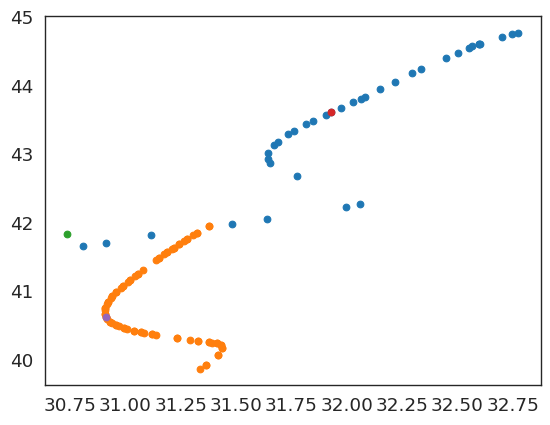

The conflict between vehicle  862 and the vehicle   [857]


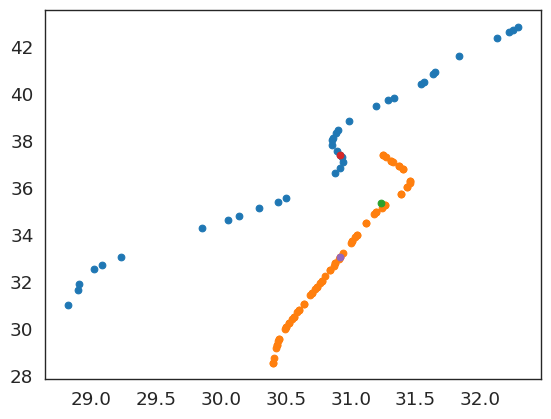

The conflict between vehicle  859 and the vehicle   [872]


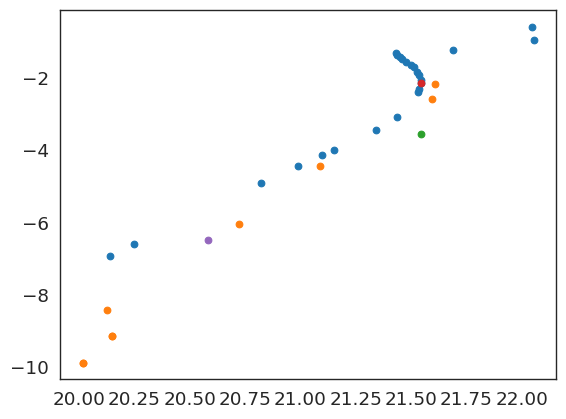

The conflict between vehicle  866 and the vehicle   [912]


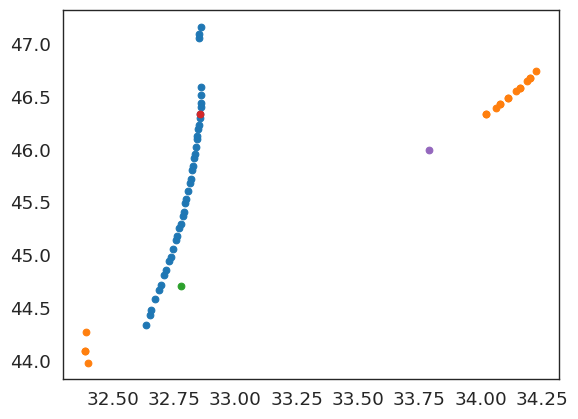

The conflict between vehicle  872 and the vehicle   [845]


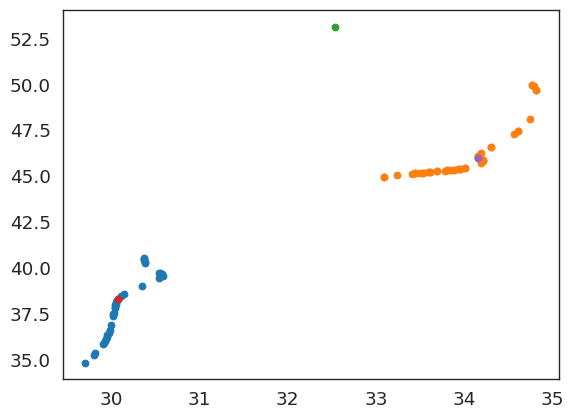

The conflict between vehicle  877 and the vehicle   [883]


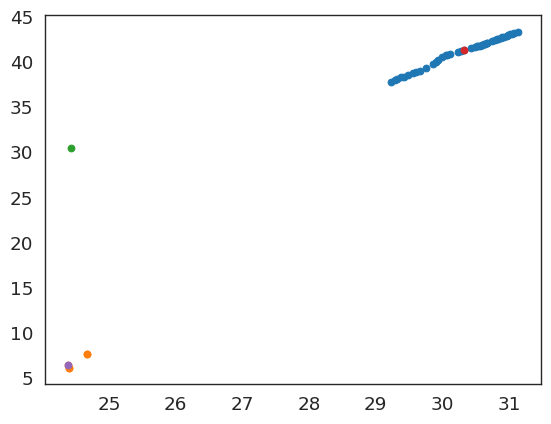

The conflict between vehicle  879 and the vehicle   [894]


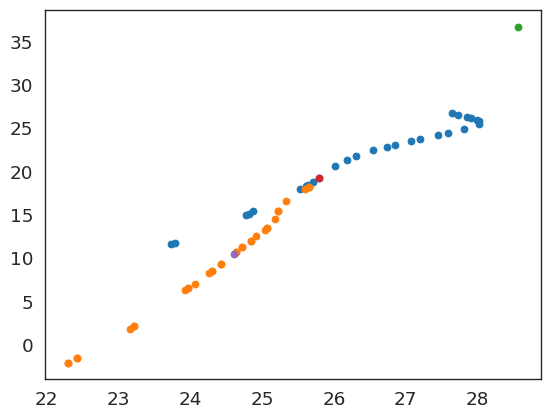

The conflict between vehicle  881 and the vehicle   [872]


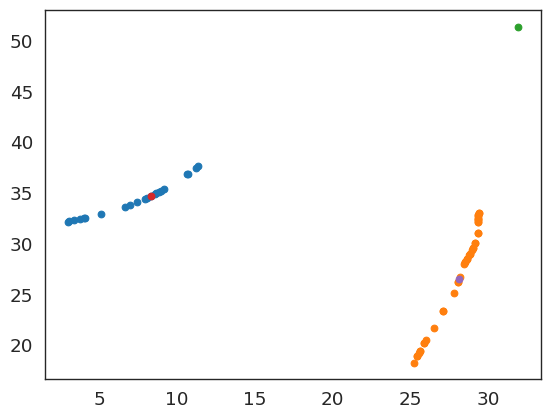

The conflict between vehicle  875 and the vehicle   [851]


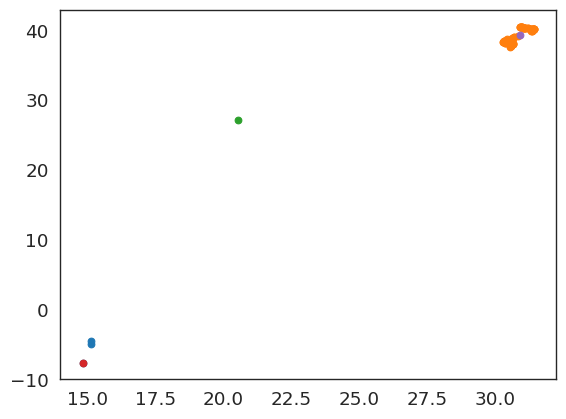

The conflict between vehicle  897 and the vehicle   [895]


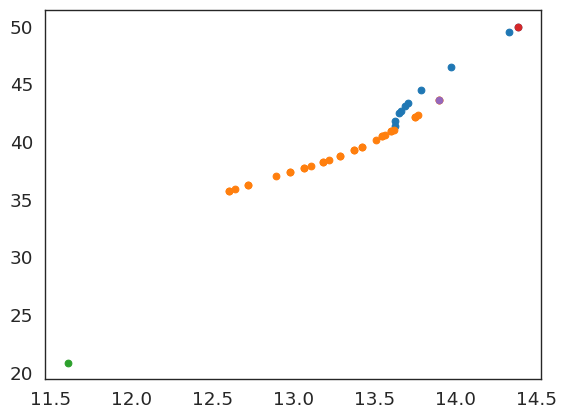

The conflict between vehicle  909 and the vehicle   [880]


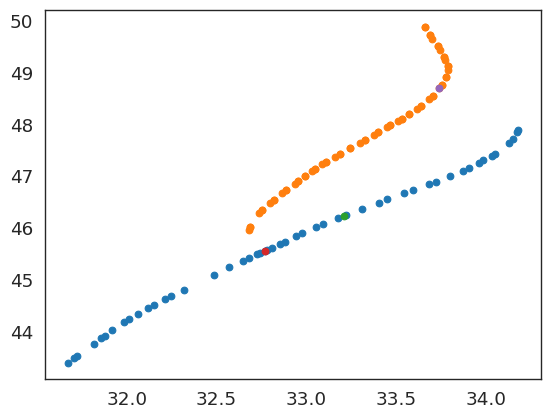

The conflict between vehicle  916 and the vehicle   [941]


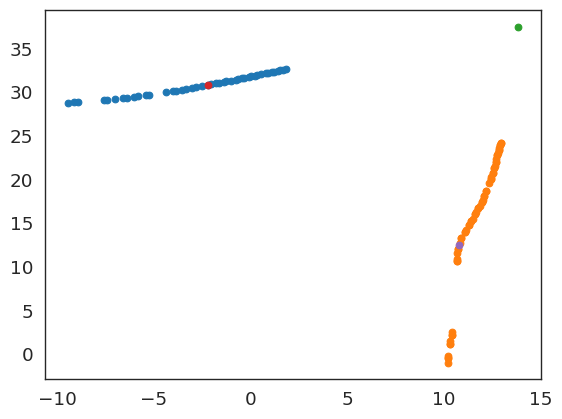

The conflict between vehicle  934 and the vehicle   [925]


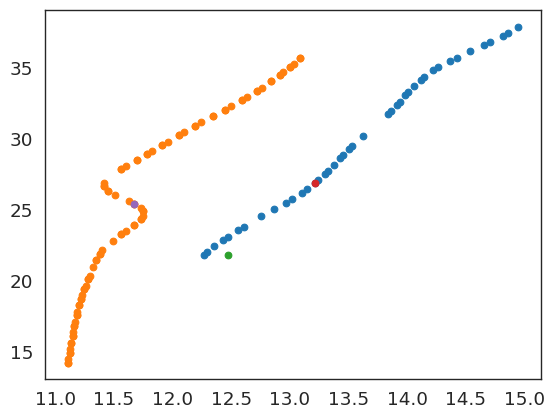

The conflict between vehicle  945 and the vehicle   [941]


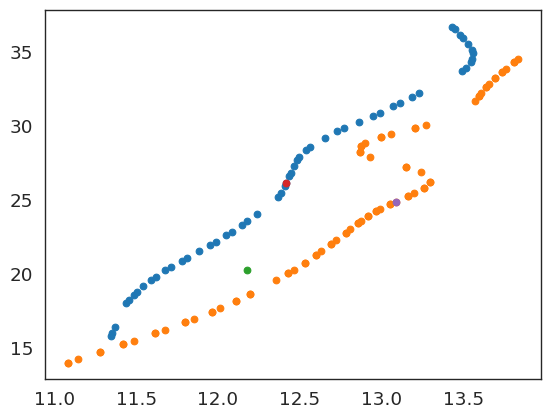

The conflict between vehicle  947 and the vehicle   [941]


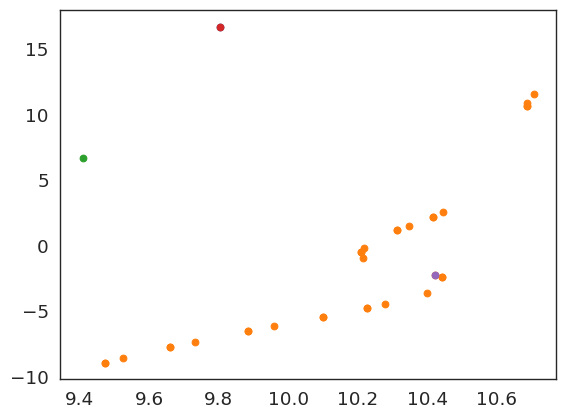

The conflict between vehicle  964 and the vehicle   [957]


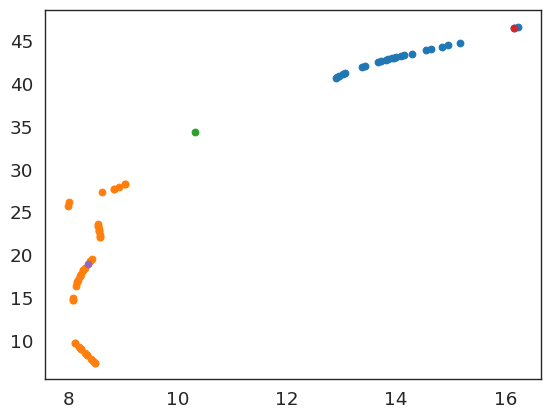

The conflict between vehicle  970 and the vehicle   [965]


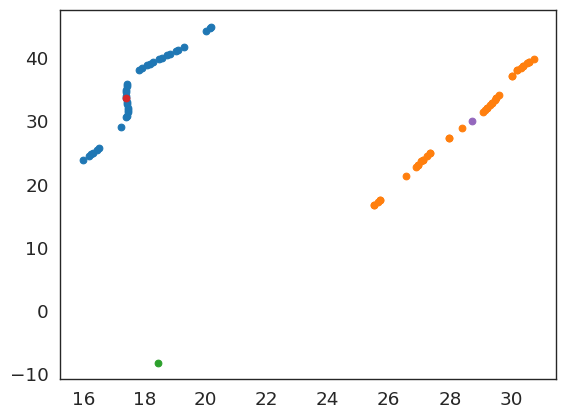

The conflict between vehicle  987 and the vehicle   [989]


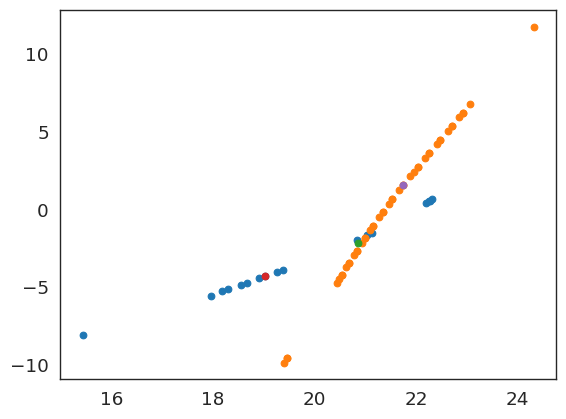

The conflict between vehicle  989 and the vehicle   [987]


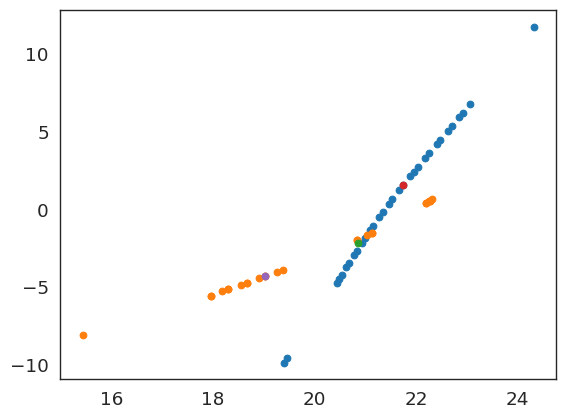

The conflict between vehicle  998 and the vehicle   [997]


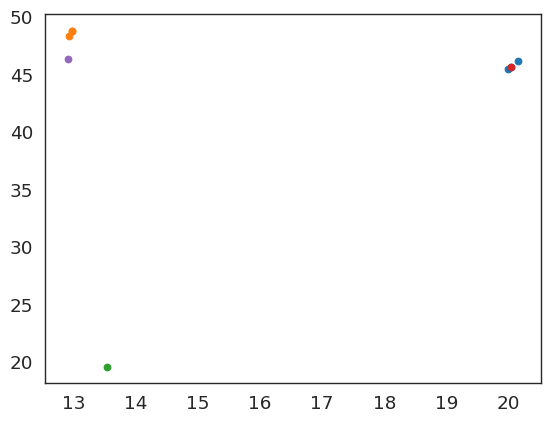

The conflict between vehicle  1014 and the vehicle   [1029]


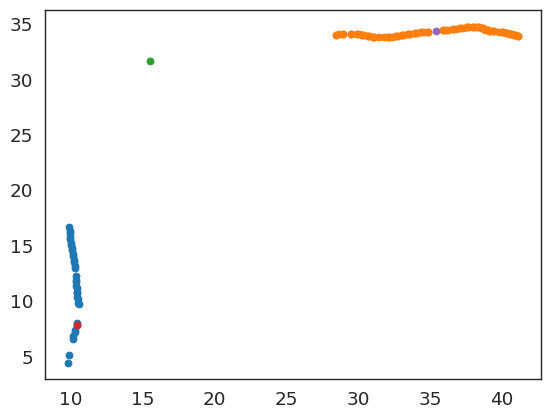

The conflict between vehicle  1028 and the vehicle   [1040]


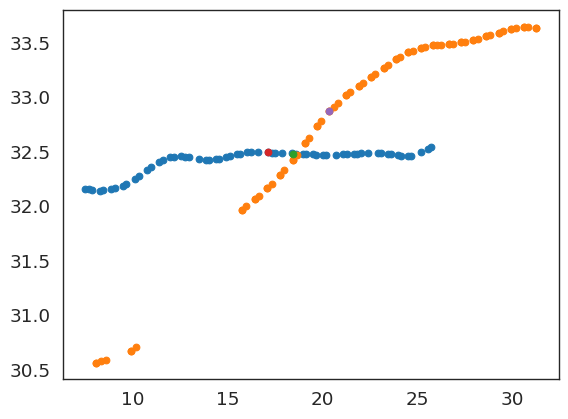

The conflict between vehicle  1030 and the vehicle   [1043]


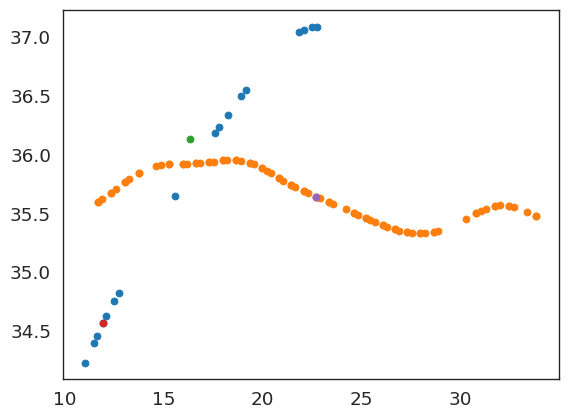

The conflict between vehicle  1040 and the vehicle   [1028]


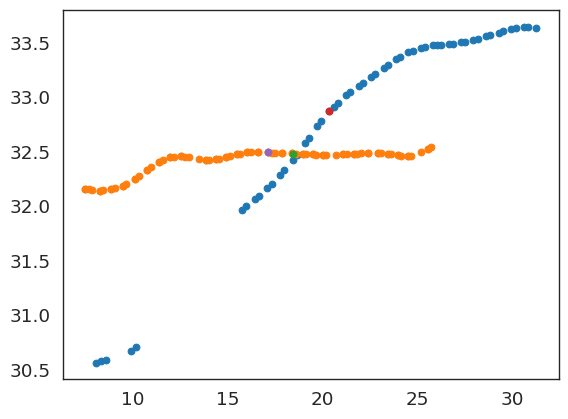

The conflict between vehicle  1046 and the vehicle   [1029]


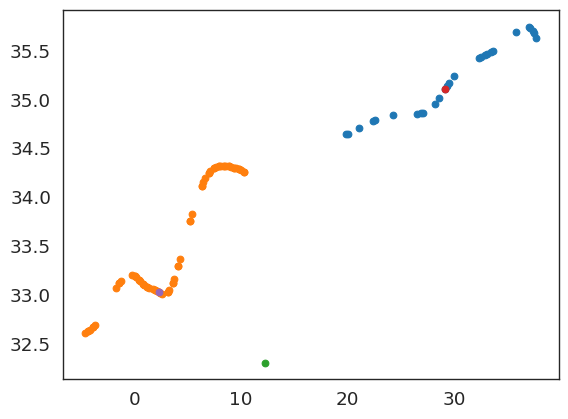

The conflict between vehicle  1048 and the vehicle   [1040]


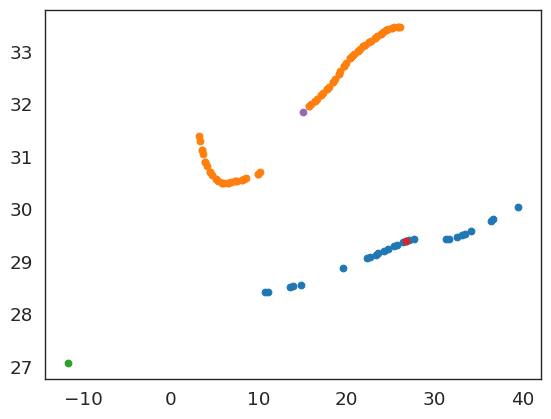

The conflict between vehicle  1065 and the vehicle   [1054]


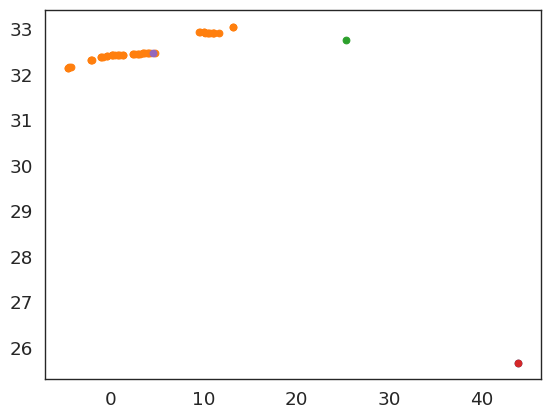

In [ ]:
# input the dataset of Traffic conflict
# /content/drive/MyDrive /Colab Notebooks/Traffic_Conflict/dataset/conflict_indector/Car_to_bike.csv
data_path = r'/content/drive/MyDrive /Colab Notebooks/Traffic_Conflict/dataset/conflict_indector/Car_to_E_bike.csv'
car_conflict_pet = pd.read_csv(data_path)
# Extract the event of conflict value blow 2 seconds
Car_car_pet_lesss_2 = car_conflict_pet[car_conflict_pet['PET']<=2]
Main_car_id = pd.unique(Car_car_pet_lesss_2['m_vehicle_id'])
Sub_car_id = pd.unique(Car_car_pet_lesss_2['sub_vehicle_id'])

# Search the point where the pet value is mininum
for car_id in Main_car_id:
    PET_set_Main_car = Car_car_pet_lesss_2[Car_car_pet_lesss_2['m_vehicle_id']==car_id]
    PET_set_Main_car_T = pd.DataFrame(PET_set_Main_car)

#   Veh_ty1,Veh_ty2,Veh_ty3 = Detect_interacte_object(PET_set_Main_car_T)
    PET_set_Main_car = PET_set_Main_car_T.drop_duplicates()
    Minimum_pet_fram,Min_PET,Mean_pet,Std_pet,conflict_point = Detect_Risk_frame(PET_set_Main_car)
    Minimum_pet_fram = Minimum_pet_fram.values
    conflict_point_x = conflict_point['cross_point_x'].values
    conflict_point_y = conflict_point['cross_point_y'].values

    if ((Mean_pet<=0.5) & (Mean_pet>=Std_pet) & (conflict_point_x[0]>=-20) &(conflict_point_x[0]<=55) &(conflict_point_y[0]>=-20) &(conflict_point_y[0]<=60)):      
        sub_conflict_car_id = Detect_Risk_subcar(PET_set_Main_car).values
        PET_set_sub_car = Car_car_pet_lesss_2[Car_car_pet_lesss_2['m_vehicle_id']==sub_conflict_car_id[0]]
        Time_Gap_Befor = 2
        Time_Gap_After = 2
        traffic_conflict_course_main = Event_extract(PET_set_Main_car,Minimum_pet_fram,Time_Gap_Befor,Time_Gap_After)

        traffic_conflict_course_sub = Event_extract(PET_set_sub_car,Minimum_pet_fram,Time_Gap_Befor,Time_Gap_After)
        Minimum_pet_postion = traffic_conflict_course_main[traffic_conflict_course_main['m_frame_time']==Minimum_pet_fram[0]]

        if (len(traffic_conflict_course_main)>0) &(len(traffic_conflict_course_sub)>0)&(len(Minimum_pet_postion)):
#       print(traffic_conflict_course_main,traffic_conflict_course_sub)
          print('The conflict between vehicle  '+str(car_id)+' and the vehicle   '+str(sub_conflict_car_id))
          plt.scatter(traffic_conflict_course_main['m_world_x'],traffic_conflict_course_main['m_world_y'])
          plt.scatter(traffic_conflict_course_sub['m_world_x'],traffic_conflict_course_sub['m_world_y'])
          plt.scatter(Minimum_pet_postion['cross_point_x'],Minimum_pet_postion['cross_point_y'])
          plt.scatter(Minimum_pet_postion['m_world_x'],Minimum_pet_postion['m_world_y'])
          plt.scatter(Minimum_pet_postion['sub_world_x'],Minimum_pet_postion['sub_world_y'])
          plt.show()